Instructions:
Explicar que en algunos pasos que pone generar  crear se crean guardan los arrays para que si lo vuelves a ejecutar simplemente se cargue

In [1]:
#@title Imports
# Update to plot with LaTex fonts
!apt-get update
from matplotlib import rc
import matplotlib
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
# Main libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
# Utils
from tqdm import tqdm
from sklearn.utils import shuffle
# Clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
# Image processing and transformations
from skimage.transform import resize
from skimage.transform import rotate
from skimage import transform as trfm
from skimage.metrics import structural_similarity as ssim
from skimage import color
# To handle files
import os
import pickle
from zipfile import ZipFile
# Scipy funcitons
from scipy import stats
from scipy.optimize import minimize_scalar
from scipy.io import loadmat
from scipy.cluster.hierarchy import dendrogram
# To display widgets in Jupyter Notebook
import ipywidgets as ipw
from IPython.core.display import HTML, display
from ipywidgets import widgets
# Set LaTex font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.0 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://developer.download.nvi

# Functions, click play to load all


In [2]:
''' Constants definition  '''
# To define the data range for the SSIM comparison. 
# The data range is 1 as the min value of the pixel is 0 and the max is 1
DATA_RANGE = 1
OBJS_DIR_NAME = 'objects'
!mkdir -p objects

## GradCAM

In [3]:
def grad_cam_plus(img, model,  layer_name, label_name=None, category_id=None):
    """Get a heatmap by Grad-CAM.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor) # De aqui se obtiene (8,8,640)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)
    global_sum = np.sum(conv_output, axis=(0, 1, 2))
    # Pixel importance weight 
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10) # To avoid dividing by zero
    alphas = alpha_num/alpha_denom 
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas = tf.math.divide_no_nan(alphas,alpha_normalization_constant) 
    weights = np.maximum(conv_first_grad[0], 0.0) # ReLU to gradients
    # Neuron Importance Weights
    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)
    # Only grab positive values
    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    heatmap = tf.math.divide_no_nan(heatmap, max_heat) 
    return heatmap


def grad_cam(img,model, 
             layer_name="block5_conv3", label_name=None,
             category_id=None):
    """Get a heatmap by Grad-CAM.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap)

## Visualizations

In [4]:
def plot_historia(history):
  '''
  Plot of the training
  '''
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[         'loss' ]
  val_loss = history.history[     'val_loss' ]
  epochs    = range(1,len(acc)+1,1) # obtener número de epochs del eje X

  plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
  plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
  plt.title ('Training and Validation Accuracy')
  plt.ylabel('acc')
  plt.xlabel('epochs')
  plt.legend()
  plt.figure()

  plt.plot  ( epochs,     loss, 'r--', label='Training loss'  )
  plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
  plt.title ('Training and Validation Loss'   )
  plt.ylabel('loss')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()


def cdf_difference(x,kde_ascending,kde_descending):
  '''
  Function that calculates the difference between two kdes
  '''
  cdf_ascending = []
  x_0 = np.linspace(-1,1,100)
  for i in x_0:
    cdf_ascending.append(kde_ascending.integrate_box_1d(-1,i))

  y_0 = x_0[::-1]
  cdf_descending = []
  for i in y_0:
    cdf_descending.append(kde_descending.integrate_box_1d(i,1))
  difference = cdf_ascending[int(x)] - cdf_descending[int(99-x)]
  return abs(difference)


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Utils

In [5]:
def search_index_of_class(class_index, n_times, labels, ini=0):
  '''
  Returns a list of lenght n_times with the indexes of the labels for a class.
  '''
  indexes = []
  n=0
  i=0
  while n < n_times:
    if class_index == np.argmax(labels[ini+i]):
      indexes.append(ini+i)
      n = n+1
    i = i+1
  return indexes


## Heatmap creation and manipulation


In [6]:
def creation_of_heatmaps_per_class(number_of_htmaps,instances,labels):
  '''
  Creates an array with the number of heatmaps selected per class
  '''
  heatmaps = np.empty((NUM_CLASSES,number_of_htmaps,model.get_layer(LAST_CONV_LAYER).output.shape[1],model.get_layer(LAST_CONV_LAYER).output.shape[2]))
  for class_index in tqdm(range(NUM_CLASSES)):
    # List of index of the labels for the class
    indexes_for_one_class = search_index_of_class(class_index,number_of_htmaps,labels)
    for loop_index,label_index in enumerate(indexes_for_one_class):
      # Fill the array with the heatmaps
      heatmaps[class_index,loop_index] = grad_cam_plus(instances[label_index],model,LAST_CONV_LAYER,category_id=np.argmax(labels[label_index]))
  return heatmaps


def compute_average_heatmaps_per_cluster(cluster_indexes, heatmaps_array, ssim_distance_matrix_one_class, avg_mode, thr=None):
  '''
  Computes the average per cluster of the provided heatmaps
  ::cluster_indexes: array with the cluster indexes
  ::heatmaps_array: array with the heatmaps. Shape = [number_of_htmaps, height, width]
  ::avg_mode: string that defines how to do the average
  ::thr: if we want to compute the average only on a percentage of the closest ones
          the threshold parameter should be included with the percentage in the range
          of 0 to 1.
  :Returns: array with the average heatmap per cluster
  ''' 
  # Extract unique numbers and how much of them are
  unique, counts = np.unique(cluster_indexes, return_counts=True)
  # Eliminate index -1 because it refers to outliers
  if -1 in unique:
    unique = np.delete(unique,0)
    counts = np.delete(counts,0)
  # Initialize the array where the average heatmaps are going to be stored
  avg_htmaps_per_cluster = np.empty((len(unique),heatmaps_array.shape[1],heatmaps_array.shape[2]))
  for index_unique,cluster in enumerate(unique):
    # Retrieve the indexes of the cluster
    indexes_one_cluster = np.asarray(np.asarray(cluster_indexes == cluster).nonzero()[0])
    # Either retrieve only the closest heatmaps of that cluster OR retrieve all
    if thr is not None and len(indexes_one_cluster) > 39: # Retrieval of only the closest ones
      # Initialize the array that will contain the mean D_ssim of each heatmap against the heatmaps of the cluster including itself
      mean_dist_ssim_of_htmaps_of_cluster = np.zeros((len(indexes_one_cluster)))
      for loop_index_1, index_htmap_1 in enumerate(indexes_one_cluster):
        # Initialize the array that will be used to collect the ssim values against the others to then compute the mean
        dist_ssim_of_one_htmap_against_all = np.zeros((len(indexes_one_cluster)))
        for loop_index_2, index_htmap_2 in enumerate(indexes_one_cluster):
          dist_ssim_of_one_htmap_against_all[loop_index_2] = ssim_distance_matrix_one_class[index_htmap_1, index_htmap_2]
        mean_dist_ssim_of_htmaps_of_cluster[loop_index_1] = np.mean(dist_ssim_of_one_htmap_against_all)
      # Sort mean ascending
      indexes_images_sorted_per_dist_ssim = np.argsort(mean_dist_ssim_of_htmaps_of_cluster)
      # Extract the introduced percent more closer of the cluster using thr parameter
      indexes_for_average_computation_percent = indexes_images_sorted_per_dist_ssim[:int(thr*len(mean_dist_ssim_of_htmaps_of_cluster))]
      htmaps_of_the_cluster = heatmaps_array[indexes_one_cluster][indexes_for_average_computation_percent]

    else: # Retrieval of all the heatmaps of the cluster
      indexes_one_cluster = np.sort(indexes_one_cluster)
      htmaps_of_the_cluster = heatmaps_array[indexes_one_cluster]

    # Compute the average depending on the mode selected
    if avg_mode == 'Mean':
      #print(htmaps_of_the_cluster.shape)
      htmap_prom_un_cluster = np.mean(htmaps_of_the_cluster, axis=0)

    elif avg_mode == 'Median':
      htmap_prom_un_cluster = np.median(htmaps_of_the_cluster, axis=0)
    else:
      raise NameError('Non-existant mode introduced')
    # For every cluster we add its average heatmap
    avg_htmaps_per_cluster[index_unique] = htmap_prom_un_cluster

  return avg_htmaps_per_cluster

  
def generate_heatmaps(images,preds):
  '''
  Generates the heatmaps of the images provided using the prediction (the label)
  '''
  htmaps = np.zeros((images.shape[0],model.get_layer(LAST_CONV_LAYER).output.shape[1],model.get_layer(LAST_CONV_LAYER).output.shape[2]))
  for i,image in tqdm(enumerate(images)):
    htmaps[i] = grad_cam_plus(image,model,LAST_CONV_LAYER,category_id=preds[i])
  return htmaps

## SSIM related functions

In [7]:
def cw_ssim(img1, img2):
  '''
  Function that receives two numpy array images and computes CW-SSIM
  '''
  img1 = PIL.Image.fromarray(np.uint8(img1*255))
  img2 = PIL.Image.fromarray(np.uint8(img2*255))
  # FOR EXPERIMENTS ONLY!
  # Very slow algorithm - up to 50x times slower than SIFT or SSIM.
  # Optimization using CUDA or Cython code should be explored in the future.
  return pyssim.SSIM(img1).cw_ssim_value(img2)


def ssim_distance_matrix_creation(heatmaps_array):
  '''
  Creates an upper triangular array with the pairwise distances between each heatmap in the array provided.
  '''
  ssim_mat = np.zeros((len(heatmaps_array),len(heatmaps_array)))
  for i,htmap in enumerate(heatmaps_array):
    # We visit every column which index is greater than the index of the current row.
    # The diagonal is not visited as the distance between two identical images is 0 
    # and the array is defined all zeros.
    for j in range(i+1,len(heatmaps_array)):
      ssim_mat[i,j] = ssim_distance(htmap,heatmaps_array[j])
      ssim_mat[j,i] = ssim_mat[i,j]
  return ssim_mat


def ssim_distance(img1,img2):
  '''
  Computed the Dssim between two images, defined as: 
  Dssim = (1 - SSIM)/2 
  This way, obtained value is between 0 and 1, 0 being distance between identical images
  '''  
  return (1-ssim(img1,img2, data_range=DATA_RANGE))/2


def compute_ssim_against_cluster_averages(input_heatmaps,preds,avg_htmaps_per_class_and_cluster,mode='Similarity'):
  '''
  Computes the ssim of the input heatmaps against the cluster averages of the predicted class
  '''
  # Initialize the array containing the SSIM values
  ssim_per_input_heatmap = np.zeros((len(input_heatmaps)))
  for index,predicted_class in tqdm(enumerate(preds)):
    # Initialize the aray containing the SSIM values against cluster averages for one input heatmap
    ssim_against_cluster_avgs = np.zeros((avg_htmaps_per_class_and_cluster[predicted_class].shape[0]))
    if mode == 'Similarity':
      for index_avg_htmap, avg_htmap  in enumerate(avg_htmaps_per_class_and_cluster[predicted_class]):
        ssim_against_cluster_avgs[index_avg_htmap] = ssim(avg_htmap,input_heatmaps[index], data_range=DATA_RANGE)
    elif mode == 'Distance':
      for index_avg_htmap, avg_htmap  in enumerate(avg_htmaps_per_class_and_cluster[predicted_class]):
        ssim_against_cluster_avgs[index_avg_htmap] = ssim_distance(avg_htmap,input_heatmaps[index])
    else:
      raise NameError('Selected mode does not exist')
    # Select the more similar average heatmap (the max SSIM value)  
    ssim_per_input_heatmap[index] = np.max(ssim_against_cluster_avgs) 
  return ssim_per_input_heatmap


def compute_ssim_against_all_heatmps_of_closest_cluster(input_heatmaps, preds, avg_htmaps_per_class_and_cluster, heatmaps_in_the_clusters_per_class, cluster_indexes_of_heatmaps):
  '''
  Computes the ssim of the input heatmaps against all the heatmaps of the closest cluster of the predicted class.
  First computes the SSIM against cluster averages, and it selects the max similarity (max ssim).
  Then computes the SSIM against all the heatmaps belonging to that cluster
  '''
  # Initialize the array that will contain the SSIM values
  ssim_per_input_heatmap = np.zeros((len(input_heatmaps)))
  for index,predicted_class in tqdm(enumerate(preds)):
    # Initialize the array that will contain the SSIM values to the cluster averages.
    ssim_against_cluster_avgs = np.zeros((len(avg_htmaps_per_class_and_cluster[predicted_class])))
    for index_avg_htmap, avg_htmap in enumerate(avg_htmaps_per_class_and_cluster[predicted_class]):
      # Calculamos cual las distancias a cada cluster y nos quedamos con el heatmap mas cercano del cluster mas cercano
      ssim_against_cluster_avgs[index_avg_htmap] = ssim(input_heatmaps[index],avg_htmap, data_range=DATA_RANGE)
      closest_cluster_index = np.argmax(ssim_against_cluster_avgs) # Max similarity == Closest cluster
    # Indexes of the heatmaps that belong to the nearest cluster.
    indexes_of_closest_cluster_heatmaps = np.asarray(np.asarray(cluster_indexes_of_heatmaps[predicted_class] == closest_cluster_index).nonzero()[0])
    # Compute every SSIM value to the heatmaps in the closest cluster
    # Initialze the array that will contain the SSIM values against all heatmaps in closest cluster
    ssim_against_closest_cluster_heatmaps = np.zeros((len(indexes_of_closest_cluster_heatmaps)))
    for i, htmap_indexes in enumerate(indexes_of_closest_cluster_heatmaps):
      ssim_against_closest_cluster_heatmaps[i] = ssim(input_heatmaps[index],heatmaps_in_the_clusters_per_class[predicted_class,htmap_indexes], data_range=DATA_RANGE)
    # Select the more similar average heatmap (the max SSIM value) 
    ssim_per_input_heatmap[index] = np.max(ssim_against_closest_cluster_heatmaps) 
  return ssim_per_input_heatmap

## Metrics

In [8]:
# Similarity
def similarity_thresholds_for_each_TPR(similarity_test):
  # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
  sorted_similarity_test = [np.sort(x)[::-1] for x in similarity_test]
  tpr_range = np.arange(0,1,0.005)
  tpr_range[-1] = 0.99999999 # For selecting the last item correctly
  similarity_thresholds_test = np.zeros((NUM_CLASSES, len(tpr_range)))
  for class_index in range(NUM_CLASSES):
    for index, tpr in enumerate(tpr_range):
      similarity_thresholds_test[class_index, index] = sorted_similarity_test[class_index][int(len(sorted_similarity_test[class_index])*tpr)]
  return similarity_thresholds_test


def compare_similarity_to_similarity_thrs(distances_list_per_class, thr_distances_array):
  '''
  Function that creates an array of shape (tpr, InD_or_OD), where tpr has the lenght of the number of steps of the TPR list
  and second dimensions has the total lenght of the distances_list_per_class, and cotains True if its InD and False if is OD
  :distances_list_per_class: list with each element being an array with the distances to avg clusters of one class [array(.), array(.)]
  :thr_distances_array: array of shape (class, dist_for_each_tpr), where first dimension is the class and the second is the distance for the TPR
   corresponding to that position. For example, the TPR = 0.85 corresponds to the 85th position.
  '''
  in_or_out_distribution_per_tpr = np.zeros((len(np.transpose(thr_distances_array)),len(np.concatenate(distances_list_per_class))),dtype=bool)
  for tpr_index ,thr_distances_per_class in enumerate(np.transpose(thr_distances_array)):
      in_or_out_distribution_per_tpr[tpr_index] = np.concatenate([dist_one_class > thr_distances_per_class[cls_index] for cls_index, dist_one_class in enumerate(distances_list_per_class)])
    
  return in_or_out_distribution_per_tpr


def compute_precision_tpr_fpr_for_test_and_OoD_similarity(dist_test, dist_OoD,dist_thresholds_test):
  # Creation of the array with True if predicted InD (True) or OD (False)
  in_or_out_distribution_per_tpr_test = compare_similarity_to_similarity_thrs(dist_test, dist_thresholds_test)
  in_or_out_distribution_per_tpr_test[0] = np.zeros((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that first element is True when TPR is 0
  in_or_out_distribution_per_tpr_test[-1] = np.ones((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that last element is True when TPR is 1
  in_or_out_distribution_per_tpr_OoD = compare_similarity_to_similarity_thrs(dist_OoD, dist_thresholds_test)

  # Creation of arrays with TP, FN and FP, TN
  tp_fn_test = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_test)
  fp_tn_OoD = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_OoD)

  # Computing TPR, FPR and Precision
  tpr_values = tp_fn_test[:,0] / (tp_fn_test[:,0] + tp_fn_test[:,1])
  fpr_values = fp_tn_OoD[:,0] / (fp_tn_OoD[:,0] + fp_tn_OoD[:,1])
  precision  = tp_fn_test[:,0] / (tp_fn_test[:,0] + fp_tn_OoD[:,0])

  # Eliminating NaN value at TPR = 1
  precision[0] = 1
  return precision, tpr_values, fpr_values


# For both
def tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr):
  '''
  Function that creates an array with the number of values of tp and fp or fn and tn, depending on if the 
  passed array is InD or OD.
  :in_or_out_distribution_per_tpr: array with True if predicted InD and False if predicted OD, for each TPR
  ::return: array with shape (tpr, 2) with the 2 dimensions being tp,fn if passed array is InD, and fp and tn if the passed array is OD
  '''
  tp_fn_fp_tn = np.zeros((len(in_or_out_distribution_per_tpr),2),dtype='uint16')
  length_array = in_or_out_distribution_per_tpr.shape[1]
  for index, element in enumerate(in_or_out_distribution_per_tpr):
    n_True = int(len(element.nonzero()[0]))
    tp_fn_fp_tn[index,0] = n_True
    tp_fn_fp_tn[index,1] = length_array - n_True
  return tp_fn_fp_tn

## Dataset loading and transforming functions

In [9]:
def download_SVHN():
  '''
  Function that downloads the SVHN Cropped dataset
  '''
  !cd /content/
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Qezu-SHyjBF_fGwdFYUSioVbAu3GMfBj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Qezu-SHyjBF_fGwdFYUSioVbAu3GMfBj" -O SVHN_Cropped.zip && rm -rf /tmp/cookies.txt
  return '/content/SVHN_Cropped.zip'


def download_weights_and_model():
  '''
  Function that downloads the weights and the ResNet32v1 model from Google Drive
  '''
  %cd /content/
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kubVcEv8ORheY0_3NuGb7VwE8OMbX5G9' -O OoD_xAI.zip
  return '/content/OoD_xAI.zip'


def unzip_file(zip_file_path):
  '''
  Function that extracts the zip file and deletes it, returnin the new file path
  '''
  # Create a ZipFile Object and load sample.zip in it
  with ZipFile(zip_file_path, 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
  !rm -r $zip_file_path
  return zip_file_path[:-4]


def load_svhn(image_dir, image_file):
  print ('Loading SVHN dataset.')
  image_dir = os.path.join(image_dir, image_file)
  svhn = loadmat(image_dir)
  images = np.transpose(svhn['X'], [3, 0, 1, 2]).astype('float32')/255
  labels = svhn['y']
  labels[np.where(labels==10)] = 0
  labels = to_categorical(labels)
  return images, labels


def load_test_sample_of_dataset(dataset_name):
  # Load the selected dataset
  if dataset_name == 'SVHN_cropped':
    # Download SVHN
    SVHN_FOLDER_PATH = unzip_file(download_SVHN())
    images, labels = load_svhn(SVHN_FOLDER_PATH,"test_32x32.mat")
    np.random.shuffle(images)
    images = images[:10000]
  elif dataset_name == 'MNIST':
    (_, _), (images, labels) = tf.keras.datasets.mnist.load_data()
    images = images/255
    images = images.reshape(10000,28,28,1)
    images = images.astype('float32')
    labels = to_categorical(labels)
  elif dataset_name == 'Fashion_MNIST':
    (_, _), (images, labels) = tf.keras.datasets.fashion_mnist.load_data()
    images = images/255
    images = images.reshape(10000,28,28,1)
    images = images.astype('float32')
  elif dataset_name == 'MNIST_color':
    (_, _), (images, labels) = tf.keras.datasets.mnist.load_data()
    images = images/255
    images = images.reshape(10000,28,28,1)
    images = images.astype('float32')
    images = np.tile(images,3)
    images = resize(images,(10000, 32, 32, 3)) 
  elif dataset_name == 'Fashion_MNIST_color':
    (_, _), (images, labels) = tf.keras.datasets.fashion_mnist.load_data()
    images = images/255
    images = images.reshape(10000,28,28,1)
    images = images.astype('float32')
    images = np.tile(images,3)
    images = resize(images,(10000, 32, 32, 3))
  elif dataset_name == 'Cifar10_grey':
    cifar = tf.keras.datasets.cifar10
    (_, _), (images, labels) = cifar.load_data()
    # Damos el formato correspondiente a las imagenes
    images = images.reshape(10000, 32, 32, 3)
    images = images.astype('float32') / 255
    images = np.expand_dims(color.rgb2gray(images),axis=3)
    images = resize(images,(10000, 28, 28, 1))
  elif dataset_name == 'Cifar10':
    cifar = tf.keras.datasets.cifar10
    (_, _), (images, labels) = cifar.load_data()
    # Damos el formato correspondiente a las imagenes
    images = images.reshape(10000, 32, 32, 3)
    images = images.astype('float32') / 255
  else:
    raise NameError()
  return images, labels


# Rotate images (17s 60.000 images)
def rotate_images(images, angle):
  for i,img in enumerate(images):
    images[i] = rotate(img,angle)
  return images


# Translation
def translate_images(images, h_trans, v_trans):
  translation = (h_trans,v_trans)
  tform = trfm.SimilarityTransform(translation=translation)
  for i,img in enumerate(images):
    images[i] = trfm.warp(img, tform)
  return images

# Dataset and model selection


In [47]:
#@title Click Play to select the In-Distribution Dataset
greyChannelDatasets = ['MNIST','Fashion_MNIST']
colorDatasets       = ['Cifar10']
datasetOptions = greyChannelDatasets + colorDatasets
selectedDataset = widgets.Combobox(
    placeholder='Choose the In-Distribution dataset',
    options=datasetOptions,
    description='In-Distribution Dataset:',
    ensure_option=True,
    disabled=False,
    layout = ipw.Layout(width='325px')
)
selectedDataset

Combobox(value='', description='In-Distribution Dataset:', ensure_option=True, layout=Layout(width='325px'), o…

In [48]:
#@title Click Play to select the Out-Distribution Dataset
odDatasetsOptions_color = ['MNIST_color','Fashion_MNIST_color','SVHN_cropped', 'Cifar10']
odDatasetsOptions_grey_mnist  = ['MNIST','Fashion_MNIST','SVHN_cropped','Cifar10_grey']
odDatasetsOptions_grey_fashion  = ['MNIST','Fashion_MNIST','SVHN_cropped','Cifar10_grey']
if selectedDataset.value in greyChannelDatasets:
  if selectedDataset.value == greyChannelDatasets[0]:
    OD_dataset  = widgets.Combobox(
        placeholder='Choose the Out-Distribution dataset',
        options=odDatasetsOptions_grey_mnist,
        description='Out-Distribution Dataset:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width='325px')
    )
  else:
    OD_dataset  = widgets.Combobox(
        placeholder='Choose the Out-Distribution dataset',
        options=odDatasetsOptions_grey_fashion,
        description='Out-Distribution Dataset:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width='325px')
    )
else:
  OD_dataset  = widgets.Combobox(
      placeholder='Choose the Out-Distribution dataset',
      options=odDatasetsOptions_color,
      description='Out-Distribution Dataset:',
      ensure_option=True,
      disabled=False,
      layout = ipw.Layout(width='325px')
  )
OD_dataset

Combobox(value='', description='Out-Distribution Dataset:', ensure_option=True, layout=Layout(width='325px'), …

In [49]:
#@title Click Play to chose the model
greyModelOptions  = ['LeNet']
colorModelOptions = ['ResNet32','Simple_ConvNet']

if selectedDataset.value in greyChannelDatasets:

    selectedModel = widgets.Combobox(
        placeholder='Choose the Model',
        options=greyModelOptions,
        description='Models:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width='325px')
        )

else:
  selectedModel = widgets.Combobox(
      placeholder='Choose the Model',
      options=colorModelOptions,
      description='Models:',
      ensure_option=True,
      disabled=False,
      layout = ipw.Layout(width='325px')
      )

selectedModel

Combobox(value='', description='Models:', ensure_option=True, layout=Layout(width='325px'), options=('LeNet',)…

In [50]:
#@title Load the selected dataset and model
# Extract the name of the chosen dataset
DATASET_NAME = selectedDataset.value
OD_DATASET_NAME = OD_dataset.value
SEED = 8 # Predefine the seed, just in case the used does not use the widget
# Dowload pretrained weights and ResNet32v1 model
try:
  if os.path.isdir(PRETRAINED_WEIGHTS_AND_MODEL_FOLDER_PATH):
    pass
  else:
    PRETRAINED_WEIGHTS_AND_MODEL_FOLDER_PATH = unzip_file(download_weights_and_model())
except NameError:
  PRETRAINED_WEIGHTS_AND_MODEL_FOLDER_PATH = unzip_file(download_weights_and_model())
if DATASET_NAME == 'Cifar10':
  cifar = tf.keras.datasets.cifar10
  (train_images, train_labels_clases), (test_images, test_labels_clases) = cifar.load_data()
  # Format images
  train_images = train_images.reshape(50000, 32, 32, 3)
  train_images = train_images.astype('float32') / 255
  test_images = test_images.reshape(10000, 32, 32, 3)
  test_images = test_images.astype('float32') / 255
  # Labels to categorical (10 dimensions with a 1 in the correspondent class)
  train_labels = to_categorical(train_labels_clases)
  test_labels = to_categorical(test_labels_clases)
  # Definition of the constants of the dataset
  CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
  NUM_CLASSES = len(CLASS_NAMES)

elif DATASET_NAME == 'SVHN_Cropped':
  # Download SVHN
  SVHN_FOLDER_PATH = unzip_file(download_SVHN())
  # Load SVHN
  train_images, train_labels = load_svhn(SVHN_FOLDER_PATH, 'train_32x32.mat')
  test_images, test_labels = load_svhn(SVHN_FOLDER_PATH,'test_32x32.mat')
  # Definition of the constants of the dataset
  CLASS_NAMES = list(np.linspace(0,9,10).astype('int'))
  CLASS_NAMES = [str(i) for i in CLASS_NAMES]
  NUM_CLASSES = len(CLASS_NAMES)

elif DATASET_NAME == 'MNIST':
  # Load the dataset
  (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
  # Reduce the range of the images to [0,1]
  train_images = train_images/255
  test_images = test_images/255
  # Format images
  train_images = train_images.reshape(60000,28,28,1)
  train_images = train_images.astype('float32')
  test_images = test_images.reshape(10000,28,28,1)
  test_images = test_images.astype('float32')
  # Labels to categorical (10 dimensions with a 1 in the correspondent class)
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)
  # Definition of the constants of the dataset
  CLASS_NAMES = list(np.linspace(0,9,10).astype('int'))
  CLASS_NAMES = [str(i) for i in CLASS_NAMES]
  NUM_CLASSES = len(CLASS_NAMES)
  

elif DATASET_NAME == 'Fashion_MNIST':
  # Load F_MNIST dataset
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
  # Reduce the range of the images to [0,1]
  train_images = train_images/255
  test_images = test_images/255
  # Format images
  train_images = train_images.reshape(60000,28,28,1)
  train_images = train_images.astype('float32')
  test_images = test_images.reshape(10000,28,28,1)
  test_images = test_images.astype('float32')
  # Labels to categorical (10 dimensions with a 1 in the correspondent class)
  from tensorflow.keras.utils import to_categorical
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)
  # Definition of the constants of the dataset
  CLASS_NAMES = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  NUM_CLASSES = len(CLASS_NAMES)

else:
  raise NameError('Dataset name not found in the dataset options')

# Extract the name of the chosen model
MODEL_NAME = selectedModel.value 
# The input shape of the dataset
INPUT_SHAPE = (train_images[0].shape)
if DATASET_NAME in greyChannelDatasets:

  if MODEL_NAME == 'Custom_ConvNet':
    model = keras.Sequential(
          [
          keras.layers.InputLayer(input_shape=INPUT_SHAPE),
          keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",name='conv2d'),
          keras.layers.MaxPooling2D(pool_size=(2, 2), name= 'max_pooling2d'),
          keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu",name='conv2d_1'),
          keras.layers.MaxPooling2D(pool_size=(2, 2), name= 'max_pooling2d_1'),
          keras.layers.Dropout(0.25,name='dropout'),
          keras.layers.Flatten(name='flatten'),
          keras.layers.Dense(64,activation='relu',name='dense'),
          keras.layers.Dropout(0.25,name='dropout_1'),
          keras.layers.Dense(10, activation="softmax", name='softmax'),
          ]
          )

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  elif MODEL_NAME == 'LeNet':
    model = keras.Sequential(
        [
          keras.layers.InputLayer(input_shape=INPUT_SHAPE),
          keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",name='conv2d'),
          keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu",name='conv2d_1'),
          keras.layers.MaxPooling2D(pool_size=(2, 2), name= 'max_pooling2d_1'),
          keras.layers.Dropout(0.25,name='dropout'),
          keras.layers.Flatten(name='flatten'),
          keras.layers.Dense(128,activation='relu',name='dense'),
          keras.layers.Dropout(0.25,name='dropout_1'),
          keras.layers.Dense(10, activation="softmax", name='softmax'),

        ]
    )

    # As in the github example
    def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * 0.7

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

else:
    
  if  MODEL_NAME == 'WideResnet_28_10':

    %cd /content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Models
    model = tf.keras.models.load_model('WRSNT_28_10')

    # Creamos la intancia de ImageDataGenerator que procesará las imagenes de entrada
    # La ZCA whitening sobreescribe el Featureweise_std_norm por lo que no importa que sea True o False
    test_datagen = keras.preprocessing.image.ImageDataGenerator(
                        featurewise_center=True,
                        featurewise_std_normalization=False, 
                        zca_whitening=True)
    test_datagen.fit(train_images)

    # Creation of the arrays with preprocessed train and test split
    batch_size_img_preprocesor = 100
    seed_img_preprocessor      = 5

    # Creation of the object containing the batches of (images, labels)
    batches = test_datagen.flow(train_images,train_labels,seed=seed_img_preprocessor,shuffle=True,batch_size=batch_size_img_preprocesor)

    # Loop for extracting all the batches of train
    for i in range(int(len(train_images)/batch_size_img_preprocesor)): #1st batch is alread fetched before the for loop
      imgs, labels = next(batches)
      train_images[i:i+batch_size_img_preprocesor] = imgs
      train_labels[i:i+batch_size_img_preprocesor] = labels

    # Same for test
    batches = test_datagen.flow(test_images,test_labels,seed=seed_img_preprocessor,shuffle=True,batch_size=batch_size_img_preprocesor)

    for i in range(int(len(test_images)/batch_size_img_preprocesor)):
      imgs, labels = next(batches)
      test_images[i:i+batch_size_img_preprocesor] = imgs
      test_labels[i:i+batch_size_img_preprocesor] = labels

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)


  elif MODEL_NAME == 'VGG16':

    model = tf.keras.applications.VGG16(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=(train_images.shape[1:]),
      pooling=None,
      classes=1000,
      classifier_activation="softmax"
    )

  elif MODEL_NAME =='ResNet32':
    %pip install download
    %cd $PRETRAINED_WEIGHTS_AND_MODEL_FOLDER_PATH
    # Import the function to create the model and create it
    from resnet_32 import create_model
    model = create_model((32,32,3),10,'ResNet32v1')
    %cd /content/

  elif MODEL_NAME == 'Simple_ConvNet':
    model = Sequential()
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=INPUT_SHAPE))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # FLATTERN => DENSE => RELU => DROPOUT
    model.add(Flatten())
    model.add(Dense(512, activation ='relu'))
    model.add(Dropout(0.5))
    # a softmax classifier
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
  elif MODEL_NAME == 'LeNet':
    model = keras.Sequential(
        [
          keras.layers.InputLayer(input_shape=INPUT_SHAPE),
          keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",name='conv2d'),
          keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu",name='conv2d_1'),
          keras.layers.MaxPooling2D(pool_size=(2, 2), name= 'max_pooling2d_1'),
          keras.layers.Dropout(0.25,name='dropout'),
          keras.layers.Flatten(name='flatten'),
          keras.layers.Dense(128,activation='relu',name='dense'),
          keras.layers.Dropout(0.25,name='dropout_1'),
          keras.layers.Dense(10, activation="softmax", name='softmax'),

        ]
    )

    # As in the github example
    def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * 0.7

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


  else:
    raise NameError('The name of the searched model does not exist')

# Save the name of the last convolutional layer
for layer in model.layers[::-1]:
  if isinstance(layer,(keras.layers.Conv2D,keras.layers.Add)):
    LAST_CONV_LAYER = layer.name
    break

print('-'*65)   
print('Dataset loaded successfully!')
print('-'*65)
print('Model summary:')
print('-'*14)
model.summary()

4431872/4422102 [==============================] - 0s 0us/step
-----------------------------------------------------------------
Dataset loaded successfully!
-----------------------------------------------------------------
Model summary:
--------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 


In [51]:
#@title Select if you want to load the pretrained weights used in the paper or to train the networks yourself
# Training of the models taking into account what model you have chosen
def on_button_clicked_load_or_train(_):
  global model
  global PRETRAINED_WEIGHTS_PATH
  # Change to success type button  
  button.button_style = 'success'
  button.description = 'Option confirmed!'
  # Load
  if load_or_train.value == 'Load':
    print()
    PRETRAINED_WEIGHTS_PATH = os.path.join(PRETRAINED_WEIGHTS_AND_MODEL_FOLDER_PATH, f'{DATASET_NAME}_{MODEL_NAME}.h5')
    if MODEL_NAME == 'Simple_ConvNet':
      pass 
    elif MODEL_NAME == 'Resnet34_V2':
      pass
    elif MODEL_NAME == "LeNet": 
      if DATASET_NAME == 'MNIST':
        model.load_weights(PRETRAINED_WEIGHTS_PATH)
        print('Weights succesfully loaded! Wait until model.evaluate() is performed')
        metrics = model.evaluate(test_images, test_labels)
        print('Accuracy obtained is',str(round(metrics[1]*100,2))+'%')
      if DATASET_NAME == 'Fashion_MNIST':
        model.load_weights(PRETRAINED_WEIGHTS_PATH)
        print('Weights succesfully loaded! Wait until model.evaluate() is performed')
        metrics = model.evaluate(test_images, test_labels)
        print('Accuracy obtained is',str(round(metrics[1]*100,2))+'%')
      if DATASET_NAME == 'SVHN_Cropped':
        model.load_weights(PRETRAINED_WEIGHTS_PATH)
        print('Weights succesfully loaded! Wait until model.evaluate() is performed')
        metrics = model.evaluate(test_images, test_labels)
        print('Accuracy obtained is',str(round(metrics[1]*100,2))+'%')
    elif MODEL_NAME == "Custom_ConvNet":
      model.load_weights('.h5')
      print('Weights succesfully loaded! Wait until model.evaluate() is performed')
      metrics = model.evaluate(test_images, test_labels)
      print('Accuracy obtained is',str(round(metrics[1]*100,2))+'%')
    elif MODEL_NAME == "ResNet32": 
      if DATASET_NAME == 'SVHN_Cropped':
        model.load_weights(PRETRAINED_WEIGHTS_PATH)
        metrics = model.evaluate(test_images, test_labels)
        print('Accuracy obtained is',str(round(metrics[1]*100,2))+'%')
      elif DATASET_NAME == 'Cifar10':
        # Load the model weights and define the 
        model.load_weights(PRETRAINED_WEIGHTS_PATH)
        optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])
        print('Weights succesfully loaded! Wait until model.evaluate() is performed')
        metrics = model.evaluate(test_images, test_labels)
        print('Accuracy obtained is',str(round(metrics[1]*100,2))+'%')
  # Train      
  elif load_or_train.value == 'Train':
    # Training of the models taking into account what model you have chosen
    if MODEL_NAME == 'Simple_ConvNet':
      # Hyperparameters
      batch_size        = 100
      epochs            = 70
      data_augmentation = False
      # Training
      history = None  # For recording the history of trainning process.
      if not data_augmentation:
          print('Not using data augmentation.')
          history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    validation_split = 0.02,
                    epochs=epochs,
                    shuffle=True)
      else:
          print('Using real-time data augmentation.')
          # This will do preprocessing and realtime data augmentation:
          datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              featurewise_center=False,  # set input mean to 0 over the dataset
              samplewise_center=False,  # set each sample mean to 0
              featurewise_std_normalization=False,  # divide inputs by std of the dataset
              samplewise_std_normalization=False,  # divide each input by its std
              zca_whitening=False,  # apply ZCA whitening
              zca_epsilon=1e-06,  # epsilon for ZCA whitening
              rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
              # randomly shift images horizontally (fraction of total width)
              width_shift_range=0.1,
              # randomly shift images vertically (fraction of total height)
              height_shift_range=0.1,
              shear_range=0.,  # set range for random shear
              zoom_range=0.,  # set range for random zoom
              channel_shift_range=0.,  # set range for random channel shifts
              # set mode for filling points outside the input boundaries
              fill_mode='nearest',
              cval=0.,  # value used for fill_mode = "constant"
              horizontal_flip=True,  # randomly flip images
              vertical_flip=False,  # randomly flip images
              # set rescaling factor (applied before any other transformation)
              rescale=None,
              # set function that will be applied on each input
              preprocessing_function=None,
              # image data format, either "channels_first" or "channels_last"
              data_format=None,
              # fraction of images reserved for validation (strictly between 0 and 1)
              validation_split=0.02)
          # Compute quantities required for feature-wise normalization
          # (std, mean, and principal components if ZCA whitening is applied).
          datagen.fit(train_images)
          # Fit the model on the batches generated by datagen.flow().
          history = model.fit(datagen.flow(train_images,train_labels,batch_size=batch_size,shuffle=True,subset='training'),
                                          epochs=epochs,
                                          validation_data=datagen.flow(train_images,train_labels,batch_size=10,shuffle=True,subset='validation'),
                                          )
    elif MODEL_NAME == 'Resnet34_V2':
      # Scheduler
      def scheduler(epoch, lr):
        if epoch < 10:
          return lr
        else:
          return lr * 0.9
      batch_size = 64
      epochs = 20
      callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
      history = model.fit(train_images, train_labels, batch_size ,epochs ,verbose=1, callbacks=[callback] ,validation_split=0.05)
    elif MODEL_NAME == "LeNet": 
      # Train with the lr scheduler and with parameters as in the github FSSD_OoD
      batch_size = 64
      epochs = 14
      callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
      history=model.fit(train_images, train_labels, batch_size ,epochs ,verbose=1, callbacks=[callback] ,validation_split=0.05)
    elif MODEL_NAME == "Custom_ConvNet":
      # Train
      batch_size = 64
      epochs     = 8
      history=model.fit(train_images, train_labels, batch_size ,epochs ,verbose=1, validation_split=0.1)
    elif MODEL_NAME == "ResNet32":
      # Import the function to create the model and create it
      from resnet_32 import create_model
      model = create_model((32,32,3),10,'ResNet32')
      optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
      model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])
      history = model.fit(train_images,train_labels, batch_size=250,epochs = 50, validation_split=0.2)

    model.save_weights('{}_{}.h5'.format(dataset,MODEL_NAME))
  else:
    raise NameError('Selected option not available')

load_or_train = widgets.Combobox(placeholder='Choose to load or train',
        options=['Load', 'Train'],
        description='Options:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width='325px')
        )
button = widgets.Button(
    description='Push the button to confirm',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width='325px')
)
button.on_click(on_button_clicked_load_or_train)
display(load_or_train)
display(button)

Combobox(value='', description='Options:', ensure_option=True, layout=Layout(width='325px'), options=('Load', …

Button(button_style='info', description='Push the button to confirm', icon='check', layout=Layout(width='325px…


Weights succesfully loaded! Wait until model.evaluate() is performed
313/313 [==============================] - 1s 3ms/step - loss: 0.2711 - accuracy: 0.9323
Accuracy obtained is 93.23%


# Training of the OOD detector


In [20]:
#@title Select the value of the seed for shuffling the train array, reponsible of cluster creation. 
#@markdown In the paper, seed = 8 is used.
selected_seed = widgets.IntText(
    value='8',
    ensure_option=True,
    disabled=False,
    layout = ipw.Layout(width='150px')
)
text = 'Enter the value of the seed:'
instructions = ipw.widgets.HTML(text)
display(instructions)
display(selected_seed)

HTML(value='Enter the value of the seed:')

IntText(value=8, layout=Layout(width='150px'))

In [52]:
#@title Generate the heatmaps for each class to clusterize
# Create a shuffled copy to train
!mkdir -p objects
SEED = selected_seed.value
NUMBER_OF_INSTANCES_PER_CLASS = 1000
train_images_shuffled, train_labels_shuffled = shuffle(train_images,train_labels,random_state=SEED)
# Creation of the arary with N heatmaps per class. This heatmaps are the ones 
# used for creating the clusters. 
# Shape = (number_of_classes, number_of_heatmaps, height,width)
file_name_heatmaps_train_per_class = f'heatmaps_train_per_class_{DATASET_NAME}_{MODEL_NAME}_{load_or_train.value}_seed{SEED}.npy'
path_heatmaps_train_per_class = os.path.join(OBJS_DIR_NAME, file_name_heatmaps_train_per_class)
if os.path.isfile(path_heatmaps_train_per_class):
  heatmaps_train_per_class = np.load(path_heatmaps_train_per_class)
  print('Heatmaps loaded from file')
else:
  print('Heatmap generation:')
  heatmaps_train_per_class = creation_of_heatmaps_per_class(NUMBER_OF_INSTANCES_PER_CLASS,train_images_shuffled,train_labels_shuffled) 
  np.save(path_heatmaps_train_per_class, heatmaps_train_per_class, allow_pickle=False)

Heatmap generation:


100%|██████████| 10/10 [03:38<00:00, 21.83s/it]


In [53]:
#@title Compute the distance matrix with pairwise SSIM distance (D_ssim)
# Creation of the matrix with the Dssim values in pairs (15 mins approx.)
!mkdir -p objects
file_name_pairwise_dist_matrix = f'ssim_distance_matrix_per_class_{DATASET_NAME}_{MODEL_NAME}_{load_or_train.value}_seed{SEED}.npy'
path_pairwise_dist_matrix = os.path.join(OBJS_DIR_NAME, file_name_pairwise_dist_matrix)
if os.path.isfile(path_pairwise_dist_matrix):
  ssim_distance_matrix_per_class = np.load(path_pairwise_dist_matrix)
  print('Distance matrix loaded from file')
else:
  print('Pairwise distances matrix computation:')
  ssim_distance_matrix_per_class = np.zeros((NUM_CLASSES,heatmaps_train_per_class.shape[1],heatmaps_train_per_class.shape[1])) 
  for class_index in tqdm(range(NUM_CLASSES)):
    ssim_distance_matrix_per_class[class_index] = ssim_distance_matrix_creation(heatmaps_train_per_class[class_index])
  np.save(path_pairwise_dist_matrix, ssim_distance_matrix_per_class, allow_pickle=False)

Pairwise distances matrix computation:


100%|██████████| 10/10 [16:05<00:00, 96.56s/it]


Selecting the parameter "distance_threshold" of Agglomerative Clustering by optimizing the Silhouette score



100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


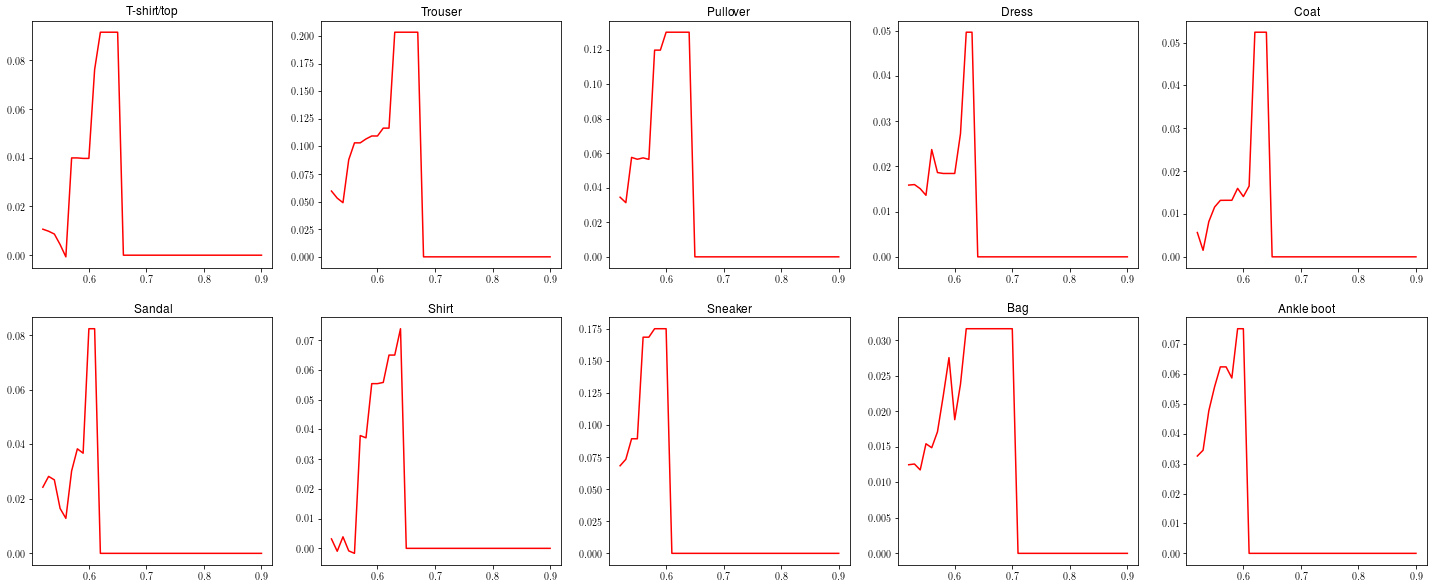

---------------------------------------------------------------------------------------------------- 

Class T-shirt/top     	 {0.0: 895, 1.0: 105}
---------------------------------------------------------------------------
Class Trouser         	 {0.0: 952, 1.0: 48}
---------------------------------------------------------------------------
Class Pullover        	 {0.0: 902, 1.0: 98}
---------------------------------------------------------------------------
Class Dress           	 {0.0: 355, 1.0: 645}
---------------------------------------------------------------------------
Class Coat            	 {0.0: 746, 1.0: 254}
---------------------------------------------------------------------------
Class Sandal          	 {0.0: 693, 1.0: 307}
---------------------------------------------------------------------------
Class Shirt           	 {0.0: 154, 1.0: 846}
---------------------------------------------------------------------------
Class Sneaker         	 {0.0: 300, 1.0: 700}
-------

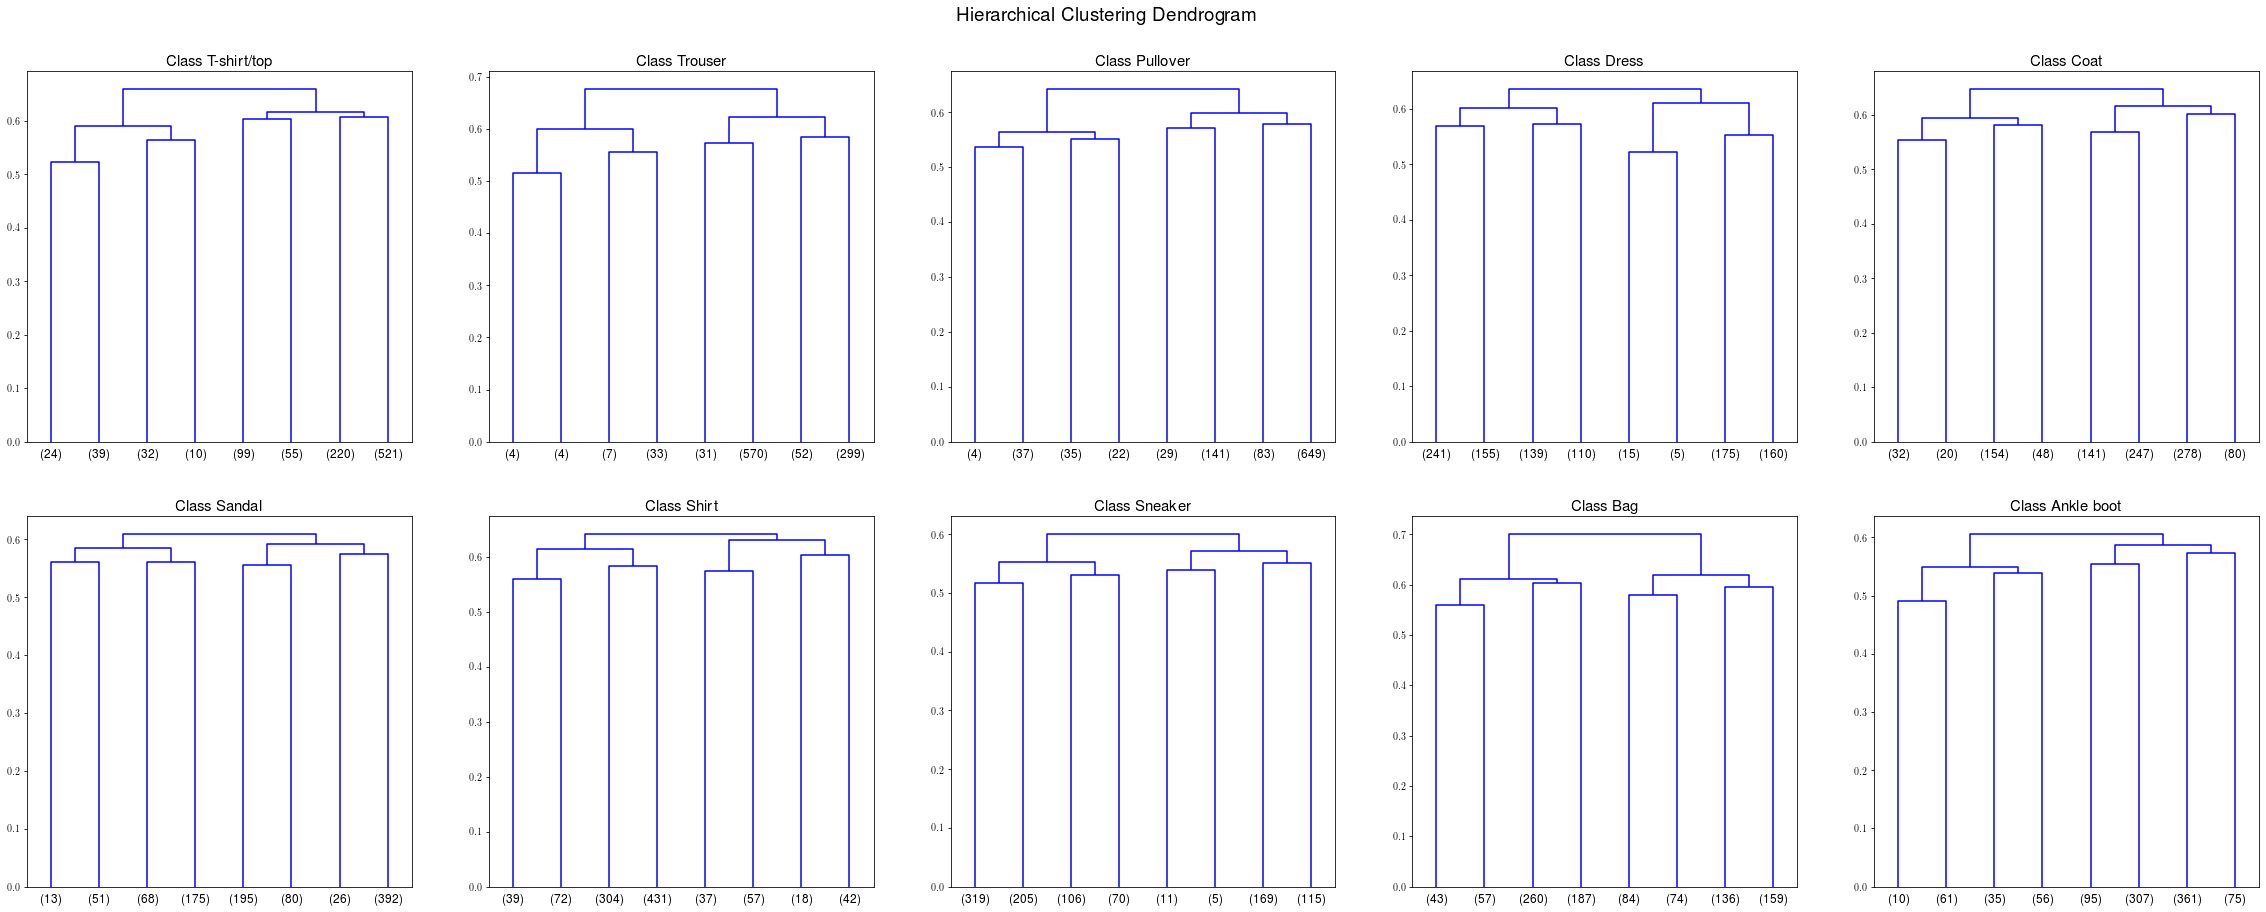

In [54]:
#@title Create the clusters for each class
# Definition of the distance threshold (parameter for the Agglomerative clustering) for each class
# We try different distance thresholds and select the one whose silhouette score is the greatest in the defined range
print('Selecting the parameter "distance_threshold" of Agglomerative Clustering by optimizing the Silhouette score\n')
distance_threshold = []
range_of_dist_thrs = np.linspace(0.52,0.90,39)
silhouette_scores_per_class = []
clustering_labels_per_class = np.zeros((NUM_CLASSES,ssim_distance_matrix_per_class.shape[1]))
for class_index in tqdm(range(NUM_CLASSES)):
  silh_scores_one_class = []
  for dist in range_of_dist_thrs:
    # For each distance threshold, we compute the clustering and the silhouette score
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=dist)
    cluster_model.fit(ssim_distance_matrix_per_class[class_index])
    clustering_labels_per_class[class_index] = cluster_model.labels_
    try:
      silh_scores_one_class.append(silhouette_score(ssim_distance_matrix_per_class[class_index],clustering_labels_per_class[class_index],metric='precomputed'))
    except ValueError:
      silh_scores_one_class.append(0)    
  silhouette_scores_per_class.append(silh_scores_one_class)
  '''
  for i,score in enumerate(silh_scores[::-1]):
    if i != 0:
      if score < previous_score:
        # We keep the index of the number just before the slope descends (plots below).
        distance_threshold.append(range_of_dist_thrs[len(silh_scores)-(i)])
        break
    previous_score = score
  '''
  positions = []
  max_score = max(silh_scores_one_class)
  for index, score in enumerate(silh_scores_one_class[::-1]):
    if score == max_score:
      positions.append(index)
  # We select the max silhouette score closer to distance_threshold = 0  
  distance_threshold.append(range_of_dist_thrs[len(range_of_dist_thrs)-positions[-1]-1])

print('')
# Plot to see the silhouette scores
plt.subplots(2,5,figsize=(25,10))
for class_index,position in enumerate(range(1,11)):
  plt.subplot(2,5,position).plot(range_of_dist_thrs,silhouette_scores_per_class[class_index],color='red')
  plt.title(CLASS_NAMES[class_index])
plt.savefig('silhouetteScores.pdf')
plt.show()


# Function that creates de clusters of each class
# Initialization of the array containing the labels of the labels for each image in each class
clustering_labels_per_class = np.zeros((NUM_CLASSES,ssim_distance_matrix_per_class.shape[1]))
# plot the top three levels of the dendrogram
w = 40
h = 15
fig,ax = plt.subplots(2,5,figsize=(w,h))
fig.suptitle('Hierarchical Clustering Dendrogram',fontsize = h + w*0.1,y=0.94)
for class_index in range(NUM_CLASSES):
  if isinstance(distance_threshold,list):
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=distance_threshold[class_index])
  else:
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=distance_threshold)
  cluster_model.fit(ssim_distance_matrix_per_class[class_index])
  clustering_labels_per_class[class_index] = cluster_model.labels_
  if class_index < 5:
    i = 0
    j = class_index
  else:
    i = 1
    j = class_index - 5
  plot_dendrogram(cluster_model, truncate_mode='level', p=2, ax=ax[i,j])
  ax[i,j].set_title('Class {}'.format(CLASS_NAMES[class_index]),fontsize = h)
  #ax[i,j].set_xlabel("Number of points in node",fontsize=h)
plt.savefig('DendrogramPerClass.pdf')
fig.show()
print('-'*100,'\n')
for class_index in range(NUM_CLASSES):
  a = clustering_labels_per_class[class_index]
  unique, counts = np.unique(a, return_counts=True)
  print('Class',CLASS_NAMES[class_index].ljust(15),'\t',dict(zip(unique, counts)))
  print('-'*75)
print('\n'+'-'*100)

## Creation of the clusters mean/medians

In [63]:
#@title Select the approach
STYLE = {'description_width': 'initial'}
WIDTH = '500px'
mean_or_median = widgets.Combobox(placeholder='Choose mean or median',
        options=['Mean', 'Median'],
        description='Average mode:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
all_or_percentage = widgets.Combobox(placeholder='Choose all heatmaps or a percentaje of closest ones',
        options=['All', 'Percentage'],
        description='Average computation:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
button_approach = widgets.Button(
    description='Push the button to confirm',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width=WIDTH),
    style=STYLE
)
# HTML text
text_percentage = 'Select or enter the percentage value (in the paper 10% is used):'
instructions_percentage = ipw.widgets.HTML(text_percentage)
percentage = widgets.IntSlider(placeholder='Choose the percetage:',
        value=10,
        min=10,
        max=100,
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
button_percentage = widgets.Button(
    description='Push the button to confirm',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width=WIDTH),
    style=STYLE
)
def on_button_clicked_approach_definition(_):
  global average_heatmaps_per_class_and_cluster
  global AVG_MODE
  AVG_MODE = mean_or_median.value
  button_approach.button_style = 'success'
  if all_or_percentage.value == 'Percentage':
    button_approach.description = 'Success!'
    instructions_percentage.layout.visibility = 'visible'
    button_percentage.layout.visibility = 'visible'
    percentage.layout.visibility = 'visible'
  else:
    global PERCENTAGE_THRESHOLD
    button_approach.description = 'Options confirmed!'
    instructions_percentage.layout.display = 'none'
    button_percentage.layout.display = 'none'
    percentage.layout.display = 'none'
    PERCENTAGE_THRESHOLD = None
    # Create the average heatmaps
    file_name_average_heatmaps = f'average_heatmaps_per_class_and_cluster_{DATASET_NAME}_{MODEL_NAME}_{load_or_train.value}_seed{SEED}_{AVG_MODE}_{all_or_percentage.value}.pkl'
    path_heatmaps_average_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_average_heatmaps)
    # Checks if it exists
    if os.path.isfile(path_heatmaps_average_heatmaps):
      print('File exist, it will be loaded')
      with open(path_heatmaps_average_heatmaps, "rb") as f:
        average_heatmaps_per_class_and_cluster = pickle.load(f)
    else:
      average_heatmaps_per_class_and_cluster = []
      print('Computing the average:')
      for class_index in tqdm(range(NUM_CLASSES)):
        average_heatmaps_per_class_and_cluster.append(compute_average_heatmaps_per_cluster(clustering_labels_per_class[class_index],heatmaps_train_per_class[class_index], ssim_distance_matrix_per_class[class_index], avg_mode=AVG_MODE,thr=PERCENTAGE_THRESHOLD))
      with open(path_heatmaps_average_heatmaps, "wb") as f:
        pickle.dump(average_heatmaps_per_class_and_cluster, f)


def on_button_clicked_percentage_definition(_):
  global PERCENTAGE_THRESHOLD
  global average_heatmaps_per_class_and_cluster
  button_percentage.button_style = 'success'
  PERCENTAGE_THRESHOLD = percentage.value*0.01
  button_percentage.description = 'Percentage confirmed!'
  # Create the average heatmaps
  file_name_average_heatmaps = f'average_heatmaps_per_class_and_cluster_{DATASET_NAME}_{MODEL_NAME}_{load_or_train.value}_seed{SEED}_{AVG_MODE}_{all_or_percentage.value}_{PERCENTAGE_THRESHOLD}.pkl'
  path_heatmaps_average_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_average_heatmaps)
  # Checks if it exists
  if os.path.isfile(path_heatmaps_average_heatmaps):
    print('File exist, it will be loaded')
    with open(path_heatmaps_average_heatmaps, "rb") as f:
      average_heatmaps_per_class_and_cluster = pickle.load(f)
  else:
    average_heatmaps_per_class_and_cluster = []
    print('Computing the average:')
    all = []
    perc = []
    for class_index in tqdm(range(NUM_CLASSES)):
      average_heatmaps_per_class_and_cluster.append(compute_average_heatmaps_per_cluster(clustering_labels_per_class[class_index],heatmaps_train_per_class[class_index], ssim_distance_matrix_per_class[class_index], avg_mode=AVG_MODE,thr=PERCENTAGE_THRESHOLD))
    with open(path_heatmaps_average_heatmaps, "wb") as f:
      pickle.dump(average_heatmaps_per_class_and_cluster, f)


# Hide the percentage selection
instructions_percentage.layout.visibility = 'hidden'
percentage.layout.visibility = 'hidden'
button_percentage.layout.visibility = 'hidden'

button_approach.on_click(on_button_clicked_approach_definition)
button_percentage.on_click(on_button_clicked_percentage_definition)
display(mean_or_median)
display(all_or_percentage)
display(button_approach)
print('')
display(instructions_percentage)
display(percentage)
display(button_percentage)
print('')

Combobox(value='', description='Average mode:', ensure_option=True, layout=Layout(width='500px'), options=('Me…

Combobox(value='', description='Average computation:', ensure_option=True, layout=Layout(width='500px'), optio…

Button(button_style='info', description='Push the button to confirm', icon='check', layout=Layout(width='500px…

HTML(value='Select or enter the percentage value (in the paper 10% is used):', layout=Layout(visibility='hidde…

IntSlider(value=10, layout=Layout(visibility='hidden', width='500px'), min=10, style=SliderStyle(description_w…

Button(button_style='info', description='Push the button to confirm', icon='check', layout=Layout(visibility='…


File exist, it will be loaded


In [ ]:
average_heatmaps_per_class_and_cluster[5].shape

(3, 24, 24)

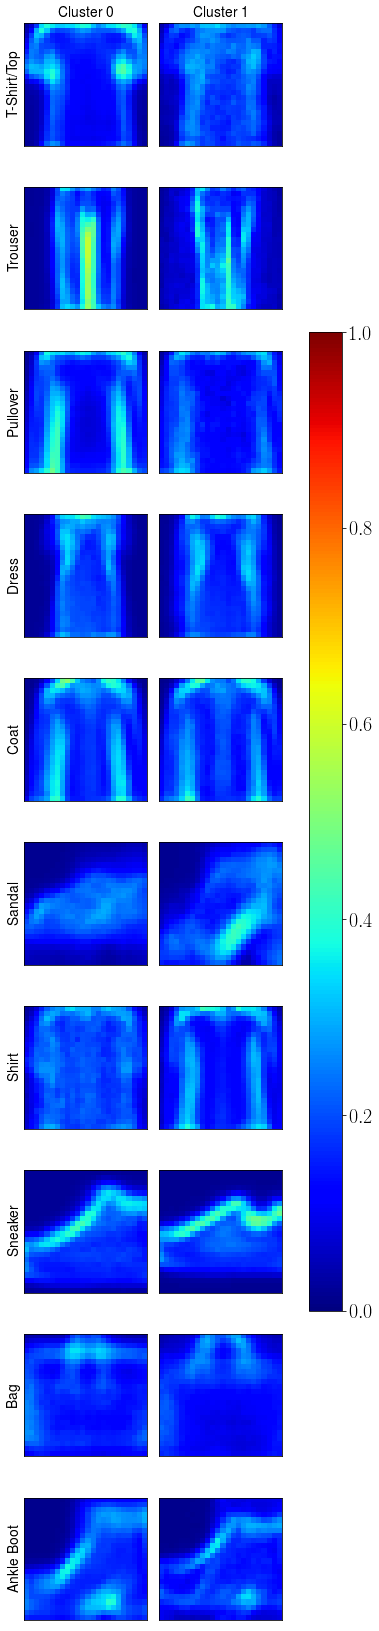

In [64]:
#@title Plot the average heatmaps of each cluster of each class
# Plot de los heatmaps de cada clase
superimposed = False
# Calculate the number of total columns
max_cols = []
for htmap_prom_cluster in average_heatmaps_per_class_and_cluster:
  max_cols.append(len(htmap_prom_cluster))
max_cols = max(max_cols)
FONTSIZE = 10+2*max_cols 
# Plots
fig, ax = plt.subplots(nrows=NUM_CLASSES,ncols=max_cols, figsize = (3*max_cols,3*NUM_CLASSES),sharex=True,sharey=True,constrained_layout=False,tight_layout=False)
for class_index in range(NUM_CLASSES):
  for cluster in range(len(average_heatmaps_per_class_and_cluster[class_index])):
    if superimposed == False:
      im = ax[class_index,cluster].imshow(average_heatmaps_per_class_and_cluster[class_index][cluster],cmap='jet',vmin=0,vmax=1)
    elif superimposed == True:
      one_image_of_class_index = search_index_of_class(class_index,1,train_labels_shuffled)[0]
      ax[class_index,cluster].imshow(train_images_shuffled[one_image_of_class_index,:,:,0])
       # Save AxesImage for plotting the colorbar
      im = ax[class_index,cluster].imshow(resize(average_heatmaps_per_class_and_cluster[class_index][cluster], (train_images_shuffled.shape[1:3])),alpha = 0.6,cmap='jet',vmin=0,vmax=1)

    if class_index == 0:
      ax[class_index,cluster].set_title('Cluster {}'.format(cluster),fontsize=FONTSIZE)
      ax[class_index,cluster].set_xticks([])
      ax[class_index,cluster].set_yticks([])
    # Comment the line in the if to not plot the class names
    if cluster == 0:
      ax[class_index,cluster].set_ylabel(CLASS_NAMES[class_index].title(),rotation = 90, fontsize=FONTSIZE)
      pass

  if len(average_heatmaps_per_class_and_cluster[class_index]) != max_cols:
    for empty_ax_index in range(len(average_heatmaps_per_class_and_cluster[class_index]),max_cols):
      ax[class_index][empty_ax_index].imshow(np.zeros(np.shape(average_heatmaps_per_class_and_cluster[class_index][cluster])),vmin=0,vmax=1)
      ax[class_index,empty_ax_index].plot([0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],[len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1,0],c='w',lw=2)
      ax[class_index,empty_ax_index].plot([0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],[0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],c='w',lw=2)
      if class_index == 0:
        ax[class_index,empty_ax_index].set_title('Cluster {}'.format(empty_ax_index),fontsize=FONTSIZE)
        ax[class_index,empty_ax_index].set_xticks([])
        ax[class_index,empty_ax_index].set_yticks([])

plt.subplots_adjust(wspace=0.1, hspace=0.05)
cbar = fig.colorbar(im, ax=ax, shrink=0.6, pad=0.08, aspect=30)
cbar.ax.tick_params(labelsize=12+max_cols*4)

plt.savefig('./Heatmaps_per_class_and_cluster_{}.pdf'.format(AVG_MODE),dpi=40,bbox_inches='tight')
plt.savefig('./Heatmaps_per_class_and_cluster_{}.png'.format(AVG_MODE),dpi=250,bbox_inches='tight')
#plt.savefig('./Crop.pdf'.format(modo_heatmaps),dpi=40,bbox_inches=Bbox([[0, 3], [9, 27]]))

# Inference

## Train, Test and OD dataset heatmap creation

Train and Test heatmaps creation

In [65]:
#@title Generate the heatmaps of test and OD datasets

'''
if len(train_images_shuffled) > 60000:
  train_images_shuffled = train_images_shuffled[:60000]
train_predictions = np.argmax(model.predict(train_images_shuffled[-10000:]),axis=1)
train_heatmaps = generate_heatmaps(train_images_shuffled[-10000:],train_predictions)
'''
# Test heatmaps and predictions
test_predictions = np.argmax(model.predict(test_images),axis=1)
file_name_test_heatmaps = f'test_heatmaps_{DATASET_NAME}_{MODEL_NAME}_trainedOn{DATASET_NAME}.npy'
path_test_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_test_heatmaps)
if os.path.isfile(path_test_heatmaps):
  print(f'Test heatmaps for {selectedDataset.value} exist, they will be loaded')
  test_heatmaps = np.load(path_test_heatmaps)
else:
  print('Generating the test heatmaps:')
  if len(test_images) > 10000:
    test_images = test_images[:10000]
  test_heatmaps = generate_heatmaps(test_images,test_predictions)
  np.save(path_test_heatmaps, test_heatmaps, allow_pickle=False)

# Load the selected OD dataset
NUM_CLASSES_OD = 10
OD_DATASET_NAME = OD_dataset.value
od_test_images, _ = load_test_sample_of_dataset(OD_DATASET_NAME) 
# OoD heatmaps and predictions
od_predictions = np.argmax(model.predict(od_test_images),axis=1)
file_name_od_test_heatmaps = f'od_test_heatmaps_{OD_DATASET_NAME}_{MODEL_NAME}_trainedOn{DATASET_NAME}.npy'
path_od_test_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_od_test_heatmaps)
if os.path.isfile(path_od_test_heatmaps):
  print(f'OoD heatmaps for {OD_DATASET_NAME} exist, they will be loaded')
  od_heatmaps = np.load(path_od_test_heatmaps)
else:
  print(f'Generating the Out-of-Distribution heatmaps of {OD_DATASET_NAME} dataset:')
  if len(od_test_images) > 10000:
    od_test_images = od_test_images[:10000]
  od_heatmaps = generate_heatmaps(od_test_images,od_predictions)
  np.save(path_od_test_heatmaps, od_heatmaps, allow_pickle=False)

Test heatmaps for Fashion_MNIST exist, they will be loaded
OoD heatmaps for MNIST exist, they will be loaded


In [ ]:
#@title Click to generate rotated or translated heatmaps of the OD dataset selected
STYLE = {'description_width': 'initial'}
WIDTH = '500px'
TRANSFORMATION_OPTIONS = ['Rotation', 'Translation']
# Widgets
widget_dataset_rot_trans = widgets.Combobox(placeholder='Choose the dataset',
        options=datasetOptions,
        description='Dataset:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
)
widget_rotation_or_translation = widgets.Combobox(placeholder='Choose one transformation',
        options=TRANSFORMATION_OPTIONS,
        description='Transformation:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
)
button_dataset_and_transf = widgets.Button(
    description='Push the button to confirm',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width=WIDTH),
    style=STYLE
)
widget_slider_rotation = widgets.IntSlider(placeholder='Choose the rotation angle (+ is clockwise):',
        value=0,
        min=0,
        max=360,
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
)
widget_slider_translation_h = widgets.IntSlider(placeholder='Choose the horizontal translation in pixels:',
        value=0,
        min=0,
        max=28,
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
widget_slider_translation_v = widgets.IntSlider(placeholder='Choose the vertical translation in pixels:',
        value=0,
        min=0,
        max=28,
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
)
button_tranf_parameters = widgets.Button(
    description='Push the button to confirm the transformation parameters',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width=WIDTH),
    style=STYLE
)
# HTML text
text_transf = 'Select or enter the transformation parameters:'
instructions_transf = ipw.widgets.HTML(text_transf)
def on_button_clicked_dataset_and_transf(_):
  global TRANSF_DATASET
  global TRANSFORMATION
  TRANSF_DATASET = widget_dataset_rot_trans.value
  TRANSFORMATION = widget_rotation_or_translation.value
  button_dataset_and_transf.button_style = 'success'
  button_dataset_and_transf.description = 'Options confirmed!'
  if TRANSFORMATION == TRANSFORMATION_OPTIONS[0]:
    widget_slider_translation_h.layout.display = 'none'
    widget_slider_translation_v.layout.display = 'none'
    instructions_transf.text = 'Select the rotation angle'
    display(instructions_transf)
    instructions_transf.layout.visibility = 'visible'
    widget_slider_rotation.layout.visibility = 'visible'
    button_tranf_parameters.layout.visibility = 'visible'
  else:
    widget_slider_rotation.layout.display = 'none'
    instructions_transf.text = 'Select the horizontal and vertical translation'
    instructions_transf.layout.visibility = 'visible'
    widget_slider_translation_h.layout.visibility = 'visible'
    widget_slider_translation_v.layout.visibility = 'visible'
    button_tranf_parameters.layout.visibility = 'visible'

def on_button_clicked_transformation(_):
  global ANGLE
  global H_TRANS
  global V_TRANS
  global od_heatmaps
  global od_test_images
  global od_test_labels
  global od_predictions
  button_tranf_parameters.button_style = 'success'
  button_percentage.description = 'Transformation confirmed!'
  # Apply the transformation
  if TRANSFORMATION == TRANSFORMATION_OPTIONS[0]:
    # Define values
    ANGLE = widget_slider_rotation.value
    H_TRANS = None
    V_TRANS = None
    # Generate or load the heatmaps
    file_name_od_heatmaps = f'od_test_heatmaps_{TRANSF_DATASET}_{MODEL_NAME}_trainedFor{DATASET_NAME}_{TRANSFORMATION}_{ANGLE}.npy'
    path_od_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_od_heatmaps)
    # Check if they exist
    if os.path.isfile(path_od_heatmaps):
      print(f'OoD heatmaps for {TRANSF_DATASET} for transformation = {TRANSFORMATION} with angle = {ANGLE} exist, they will be loaded')
      od_heatmaps = np.load(path_od_heatmaps)
    else:
      print(f'Generating the Out-of-Distribution heatmaps of {TRANSF_DATASET} dataset for transformation = {TRANSFORMATION} with angle = {ANGLE}:')
      od_test_images, od_test_labels = load_test_sample_of_dataset(TRANSF_DATASET)
      od_test_images = rotate_images(od_test_images, ANGLE)
      model.evaluate(od_test_images, od_test_labels)
      od_predictions = np.argmax(model.predict(od_test_images),axis=1)
      if len(od_test_images) > 10000:
        od_test_images = od_test_images[:10000]
        od_test_labels = od_test_labels[:10000]
      od_heatmaps = generate_heatmaps(od_test_images,od_predictions)
      np.save(path_od_heatmaps, od_heatmaps, allow_pickle=False)
      print(f'Heatmaps of {DATASET_NAME} rotated {ANGLE} created succesfully!')

  if TRANSFORMATION == TRANSFORMATION_OPTIONS[1]:
    ANGLE = None
    H_TRANS = widget_slider_translation_h.value
    V_TRANS = widget_slider_translation_v.value
    file_name_od_heatmaps = f'od_test_heatmaps_{TRANSF_DATASET}_{MODEL_NAME}_trainedFor{DATASET_NAME}_{TRANSFORMATION}_({H_TRANS},{V_TRANS}).npy'
    path_od_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_od_heatmaps)
    # Check if they exist
    if os.path.isfile(path_od_heatmaps):
      print(f'OoD heatmaps for {TRANSF_DATASET} for transformation = {TRANSFORMATION} with translation = ({H_TRANS},{V_TRANS}) exist, they will be loaded')
      od_heatmaps = np.load(path_od_heatmaps)
    else:
      print(f'Generating the Out-of-Distribution heatmaps of {TRANSF_DATASET} dataset for transformation = {TRANSFORMATION} with translation = ({H_TRANS},{V_TRANS}):')
      od_test_images, od_test_labels = load_test_sample_of_dataset(TRANSF_DATASET)
      od_test_images = translate_images(od_test_images, H_TRANS, V_TRANS)
      od_predictions = np.argmax(model.predict(od_test_images),axis=1)
      model.evaluate(od_test_images, od_test_labels)
      if len(od_test_images) > 10000:
        od_test_images = od_test_images[:10000]
        od_test_labels = od_test_labels[:10000]
      od_heatmaps = generate_heatmaps(od_test_images,od_predictions)
      np.save(path_od_heatmaps, od_heatmaps, allow_pickle=False)
      print(f'Heatmaps of {DATASET_NAME} translataed ({H_TRANS},{V_TRANS}) created succesfully!')

# Hide the percentage selection
instructions_transf.layout.visibility = 'hidden'
widget_slider_rotation.layout.visibility = 'hidden'
widget_slider_translation_h.layout.visibility = 'hidden'
widget_slider_translation_v.layout.visibility = 'hidden'
button_tranf_parameters.layout.visibility = 'hidden'

button_dataset_and_transf.on_click(on_button_clicked_dataset_and_transf)
button_tranf_parameters.on_click(on_button_clicked_transformation)
display(widget_dataset_rot_trans)
display(widget_rotation_or_translation)
display(button_dataset_and_transf)
print('')
display(instructions_transf)
display(widget_slider_rotation)
display(widget_slider_translation_h)
display(widget_slider_translation_v)
display(button_tranf_parameters)
print('')

Combobox(value='', description='Dataset:', ensure_option=True, layout=Layout(width='500px'), options=('MNIST',…

Combobox(value='', description='Transformation:', ensure_option=True, layout=Layout(width='500px'), options=('…

Button(button_style='info', description='Push the button to confirm', icon='check', layout=Layout(width='500px…

HTML(value='Select or enter the transformation parameters:', layout=Layout(visibility='hidden'))

IntSlider(value=0, layout=Layout(visibility='hidden', width='500px'), max=360, style=SliderStyle(description_w…

IntSlider(value=0, layout=Layout(visibility='hidden', width='500px'), max=28, style=SliderStyle(description_wi…

IntSlider(value=0, layout=Layout(visibility='hidden', width='500px'), max=28, style=SliderStyle(description_wi…

Button(button_style='info', description='Push the button to confirm the transformation parameters', icon='chec…

In [ ]:
#@title Click Play to select the Image comparing method
selectMode = widgets.Combobox(
    placeholder='Choose the Image comparing method',
    options=['SSIM','CW-SSIM'],
    description='Image comparing methodS:',
    ensure_option=True,
    disabled=False,
    value='SSIM',
    layout = ipw.Layout(width='325px')
)
selectMode

Combobox(value='SSIM', description='Image comparing methodS:', ensure_option=True, layout=Layout(width='325px'…

## Compute SSIM of test and OoD

In [66]:
#@title Select the comparison approach
STYLE = {'description_width': 'initial'}
WIDTH = '500px'
comparison_options = ['Compare to centroids', 'Compare to each heatmaps of the closest cluster']
widget_comparison_approach = widgets.Combobox(placeholder='Choose one',
        options=comparison_options,
        description='Comparison against:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
button_comparison_approach = widgets.Button(
    description='Push the button to run the comparison',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width=WIDTH),
    style=STYLE
)
# HTML text
text_comparison_approach = 'Select the comparison method approach:'
instructions_comparison_approach = ipw.widgets.HTML(text_comparison_approach)
def on_button_clicked_comparison_approach(_):
  global ssim_per_image_test
  global ssim_per_image_od
  global comparison_approach
  button_comparison_approach.button_style = 'success'
  button_comparison_approach.description = 'Success!'
  if widget_comparison_approach.value == comparison_options[0]:
    print('Comparison against centroids is being performed:')
    comparison_approach = 'Centroids'
    # Test
    ssim_per_image_test = compute_ssim_against_cluster_averages(test_heatmaps,test_predictions,average_heatmaps_per_class_and_cluster)
    # OD
    ssim_per_image_od = compute_ssim_against_cluster_averages(od_heatmaps,od_predictions,average_heatmaps_per_class_and_cluster)
  else:
    # Test
    comparison_approach = 'ClosestClusterAll'
    file_name_comparison_approach_test = f'ssim_all_heatmaps_of_closest_cluster_{DATASET_NAME}_vs_{DATASET_NAME}_{MODEL_NAME}_{AVG_MODE}.npy'
    path_comparison_approach_test = os.path.join(OBJS_DIR_NAME, file_name_comparison_approach_test)
    if os.path.isfile(path_comparison_approach_test):
      print(f'SSIM values of {DATASET_NAME}_vs_{DATASET_NAME}_{MODEL_NAME} exist, they will be loaded')
      ssim_per_image_test = np.load(path_comparison_approach_test)
    else:
      print(f'Comparison of {DATASET_NAME} against all heatmaps of the closest cluster of {DATASET_NAME} is being performed:')
      ssim_per_image_test = compute_ssim_against_all_heatmps_of_closest_cluster(test_heatmaps,test_predictions,average_heatmaps_per_class_and_cluster,heatmaps_train_per_class,clustering_labels_per_class)
      np.save(path_comparison_approach_test, ssim_per_image_test, allow_pickle=False)
    # OD
    print('')
    file_name_comparison_approach_od = f'ssim_all_heatmaps_of_closest_cluster {DATASET_NAME} vs {OD_DATASET_NAME}_{MODEL_NAME}_{AVG_MODE}.npy'
    path_comparison_approach_od = os.path.join(OBJS_DIR_NAME, file_name_comparison_approach_od)
    if os.path.isfile(path_comparison_approach_od):
      print(f'SSIM values of {OD_DATASET_NAME}_{MODEL_NAME} exist, they will be loaded')
      ssim_per_image_od = np.load(path_comparison_approach_od)
    else:
      print(f'Comparison of {OD_DATASET_NAME} against all heatmaps of the closest cluster of {DATASET_NAME} is being performed:')
      ssim_per_image_od = compute_ssim_against_all_heatmps_of_closest_cluster(od_heatmaps,od_predictions,average_heatmaps_per_class_and_cluster,heatmaps_train_per_class,clustering_labels_per_class)
      np.save(path_comparison_approach_od, ssim_per_image_od, allow_pickle=False)

button_comparison_approach.on_click(on_button_clicked_comparison_approach)
display(instructions_comparison_approach)
display(widget_comparison_approach)
display(button_comparison_approach)

HTML(value='Select the comparison method approach:')

Combobox(value='', description='Comparison against:', ensure_option=True, layout=Layout(width='500px'), option…

Button(button_style='info', description='Push the button to run the comparison', icon='check', layout=Layout(w…

Comparison against centroids is being performed:


10000it [00:04, 2329.27it/s]
10000it [00:04, 2343.34it/s]


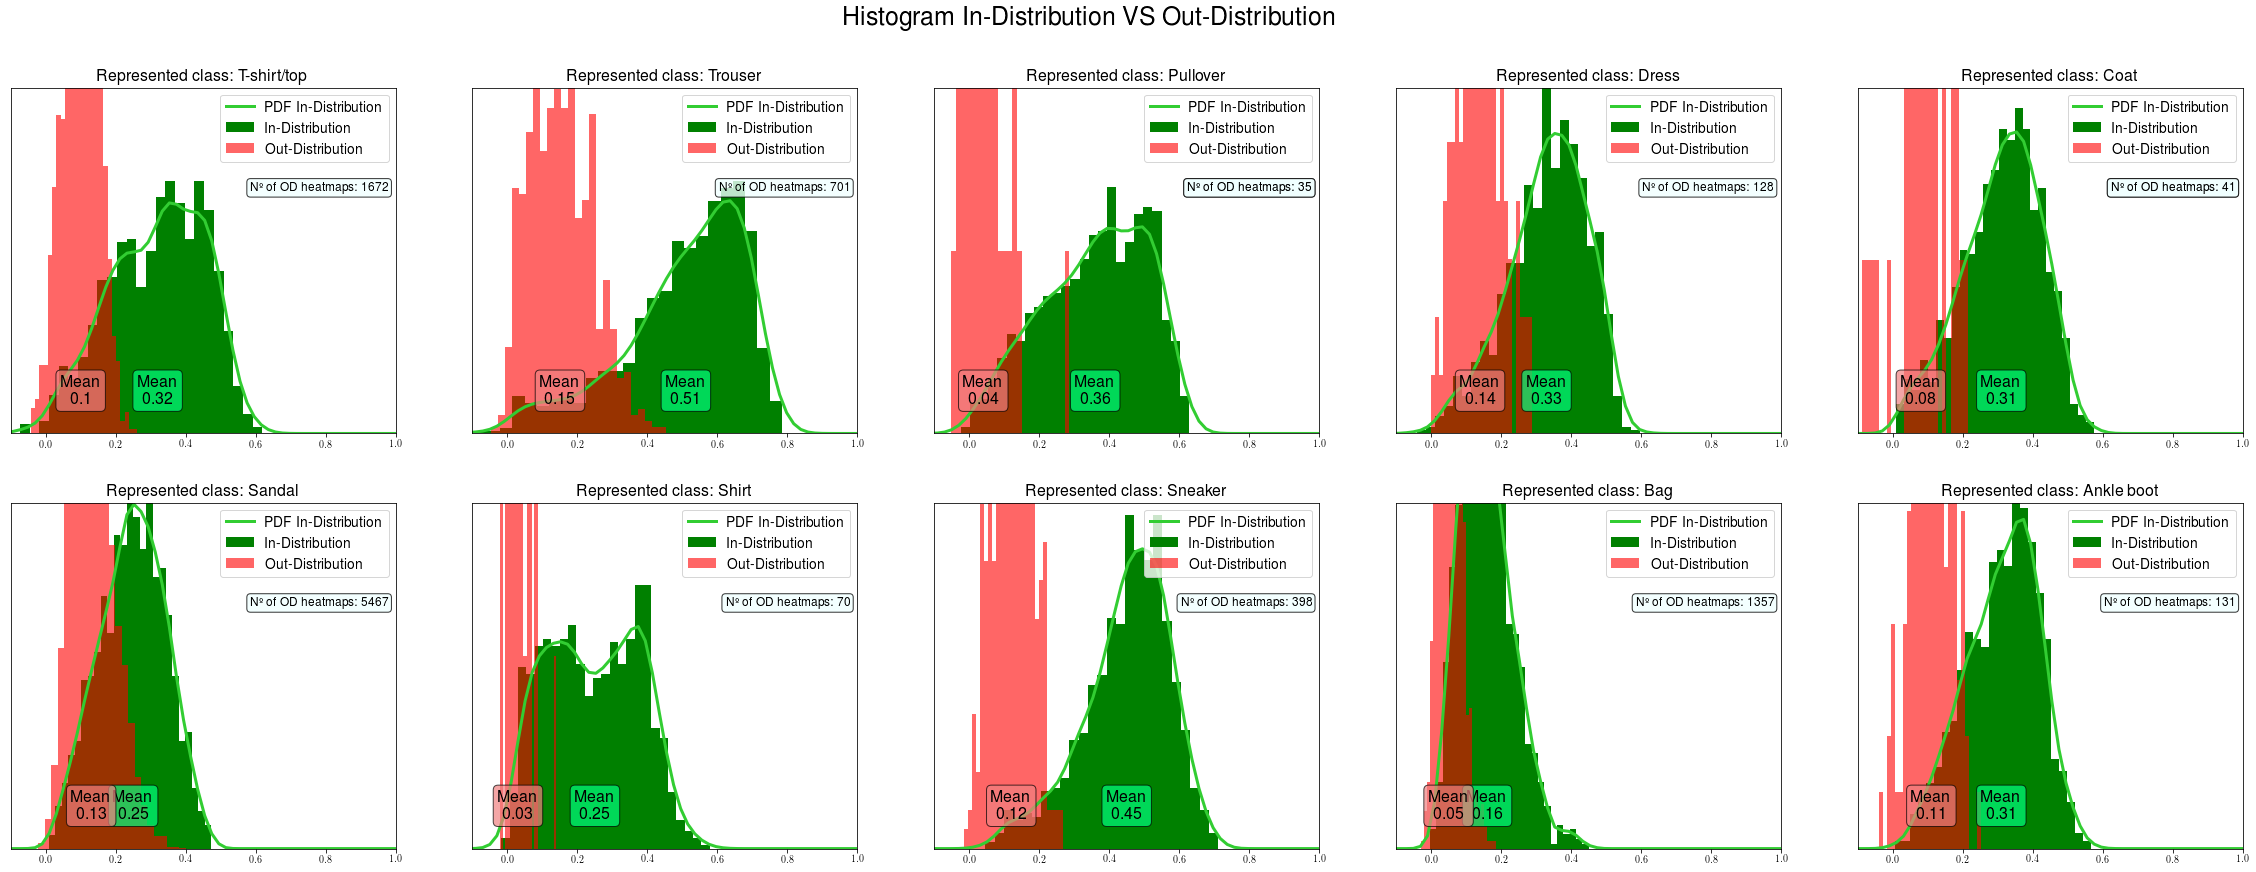

In [67]:
#@title Histogram of SSIM values per class
# Funcion que representa el % de instancias que SI activan el threshold tanto CON como SIN deriva 
# Inicializar los rangos para los que se calcula la CDF
x = np.linspace(-1,1,100)
y = np.linspace(1,-1,100)

# Propiedades de la caja donde va el texto
props               = dict(boxstyle='round', facecolor='azure', alpha=0.8)
meanBoxProps        = dict(boxstyle='round', facecolor='springgreen', alpha=0.7)
meanOutDistBoxProps = dict(boxstyle='round', facecolor='lightcoral', alpha=0.7)
# Creacion de figura
fig, ax = plt.subplots(2,5,sharey=True,figsize=(40,14))
plot_verde  = 'In-Distribution'   
plot_rojo   = 'Out-Distribution'
fig.suptitle('Histogram In-Distribution VS {}'.format(plot_rojo), fontsize=25,y=0.96)

for class_index in range(10):
  # The count of how many od images are classified as each class
  unique, od_counts = np.unique(od_predictions, return_counts=True)
  # KDE fitting
  kde_sci = stats.gaussian_kde(ssim_per_image_test[np.where(test_predictions==class_index)])
  cdf = []
  for i in x:
    cdf.append(kde_sci.integrate_box_1d(-1,i))
  # KDE fitting
  try:
    if od_counts[class_index] > 50:
      kde_sci_OOD = stats.gaussian_kde(ssim_per_image_od[np.where(od_predictions==class_index)])
      cdf_OOD = []
      for i in y:
        cdf_OOD.append(kde_sci_OOD.integrate_box_1d(i,1))
  except KeyError:
    raise NameError('Error')
    pass
  # Calculo del punto de cruce minimizando diferencia entre CDFs. La solucion nos da la posicion del punto de minima 
  # diferencia dentro del array, no el valor en si
  sol = minimize_scalar(cdf_difference,args=(kde_sci,kde_sci_OOD),method='bounded',bounds=(1,99),options={'xatol': 0.001,'maxiter': 100, 'disp': 0})
  # Punto de cruce es el valor del eje X en la posicion de la solucion 
  p_cruce = x[int(sol.x)]
  tpr_cruce = round(kde_sci.integrate_box_1d(p_cruce,1),3)
  fpr_cruce = round(1-kde_sci_OOD.integrate_box_1d(-1,p_cruce),3)
  
  # Definicion de i y j para plotear bien
  i=0
  j=class_index
  if class_index >= 5:
    i = 1
    j = class_index-5

  # Plots de KDE
  ax[i,j].set_xlim((-0.1,1))
  ax[i,j].set_ylim((0,4))
  ax[i,j].set_yticks([])
  ax[i,j].hist(ssim_per_image_test[np.where(test_predictions==class_index)], density=True,bins=25,color='green',label=plot_verde)
  ax[i,j].hist(ssim_per_image_od[np.where(od_predictions==class_index)], density=True,bins=25,color='red',alpha=0.6,label=plot_rojo)
  ax[i,j].plot(x, kde_sci.pdf(x), lw=3, label='PDF {}'.format(plot_verde), color='limegreen',zorder=1)
  #ax[i,j].plot(x, cdf, lw=3, label='CDF {}'.format(plot_verde), color='chartreuse',zorder=2)
  ax[i,j].set_title('Represented class: {}'.format(CLASS_NAMES[class_index]),fontsize=16)

  meanInDistPerClass = round(ssim_per_image_test[np.where(test_predictions==class_index)].mean(),2)
  ax[i,j].text(x=meanInDistPerClass,y=0.35,s='Mean\n'+str(meanInDistPerClass),fontsize=16,fontweight='medium',bbox=meanBoxProps,horizontalalignment='center',zorder=4)

  # Texto a representar
  altura_texto = 0.71
  textstr = 'Nº of OD heatmaps: {}'.format(od_counts[class_index])
  try:
    if od_counts[class_index] > 50:
      #ax[i,j].plot(y, cdf_OOD, lw=3, label='CDF {}'.format(plot_rojo), color='orangered',zorder=3)
      # Texto
      meandOutDistPerClass = round(ssim_per_image_od[np.where(od_predictions==class_index)].mean(),2)
      ax[i,j].text(x=meandOutDistPerClass,y=0.35,s='Mean\n'+str(meandOutDistPerClass),fontsize=16,fontweight='medium',bbox=meanOutDistBoxProps,horizontalalignment='center',zorder=4)
      ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
    else:
      try:
        meandOutDistPerClass = round(ssim_per_image_od[np.where(od_predictions==class_index)].mean(),2)
        ax[i,j].text(x=meandOutDistPerClass,y=0.35,s='Mean\n'+str(meandOutDistPerClass),fontsize=16,fontweight='medium',bbox=meanOutDistBoxProps,horizontalalignment='center',zorder=4)

        ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
      except:
        textstr = 'Nº inputs: 0'
      ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  except KeyError:
    textstr = 'Nº inputs: 0'
    ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  #ax[i,j].axvline(x=p_cruce, ymin=0, ymax=1,color='fuchsia',label='Threshold',linewidth=3,linestyle='--',zorder=5)
  ax[i,j].legend(fontsize=14, loc='upper right')

#fig.savefig('./Hist_{}_vs_{}'.format(plot_verde,plot_rojo),dpi=200)
fig.savefig('./Hist_{}_vs_{}.pdf'.format(plot_verde,plot_rojo))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


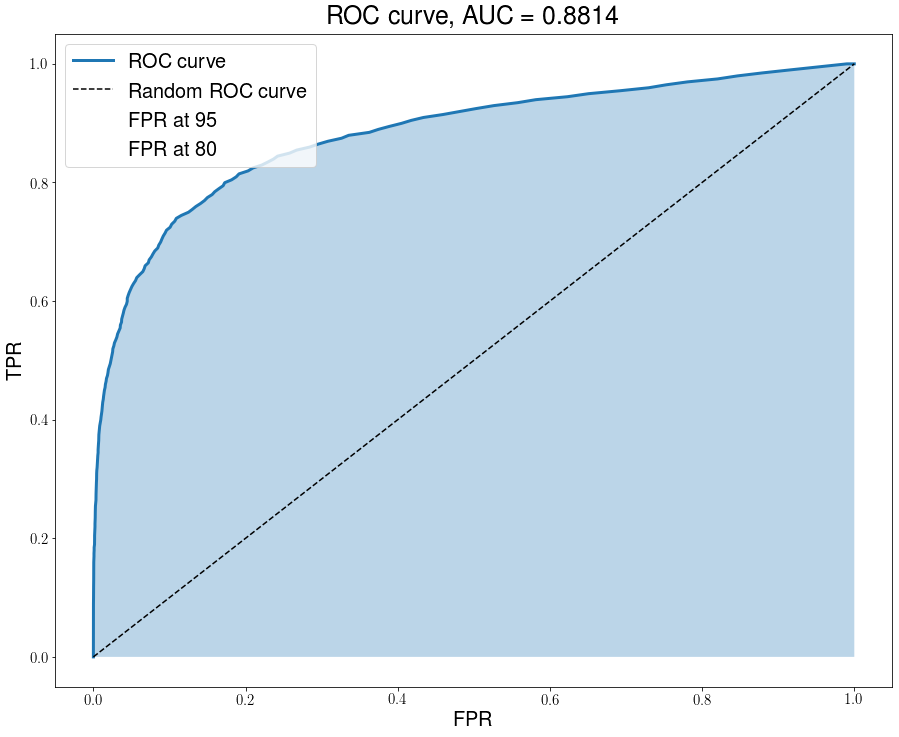

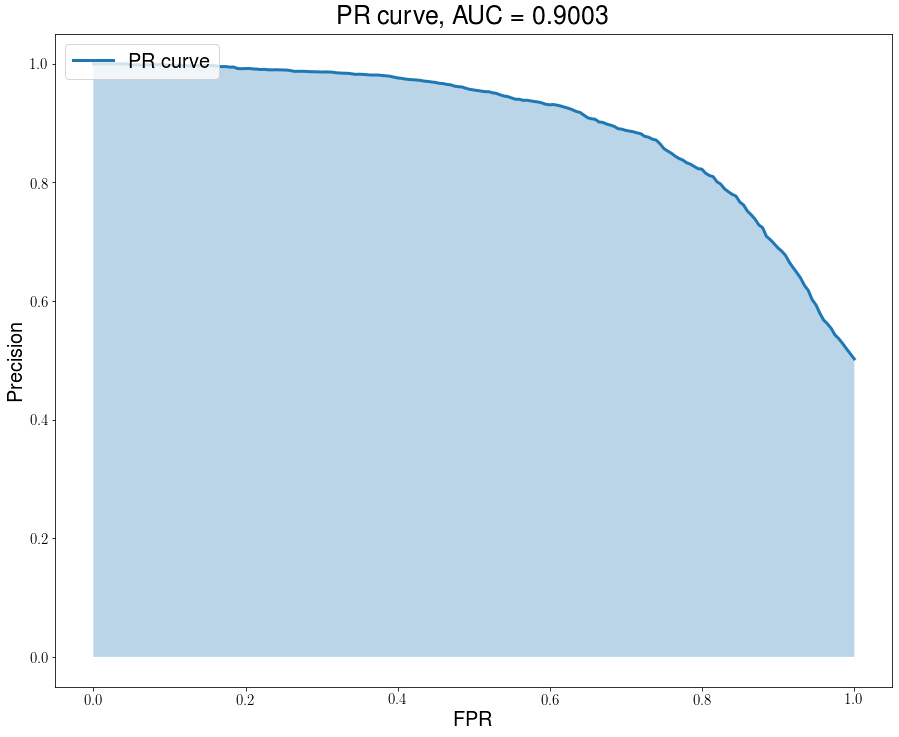

  ----------------------------------
| Results saved in results directory |
  ----------------------------------


In [68]:
#@title AUROC and AUPR
''' Using the Similarity (SSIM) '''
# Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
#ssim_per_class_per_image_train = [ssim_per_image_train[np.where(train_predictions == class_index)] for class_index in range(NUM_CLASSES)]
ssim_per_class_per_image_test = [ssim_per_image_test[np.where(test_predictions == class_index)] for class_index in range(NUM_CLASSES)]
ssim_per_class_per_image_od = [ssim_per_image_od[np.where(od_predictions == class_index)] for class_index in range(NUM_CLASSES)]
similarity_thresholds_test = similarity_thresholds_for_each_TPR(ssim_per_class_per_image_test)
# Conmputing precision, tpr and fpr
precision, tpr_values, fpr_values = compute_precision_tpr_fpr_for_test_and_OoD_similarity(ssim_per_class_per_image_test, ssim_per_class_per_image_od, similarity_thresholds_test)
# Appending that when FPR = 1 the TPR is also 1:
tpr_values_auroc = np.append(tpr_values,1)
fpr_values_auroc = np.append(fpr_values,1)

# Plots and results
!mkdir -p results
# ROC Curve
# AUC
auroc = round(np.trapz(tpr_values_auroc, fpr_values_auroc),4)
# Plot
plt.figure(figsize=(15,12))
roc = plt.plot(fpr_values_auroc,tpr_values_auroc,label='ROC curve',lw=3)
rnd_roc = plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'k--',label='Random ROC curve')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
plt.title('ROC curve, AUC = %.4f'%auroc,fontsize=25,pad=10)
plt.fill_between(fpr_values_auroc,tpr_values_auroc,alpha=0.3)
# Create empty plot with blank marker containing the extra label
fpr_95 = round(fpr_values_auroc[int(len(fpr_values_auroc)*0.95)],4)
fpr_80 = round(fpr_values_auroc[int(len(fpr_values_auroc)*0.80)],4)
plt.plot([], [], ' ', label=f'FPR at 95% TPR = {fpr_95*100:.2f}%')
plt.plot([], [], ' ', label=f'FPR at 80% TPR = {fpr_80*100:.2f}%')
#plt.text(0.60,0.975,'FPR at 95% TPR = {}%'.format(round(array_TPR_FPR_x_threshold[95,1]*100,2)),fontsize=20,bbox=dict(boxstyle="round",facecolor='white', alpha=0.5))
plt.legend(fontsize=20,loc='upper left')
plt.savefig(f'/content/AUROC_{DATASET_NAME}_vs_{OD_DATASET_NAME}.pdf')
plt.show()

# PR Curve
# AUC
aupr = round(np.trapz(precision, tpr_values),4)
# Plot
plt.figure(figsize=(15,12))
roc = plt.plot(tpr_values,precision,label='PR curve',lw=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('PR curve, AUC = %.4f'%aupr,fontsize=25,pad=10)
plt.fill_between(tpr_values,precision,alpha=0.3)
plt.legend(fontsize=20,loc='upper left')
plt.savefig(f'/content/AUPR_{DATASET_NAME}_vs_{OD_DATASET_NAME}.pdf')
plt.show()
df = pd.DataFrame(data=[[auroc,aupr,fpr_95,fpr_80]], columns=['AUROC','AUPR','FPR95','FPR80'])
if PERCENTAGE_THRESHOLD is not None:
  df.to_csv(f'results/Results_{DATASET_NAME}_vs_{OD_DATASET_NAME}_{comparison_approach}_{AVG_MODE}_percentage{PERCENTAGE_THRESHOLD}.csv',index=False, columns=['AUROC','AUPR','FPR95','FPR80'],sep=';',decimal=',')
else:
  df.to_csv(f'results/Results_{DATASET_NAME}_vs_{OD_DATASET_NAME}_{comparison_approach}_{AVG_MODE}_all.csv',index=False, columns=['AUROC','AUPR','FPR95','FPR80'],sep=';',decimal=',')
# Print info
print('  ----------------------------------')
print('| Results saved in results directory |')
print('  ----------------------------------')

# Figuras Paper


## Heatmap clusters

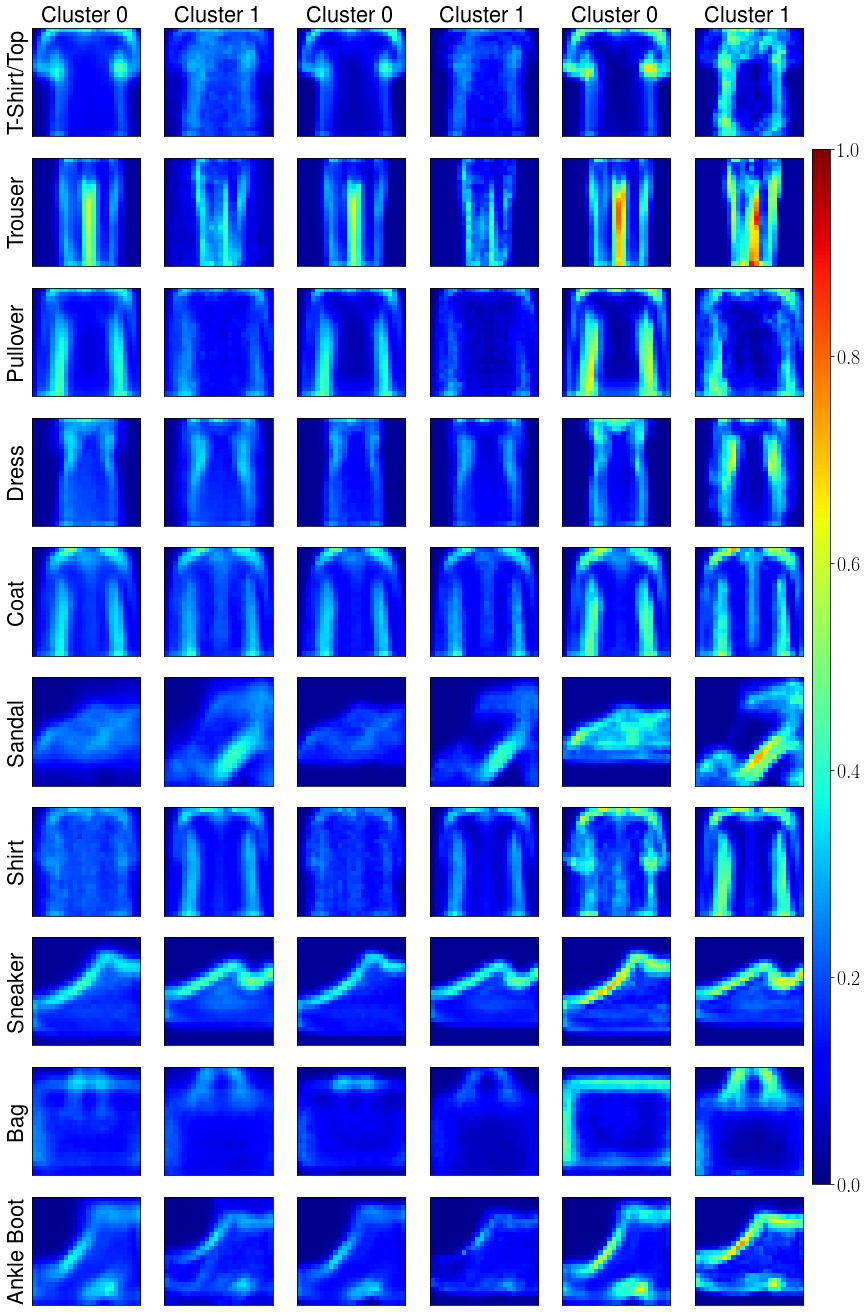

In [71]:
# Plot de los heatmaps de cada clase
superimposed = False
PERCENTAGE_THRESHOLD = 0.1
# Calculate the number of total columns
max_cols = []
for htmap_prom_cluster in average_heatmaps_per_class_and_cluster:
  max_cols.append(len(htmap_prom_cluster))
max_cols = max(max_cols)
FONTSIZE = 22
# Plots. figsize=(60,41) works
fig, ax = plt.subplots(nrows=NUM_CLASSES,ncols=max_cols*3, figsize = (16.5,23.5),sharex=True,sharey=True,constrained_layout=False,tight_layout=False)
for block in range(3):
  # Generate the average_heatmaps_per_class_and_cluster
  if block == 0:
    AVG_MODE = 'Mean'
    PERCENTAGE_THRESHOLD = None
  if block == 1: 
    AVG_MODE = 'Median'
    PERCENTAGE_THRESHOLD = None
  if block == 2:
    AVG_MODE = 'Mean'
    PERCENTAGE_THRESHOLD = 0.1
  average_heatmaps_per_class_and_cluster = []
  for class_index in range(NUM_CLASSES):
    average_heatmaps_per_class_and_cluster.append(compute_average_heatmaps_per_cluster(clustering_labels_per_class[class_index],heatmaps_train_per_class[class_index], ssim_distance_matrix_per_class[class_index], avg_mode=AVG_MODE,thr=PERCENTAGE_THRESHOLD))

  for class_index in range(NUM_CLASSES):
      for cluster in range(len(average_heatmaps_per_class_and_cluster[class_index])):
        if superimposed == False:
          im = ax[class_index,cluster+max_cols*block].imshow(average_heatmaps_per_class_and_cluster[class_index][cluster],cmap='jet',vmin=0,vmax=1)
        elif superimposed == True:
          one_image_of_class_index = search_index_of_class(class_index,1,train_labels_shuffled)[0]
          ax[class_index,cluster+max_cols*block].imshow(train_images_shuffled[one_image_of_class_index,:,:,0])
          # Save AxesImage for plotting the colorbar
          im = ax[class_index,cluster+max_cols*block].imshow(resize(average_heatmaps_per_class_and_cluster[class_index][cluster], (train_images_shuffled.shape[1:3])),alpha = 0.6,cmap='jet',vmin=0,vmax=1)

        if class_index == 0:
          ax[class_index,cluster+max_cols*block].set_title('Cluster {}'.format(cluster),fontsize=FONTSIZE)
          ax[class_index,cluster+max_cols*block].set_xticks([])
          ax[class_index,cluster+max_cols*block].set_yticks([])
        # Comment the line in the if to not plot the class names
        if cluster == 0 and block == 0:
          ax[class_index,cluster+max_cols*block].set_ylabel(CLASS_NAMES[class_index].title(),rotation = 90, fontsize=FONTSIZE)
          pass

      if len(average_heatmaps_per_class_and_cluster[class_index]) != max_cols:
        for empty_ax_index in range(len(average_heatmaps_per_class_and_cluster[class_index]),max_cols):
          ax[class_index][empty_ax_index+max_cols*block].imshow(np.zeros(np.shape(average_heatmaps_per_class_and_cluster[class_index][cluster])),vmin=0,vmax=1)
          ax[class_index,empty_ax_index+max_cols*block].plot([0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],[len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1,0],c='w',lw=2)
          ax[class_index,empty_ax_index+max_cols*block].plot([0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],[0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],c='w',lw=2)
          if class_index == 0:
            ax[class_index,empty_ax_index+max_cols*block].set_title('Cluster {}'.format(empty_ax_index),fontsize=FONTSIZE)
            ax[class_index,empty_ax_index+max_cols*block].set_xticks([])
            ax[class_index,empty_ax_index+max_cols*block].set_yticks([])

cbar = plt.colorbar(im, ax=ax.ravel().tolist(), aspect=60, shrink=0.81, fraction=0.15, pad=0.01)
cbar.ax.tick_params(labelsize=FONTSIZE-2)
plt.savefig('./Heatmaps_per_class_and_cluster_complete_plot.pdf',bbox_inches='tight')

4 Max clusters

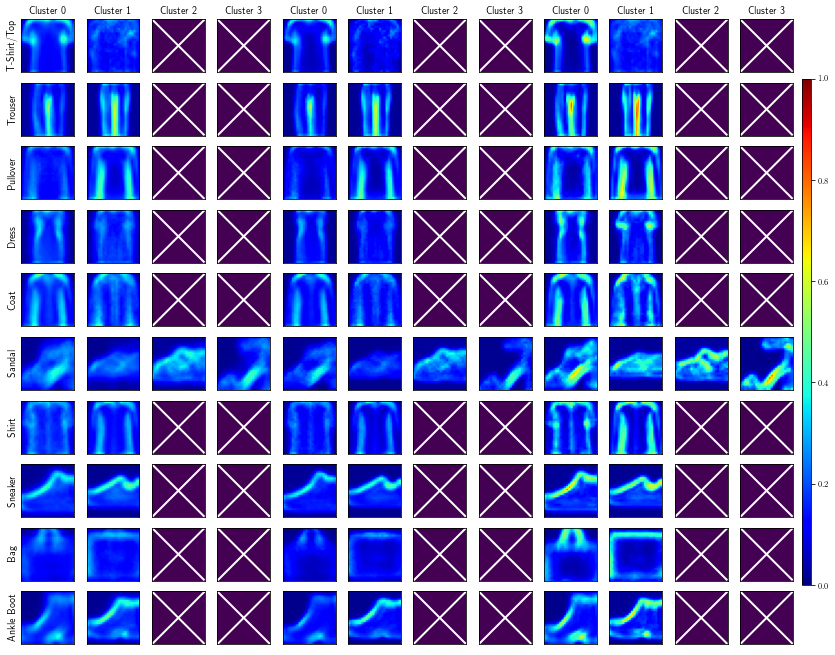

In [ ]:
# Plot de los heatmaps de cada clase
superimposed = False
PERCENTAGE_THRESHOLD = 0.1
# Calculate the number of total columns
max_cols = []
for htmap_prom_cluster in average_heatmaps_per_class_and_cluster:
  max_cols.append(len(htmap_prom_cluster))
max_cols = max(max_cols)
FONTSIZE = 10
# Plots. figsize=(60,41) works
fig, ax = plt.subplots(nrows=NUM_CLASSES,ncols=max_cols*3, figsize = (16.5,11.5),sharex=True,sharey=True,constrained_layout=False,tight_layout=False)
for block in range(3):
  # Generate the average_heatmaps_per_class_and_cluster
  if block == 0:
    AVG_MODE = 'Mean'
    PERCENTAGE_THRESHOLD = None
  if block == 1: 
    AVG_MODE = 'Median'
    PERCENTAGE_THRESHOLD = None
  if block == 2:
    AVG_MODE = 'Mean'
    PERCENTAGE_THRESHOLD = 0.1
  average_heatmaps_per_class_and_cluster = []
  for class_index in range(NUM_CLASSES):
    average_heatmaps_per_class_and_cluster.append(compute_average_heatmaps_per_cluster(clustering_labels_per_class[class_index],heatmaps_train_per_class[class_index], ssim_distance_matrix_per_class[class_index], avg_mode=AVG_MODE,thr=PERCENTAGE_THRESHOLD))

  for class_index in range(NUM_CLASSES):
      for cluster in range(len(average_heatmaps_per_class_and_cluster[class_index])):
        if superimposed == False:
          im = ax[class_index,cluster+4*block].imshow(average_heatmaps_per_class_and_cluster[class_index][cluster],cmap='jet',vmin=0,vmax=1)
        elif superimposed == True:
          one_image_of_class_index = search_index_of_class(class_index,1,train_labels_shuffled)[0]
          ax[class_index,cluster+4*block].imshow(train_images_shuffled[one_image_of_class_index,:,:,0])
          # Save AxesImage for plotting the colorbar
          im = ax[class_index,cluster+4*block].imshow(resize(average_heatmaps_per_class_and_cluster[class_index][cluster], (train_images_shuffled.shape[1:3])),alpha = 0.6,cmap='jet',vmin=0,vmax=1)

        if class_index == 0:
          ax[class_index,cluster+4*block].set_title('Cluster {}'.format(cluster),fontsize=FONTSIZE)
          ax[class_index,cluster+4*block].set_xticks([])
          ax[class_index,cluster+4*block].set_yticks([])
        # Comment the line in the if to not plot the class names
        if cluster == 0 and block == 0:
          ax[class_index,cluster+4*block].set_ylabel(CLASS_NAMES[class_index].title(),rotation = 90, fontsize=FONTSIZE)
          pass

      if len(average_heatmaps_per_class_and_cluster[class_index]) != max_cols:
        for empty_ax_index in range(len(average_heatmaps_per_class_and_cluster[class_index]),max_cols):
          ax[class_index][empty_ax_index+4*block].imshow(np.zeros(np.shape(average_heatmaps_per_class_and_cluster[class_index][cluster])),vmin=0,vmax=1)
          ax[class_index,empty_ax_index+4*block].plot([0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],[len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1,0],c='w',lw=2)
          ax[class_index,empty_ax_index+4*block].plot([0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],[0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],c='w',lw=2)
          if class_index == 0:
            ax[class_index,empty_ax_index+4*block].set_title('Cluster {}'.format(empty_ax_index),fontsize=FONTSIZE)
            ax[class_index,empty_ax_index+4*block].set_xticks([])
            ax[class_index,empty_ax_index+4*block].set_yticks([])

cbar = plt.colorbar(im, ax=ax.ravel().tolist(), aspect=60, shrink=0.81, fraction=0.15, pad=0.01)
cbar.ax.tick_params(labelsize=FONTSIZE-2)
plt.savefig('./Heatmaps_per_class_and_cluster_complete_plot.pdf',bbox_inches='tight')

In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

In [ ]:
params = plt.rcParams["text.usetex"], plt.rcParams["font.family"], plt.rcParams["font.sans-serif"]

In [ ]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [ ]:
!apt-get update
from matplotlib import rc
import matplotlib
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumplus fonts-sil-gentiumplus-compact
  fonts-stix fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcups

## ClusterWithHeatmaps


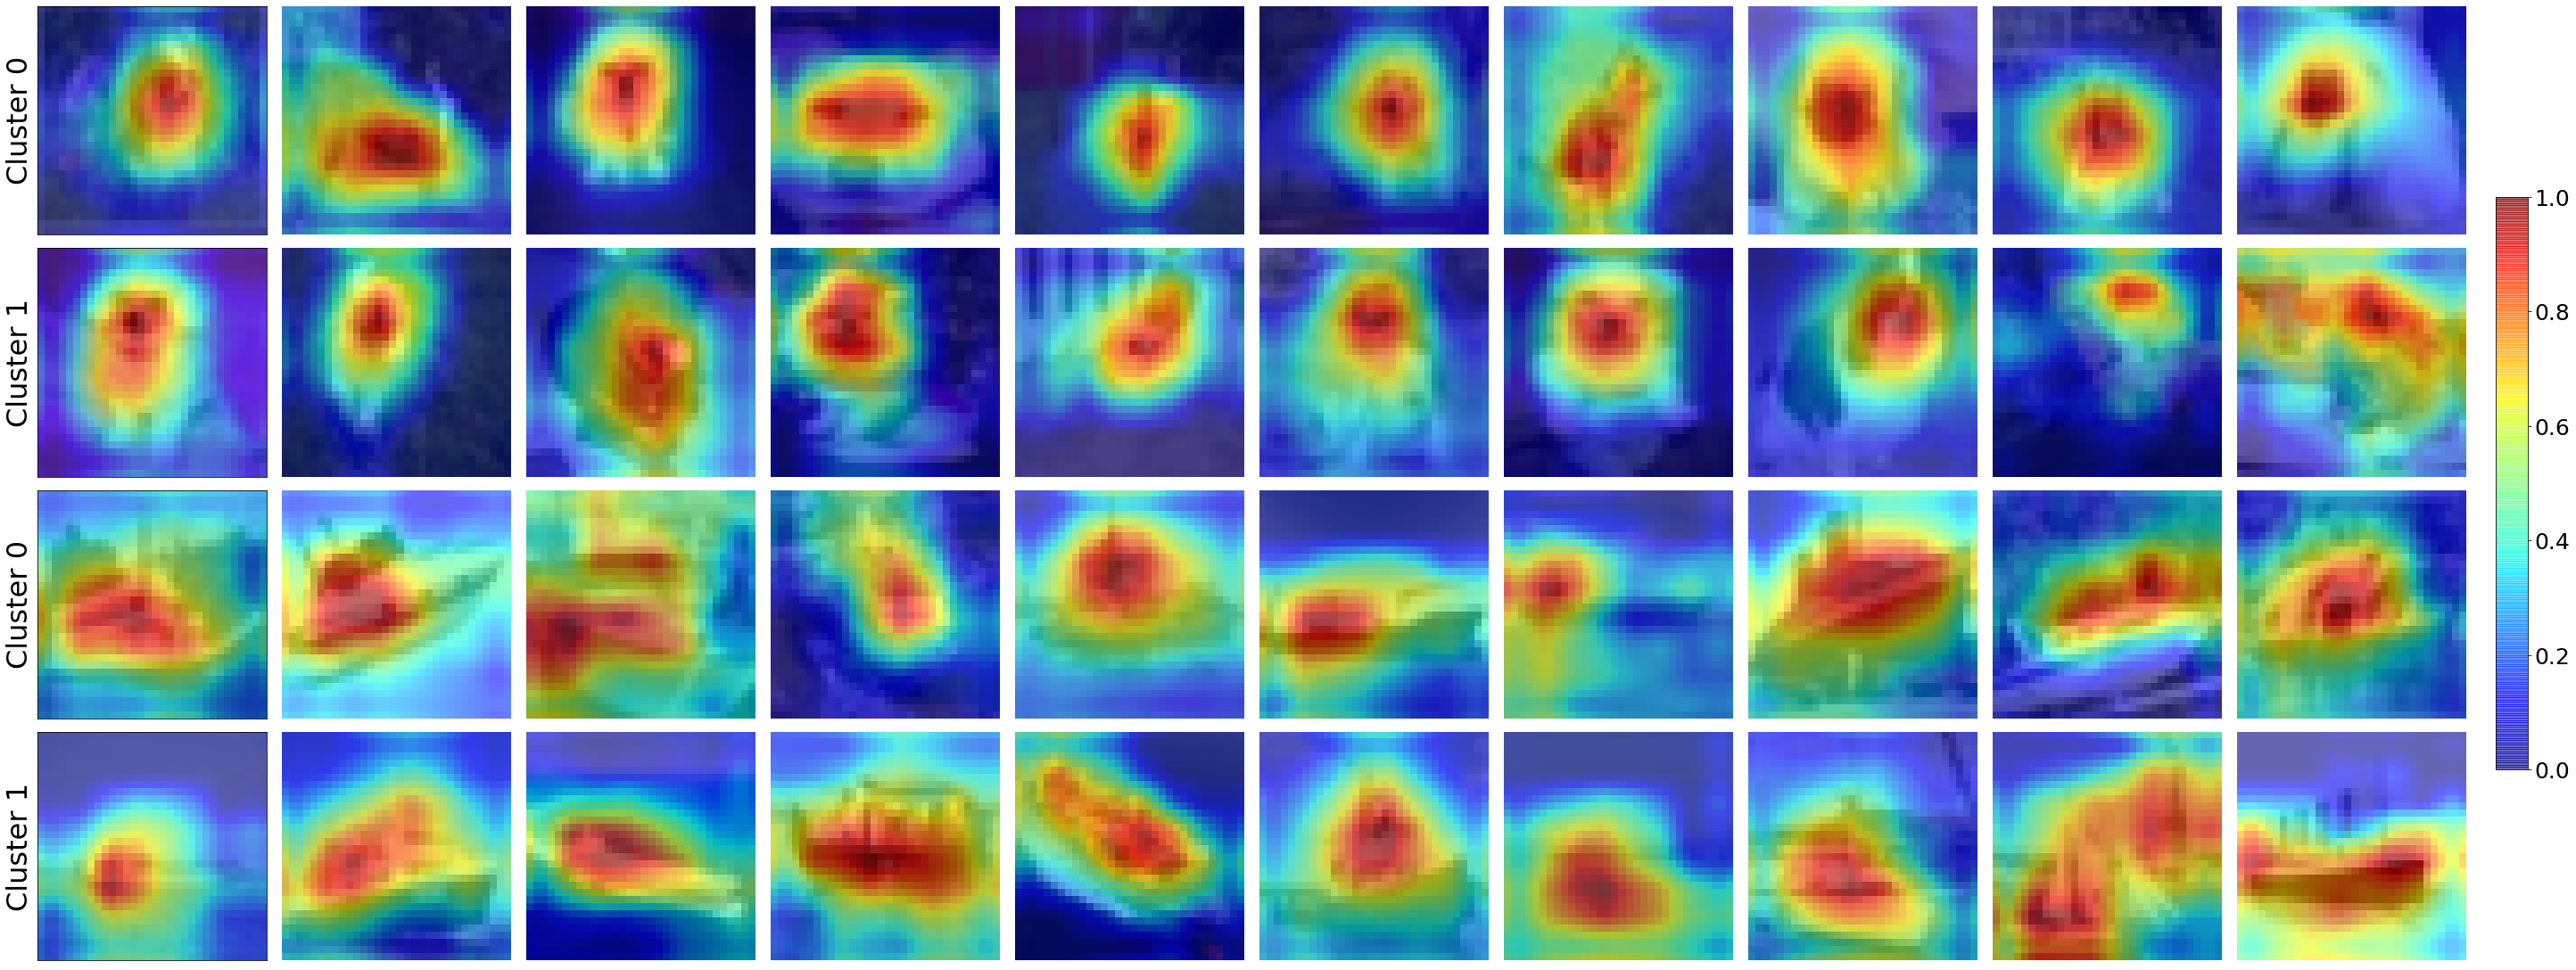

In [ ]:
rows = 4
cols = 10
imgSize = train_images_shuffled.shape[1:3]

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(cols*4,rows*3.75),constrained_layout=True,tight_layout=False)

clase_0 = 5
indices_0 = search_index_of_class(clase_0,NUMBER_OF_INSTANCES_PER_CLASS,train_labels_shuffled)
indices_0_cluster_0 = []
indices_0_cluster_1 = []
for location, index in enumerate(clustering_labels_per_class[clase_0]):
  if index == 0.0: 
    indices_0_cluster_0.append(location)
  else:
    indices_0_cluster_1.append(location)


clase_1 = 8
indices_1 = search_index_of_class(clase_1,NUMBER_OF_INSTANCES_PER_CLASS,train_labels_shuffled)
indices_1_cluster_0 = []
indices_1_cluster_1 = []
for location, index in enumerate(clustering_labels_per_class[clase_1]):
  if index == 0.0: 
    indices_1_cluster_0.append(location)
  else:
    indices_1_cluster_1.append(location)



for i in range(rows):
  for j in range(cols):
    
    if i == 0:
      axes[i,j].imshow(train_images_shuffled[indices_0[indices_0_cluster_0[j]]].squeeze(), cmap='gray')
      axes[i,j].imshow(resize(heatmaps_train_per_class[clase_0][indices_0_cluster_0[j]],imgSize),vmin=0,vmax=1,alpha=0.6,cmap='jet')
    elif i == 1:
      axes[i,j].imshow(train_images_shuffled[indices_0[indices_0_cluster_1[j]]].squeeze(), cmap='gray')
      axes[i,j].imshow(resize(heatmaps_train_per_class[clase_0][indices_0_cluster_1[j]],imgSize),vmin=0,vmax=1,alpha=0.6,cmap='jet')
    elif i == 2:
      axes[i,j].imshow(train_images_shuffled[indices_1[indices_1_cluster_0[j]]].squeeze(), cmap='gray')
      axes[i,j].imshow(resize(heatmaps_train_per_class[clase_1][indices_1_cluster_0[j]],imgSize),vmin=0,vmax=1,alpha=0.6,cmap='jet')
    else:  
      axes[i,j].imshow(train_images_shuffled[indices_1[indices_1_cluster_1[j]]].squeeze(), cmap='gray')
      im = axes[i,j].imshow(resize(heatmaps_train_per_class[clase_1][indices_1_cluster_1[j]],imgSize),vmin=0,vmax=1,alpha=0.6,cmap='jet')

    axes[i,j].set_axis_off()
    if j == 0:
      axes[i,j].set_axis_on()
      axes[i,j].set_xticks([])
      axes[i,j].set_yticks([])
      axes[i,j].set_ylabel('Cluster {}'.format(i % 2),fontsize=32)

cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.01, aspect=28)
cbar.ax.tick_params(labelsize=25)
plt.savefig('./ClustersWithHeatmaps.pdf',bbox_inches='tight')
plt.savefig('./ClustersWithHeatmaps.png',dpi=150,bbox_inches='tight')

## SnearkesVsSandal


In [ ]:
  # Load F_MNIST dataset
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  #Reducimos el rango de los valores a entre 0 y 1
  train_images = train_images/255
  test_images = test_images/255

  #Añadimos la informacion de que se trata de un solo canal (y no 3 como en el caso de RGB)
  train_images = train_images.reshape(60000,28,28,1)
  train_images = train_images.astype('float32')

  test_images = test_images.reshape(10000,28,28,1)
  test_images = test_images.astype('float32')

  #Transformamos los vectores con las etiquetas a categoricos, representando la posicion del 1 en el vector al numero correpondiente
  from tensorflow.keras.utils import to_categorical
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)

  CLASS_NAMES = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  NUM_CLASSES = len(CLASS_NAMES)

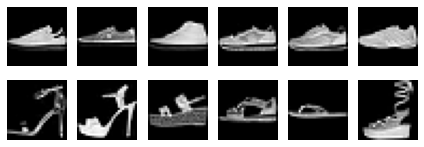

In [ ]:
rows = 2
cols = 6

fig, axes = plt.subplots(nrows=rows,ncols=cols,tight_layout=True)

for i in range(rows):

  if i == 0:
    indices = search_index_of_class(7,cols,train_labels)
  
  if i == 1:
    indices = search_index_of_class(5,cols,train_labels)

  for j in range(cols):

    axes[i,j].imshow(train_images[indices[j]].squeeze(), cmap='gray')
    axes[i,j].set_axis_off()

  plt.savefig('Sneakers_vs_Sandals_{}.pdf'.format(cols),bbox_inches='tight')

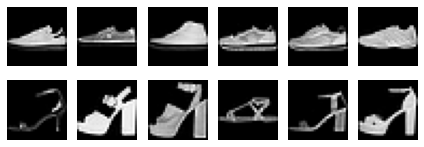

In [ ]:
rows = 2
cols = 6

fig, axes = plt.subplots(nrows=rows,ncols=cols,tight_layout=True)

for i in range(rows):

  if i == 0:
    indices = search_index_of_class(7,cols,train_labels)
  
  if i == 1:
    indices = search_index_of_class(5,cols,train_labels,1600)

  for j in range(cols):

    axes[i,j].imshow(train_images[indices[j]].squeeze(), cmap='gray')
    axes[i,j].set_axis_off()

  plt.savefig('Sneakers_vs_Sandals_{}.pdf'.format(cols),bbox_inches='tight')

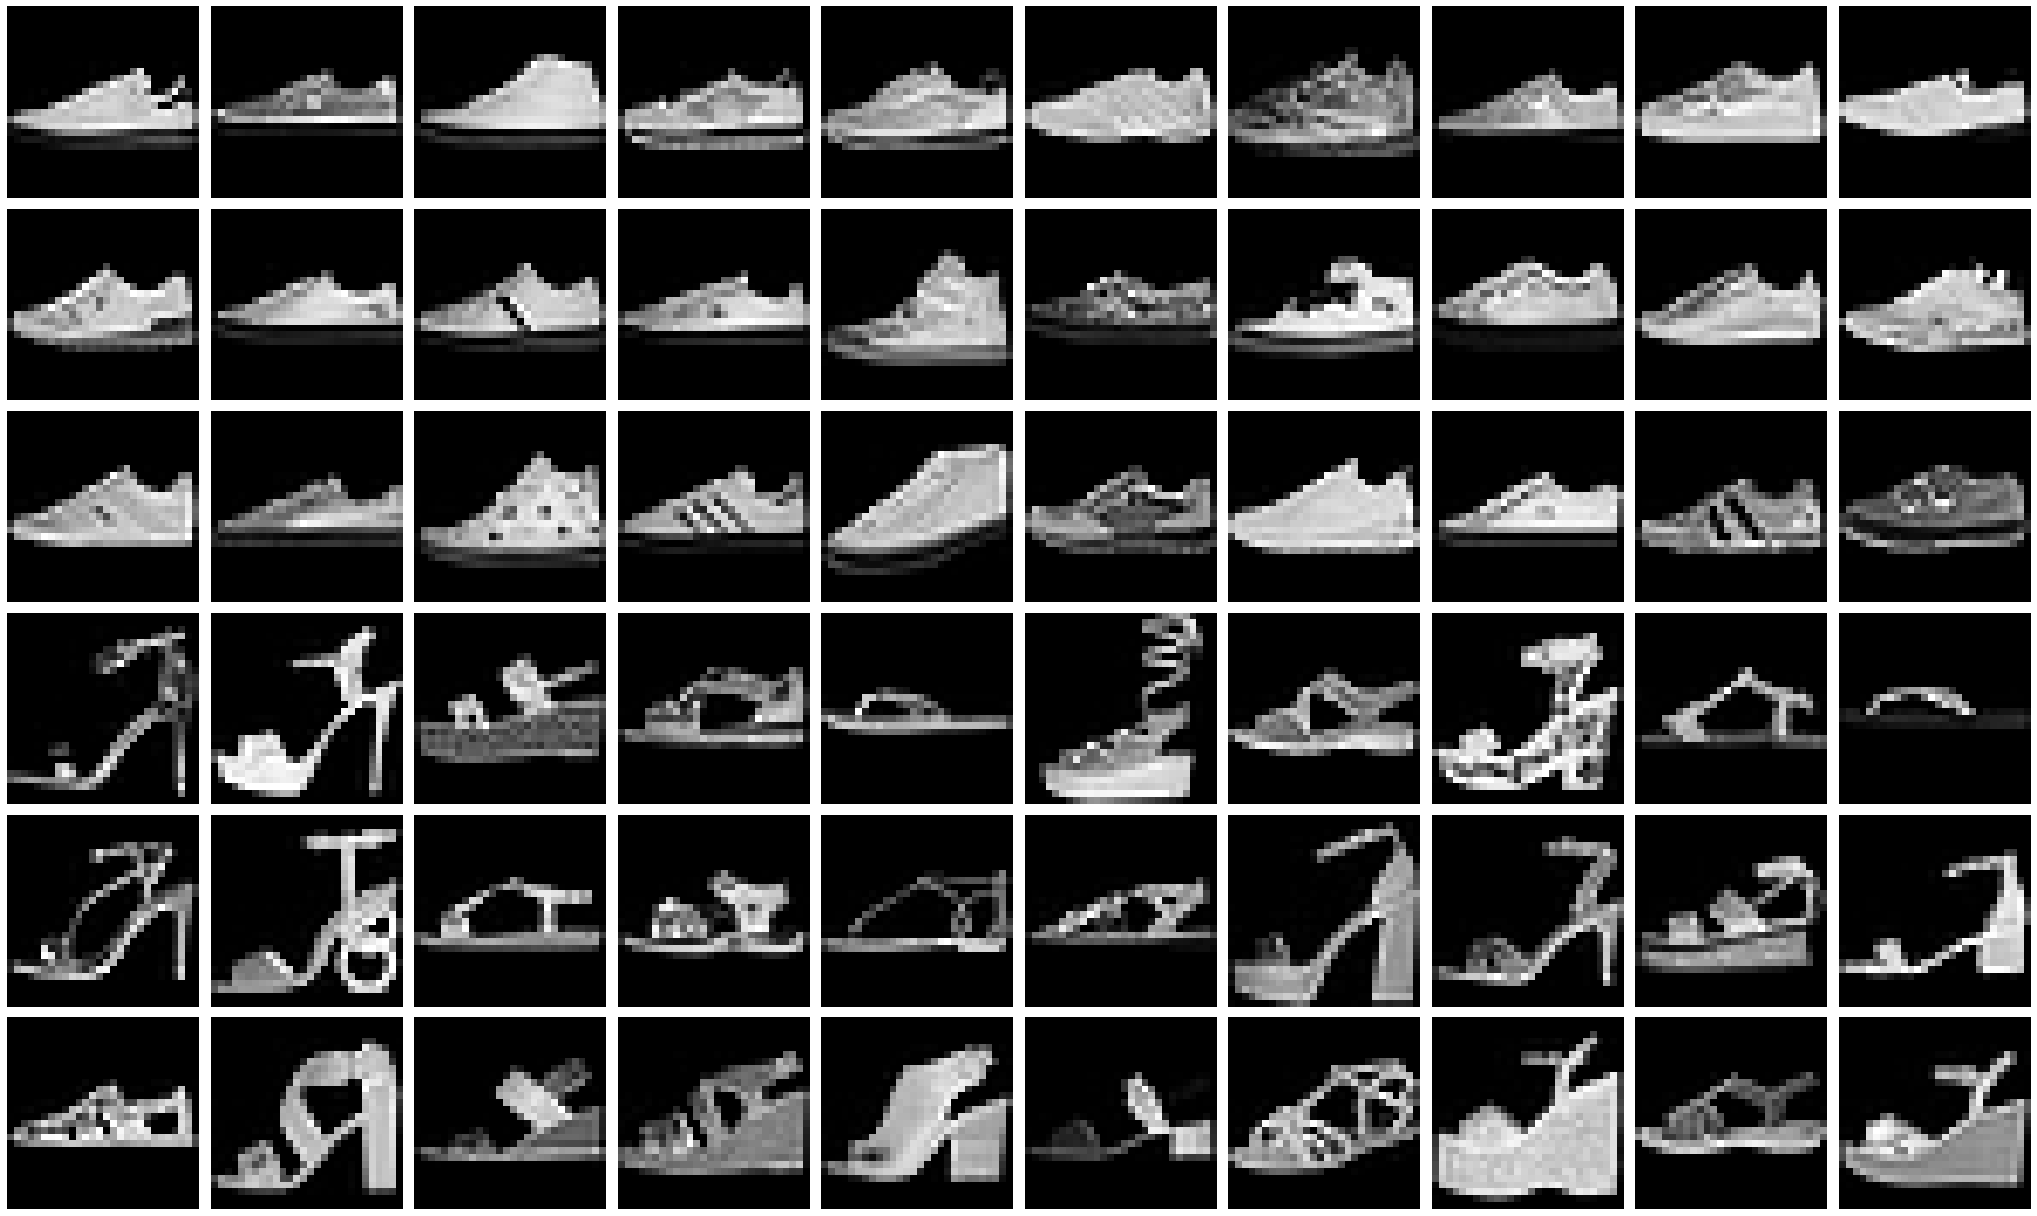

In [ ]:
rows, cols = 6, 10
pos_ini = 0
fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(28.5,17),tight_layout=True)
indices = search_index_of_class(7,(rows*cols)/2,train_labels,pos_ini) + search_index_of_class(5,(rows*cols)/2,train_labels,pos_ini)
for i,ax in enumerate(axes.flat):
  ax.set_axis_off()
  ax.imshow(train_images[indices[i]].squeeze(),cmap='gray')
plt.savefig(f'Sneakers_vs_Sandals_{rows}x{cols}_InitPos_{pos_ini}.pdf',bbox_inches='tight')

In [ ]:
for loc,i in enumerate(indices):
  print(i,end='-')
  print(loc, end=' / ')

8-0 / 9-1 / 12-2 / 13-3 / 30-4 / 36-5 / 43-6 / 60-7 / 62-8 / 63-9 / 82-10 / 116-11 / 120-12 / 121-13 / 133-14 / 155-15 / 172-16 / 173-17 / 177-18 / 192-19 / 201-20 / 213-21 / 217-22 / 224-23 / 227-24 / 230-25 / 244-26 / 246-27 / 257-28 / 267-29 / 274-30 / 300-31 / 303-32 / 320-33 / 343-34 / 345-35 / 349-36 / 363-37 / 371-38 / 384-39 / 386-40 / 

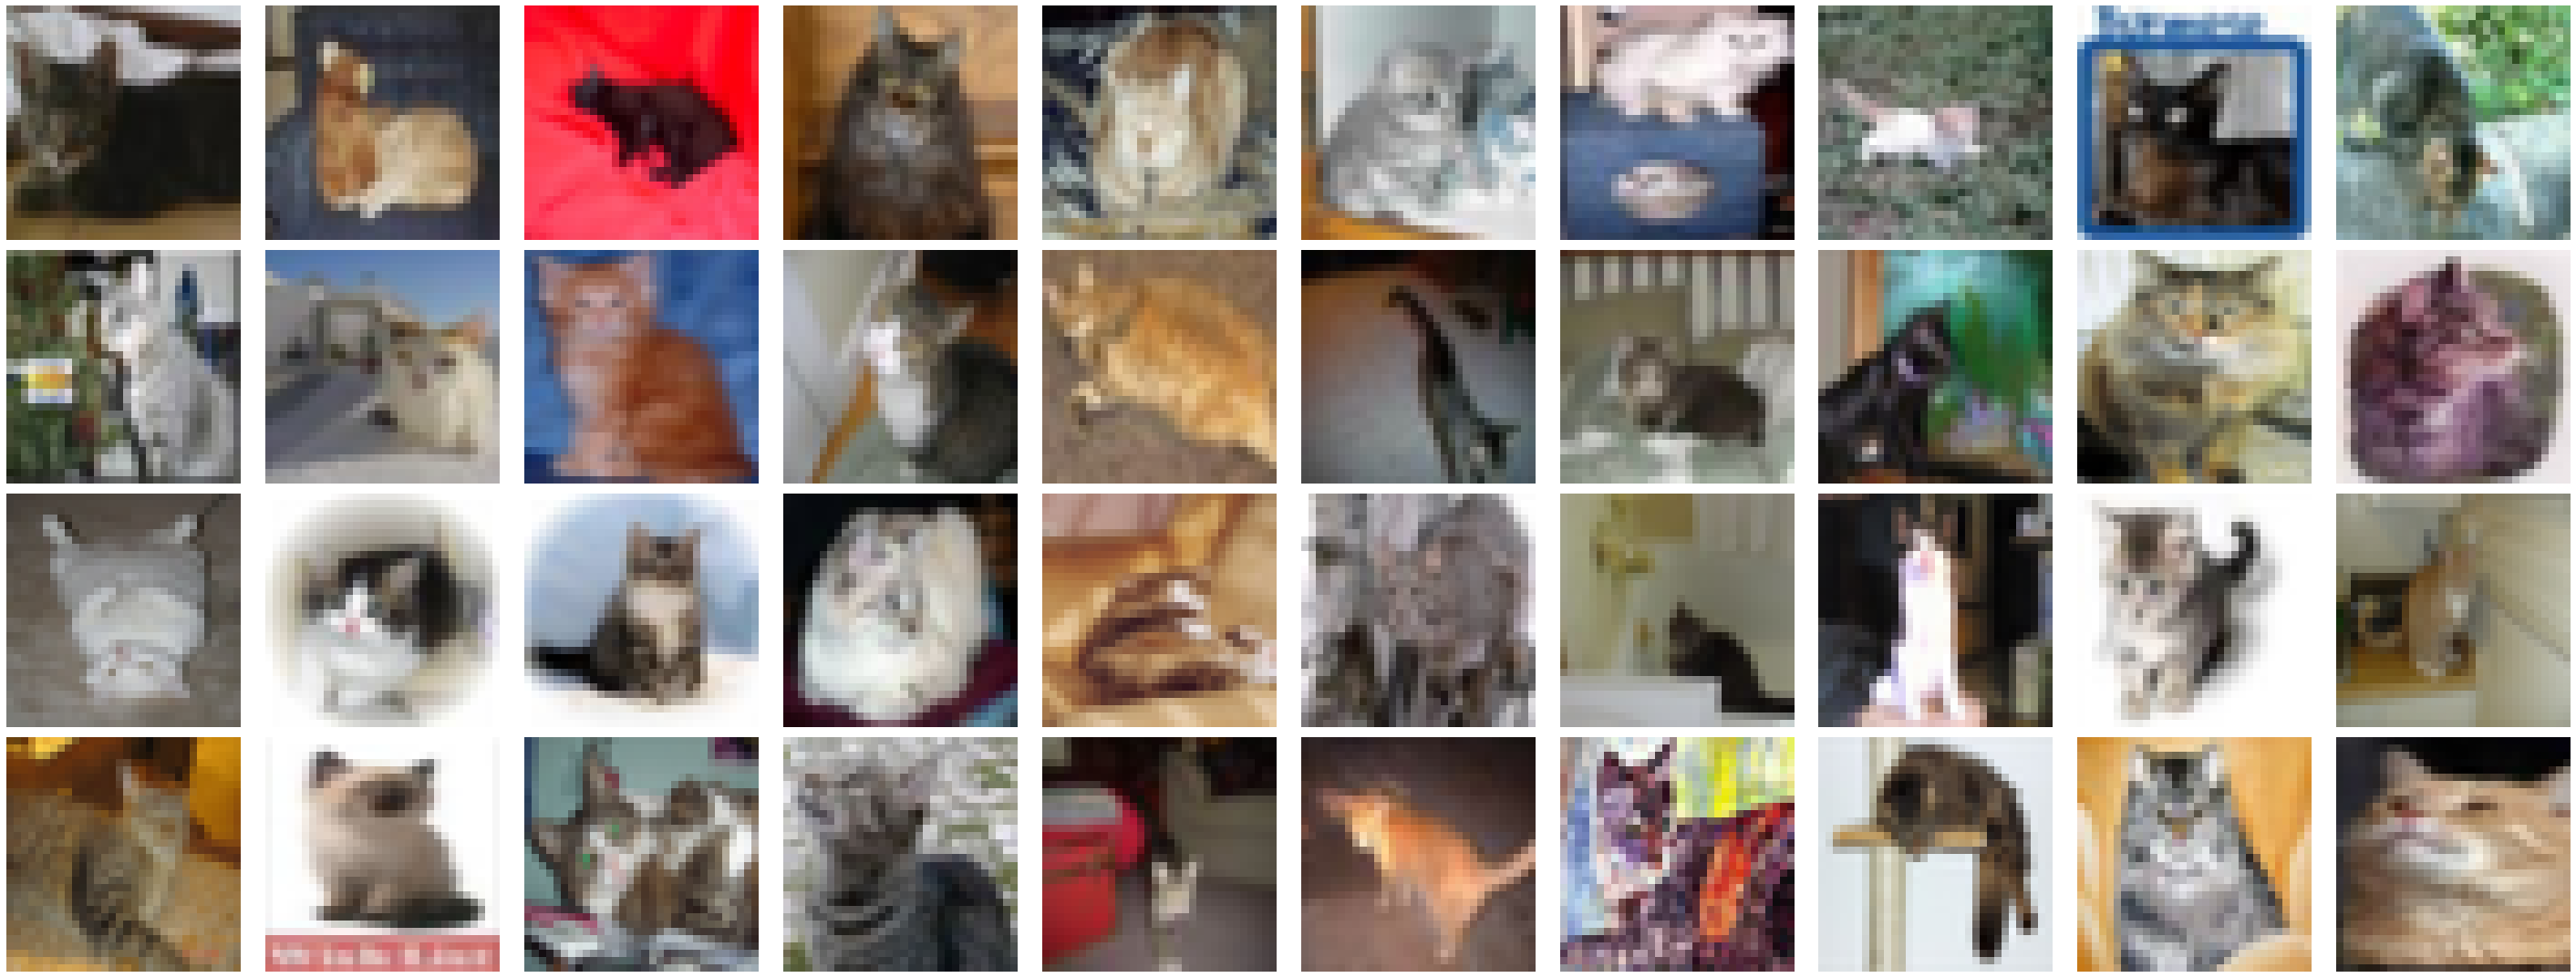

In [ ]:
rows = 4
cols = 10

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(40,15),tight_layout=True)
indices = search_index_of_class(3,rows*cols,train_labels)

for i in range(rows):
  for j in range(cols):
    n = i*10+j
    axes[i,j].imshow(train_images[indices[n]].squeeze(), cmap='gray')
    axes[i,j].set_axis_off()

## DressVsSneakers


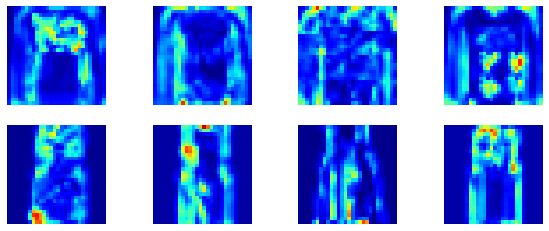

In [ ]:
clase0 = 2
clase1 = 3
imgSize = train_images_shuffled.shape[1:3]

rows = 2
cols = 4
fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*2+2,rows*2])

for i in range(rows):

  if i == 0:
    indices = search_index_of_class(clase0,cols,test_labels)
  
  if i == 1:
    indices = search_index_of_class(clase1,cols,test_labels,1200)

  for j in range(cols):

    axes[i,j].imshow(test_images[indices[j]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(test_heatmaps[indices[j]],imgSize),vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

#cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=20)
#cbar.ax.tick_params(labelsize=10)

plt.savefig('Consistency_{}_{}.pdf'.format(CLASS_NAMES[clase0],CLASS_NAMES[clase1]),bbox_inches='tight')

In [ ]:
for loc,i in enumerate(CLASS_NAMES):
  print(i,end=' ')
  print(loc,end=' // ')

T-shirt/top 0 // Trouser 1 // Pullover 2 // Dress 3 // Coat 4 // Sandal 5 // Shirt 6 // Sneaker 7 // Bag 8 // Ankle boot 9 // 

## Cifar10 consistency


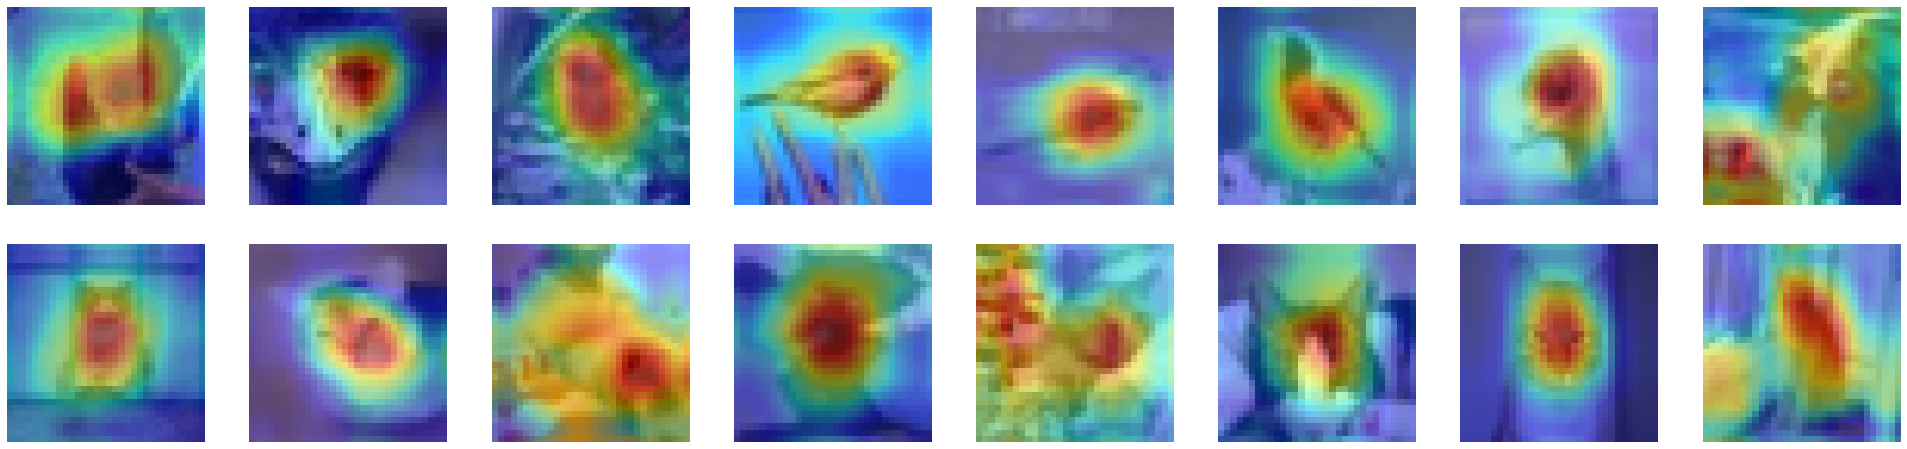

In [ ]:
clase0 = 2
clase1 = 3
imgSize = train_images_shuffled.shape[1:3]

rows = 2
cols = 5

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*4+2,rows*4])

for i in range(rows):

  if i == 0:
    indices = search_index_of_class(clase0,cols,test_labels)
  
  if i == 1:
    indices = search_index_of_class(clase1,cols,test_labels,1200)

  for j in range(cols):

    axes[i,j].imshow(test_images[indices[j]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(test_heatmaps[indices[j]],imgSize),alpha=0.45,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

#cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=20)
#cbar.ax.tick_params(labelsize=10)

plt.savefig('Consistency_{}_{}.pdf'.format(CLASS_NAMES[clase0],CLASS_NAMES[clase1]),bbox_inches='tight')

In [ ]:
rows    = 4
cols    = 10
clase   = 5 # Clase 3 gatos, clase 5 perros
imgSize = train_images_shuffled.shape[1:3]
posIni  = 750

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(40,15),tight_layout=True)
indices = search_index_of_class(clase,rows*cols,train_labels_shuffled,pos=posIni)

for i in range(rows):
  for j in range(cols):
    n = i*10+j
    print(str(n)+'//'+str(indices[n]))
    axes[i,j].imshow(train_images_shuffled[indices[n]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmaps_train_per_class[clase][posIni+n],imgSize),alpha=0.35,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

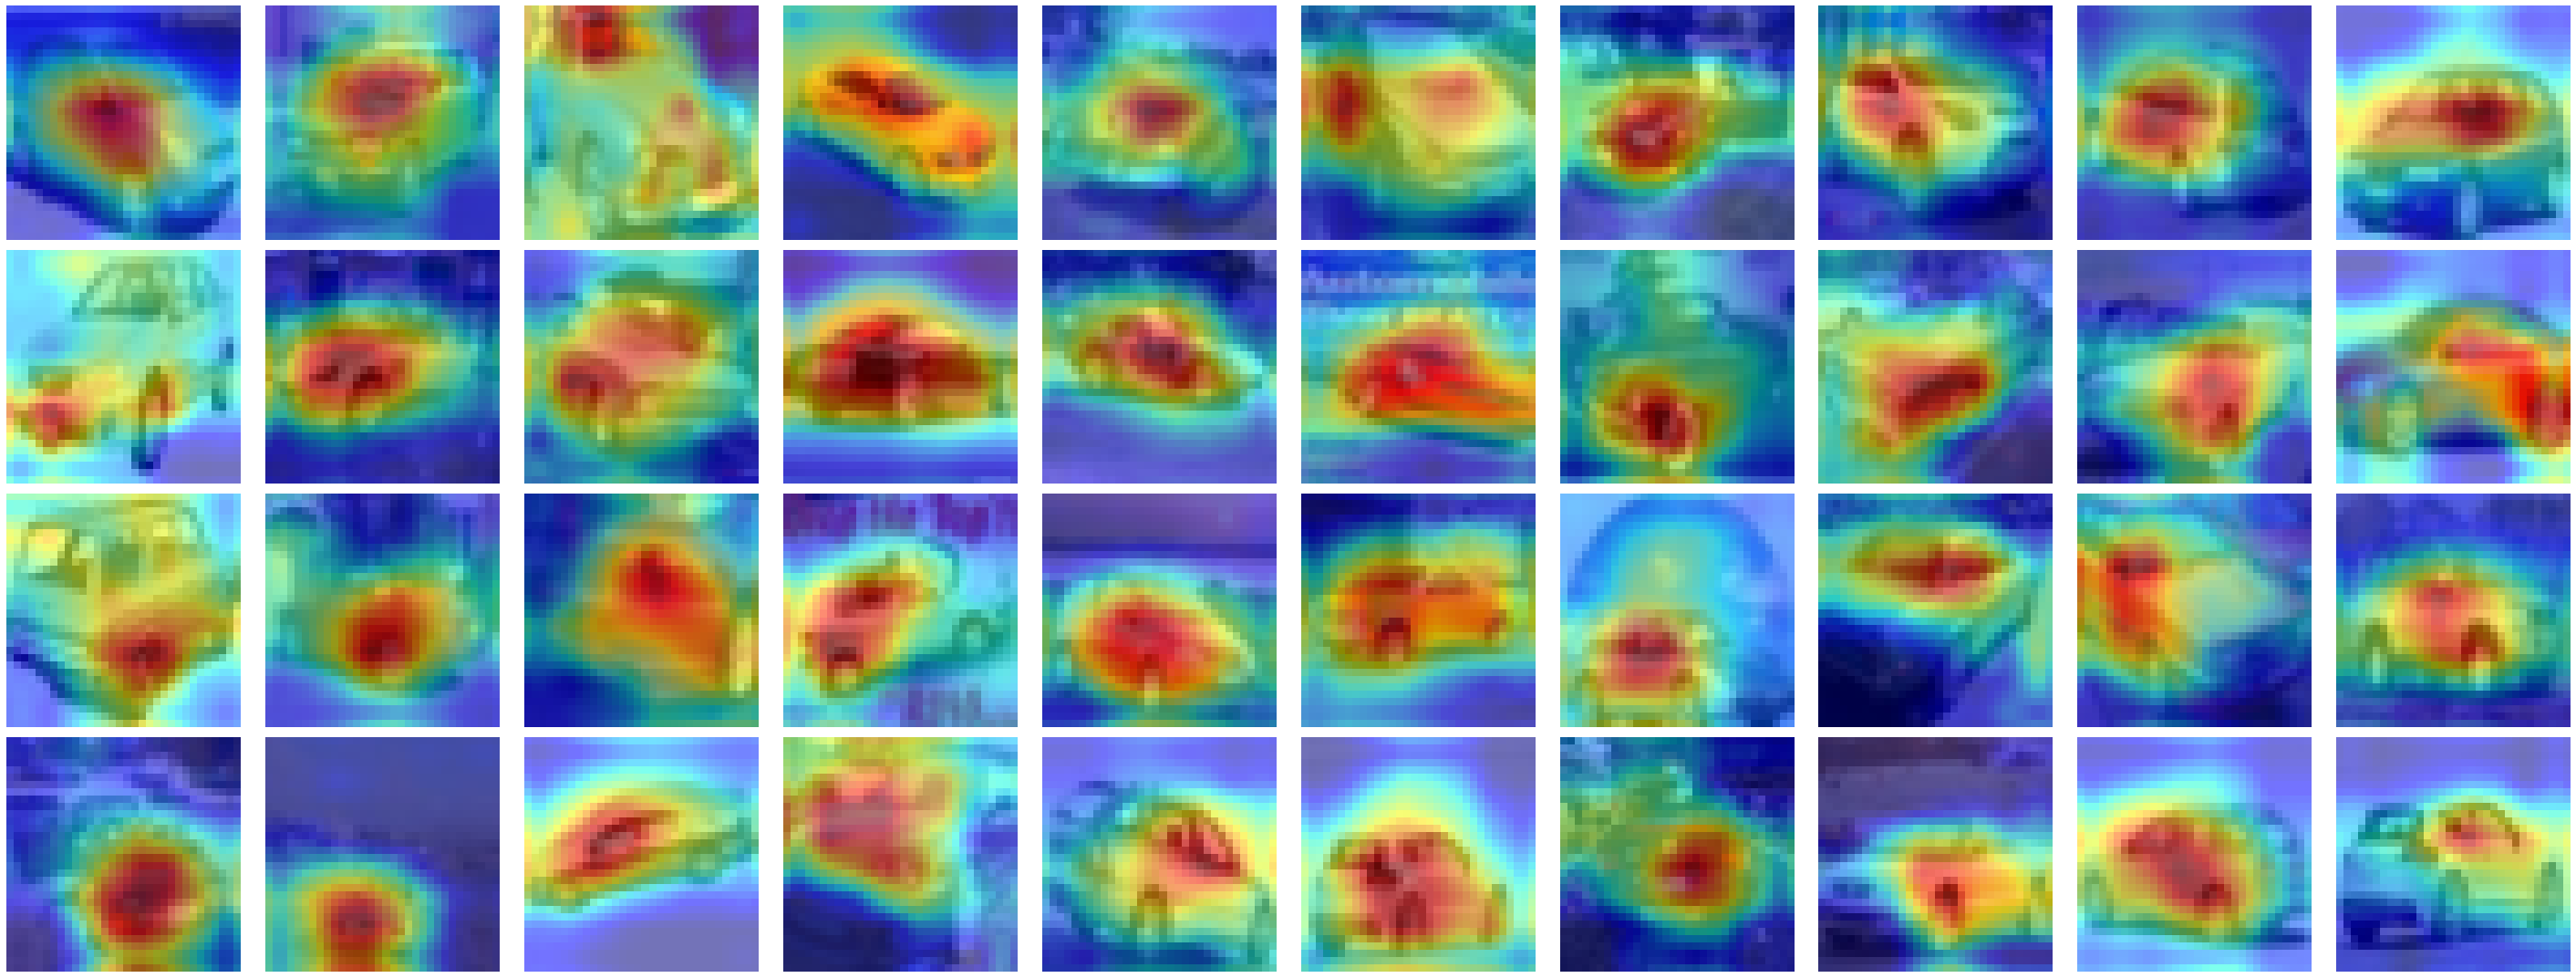

In [ ]:
rows    = 4
cols    = 10
clase   = 1 # Clase 3 gatos, clase 5 perros
imgSize = train_images_shuffled.shape[1:3]
posIni  = 750

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(40,15),tight_layout=True)
indices = search_index_of_class(clase,rows*cols,train_labels_shuffled,pos=posIni)
heatmapsCifar = []
#for ind in indices:
#  heatmapsCifar.append(grad_cam_plus(train_images_shuffled[indices[n]],model,LAST_CONV_LAYER,category_id=train_labels_shuffled[indices[n]]))

for i in range(rows):
  for j in range(cols):
    n = i*10+j
    #print(str(n)+'//'+str(indices[n]))
    heatmap = grad_cam_plus(train_images_shuffled[indices[n]],model,LAST_CONV_LAYER,category_id=np.argmax(train_labels_shuffled[indices[n]]))
    axes[i,j].imshow(train_images_shuffled[indices[n]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmap,imgSize),alpha=0.55,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

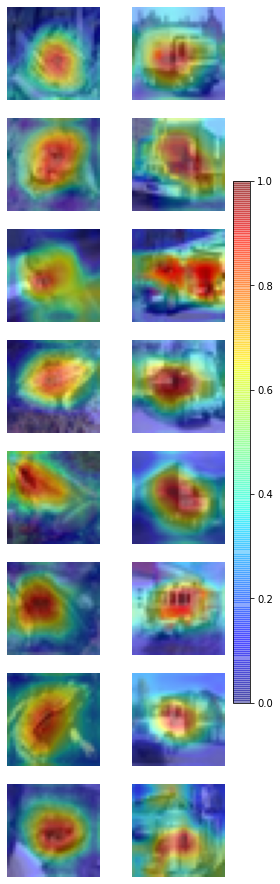

In [ ]:
clase0 = 6
clase1 = 9
imgSize = train_images_shuffled.shape[1:3]
size = 2

rows = 8
cols = 2

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*size+1,rows*size])

for j in range(cols):
  if j == 0:
    indices = search_index_of_class(clase0,rows*(cols/2)-1,test_labels)
  
  if j == 1:
    indices.extend(search_index_of_class(clase1,rows*(cols/2)-1,test_labels))

  for i in range(rows):
    n = i+rows*j
    heatmap = grad_cam_plus(test_images[indices[n]],model,LAST_CONV_LAYER,category_id=np.argmax(test_labels[indices[n]]))
    axes[i,j].imshow(test_images[indices[n]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmap,imgSize),alpha=0.45,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=30)
cbar.ax.tick_params(labelsize=10)

plt.savefig('Consistency_{}_{}.pdf'.format(CLASS_NAMES[clase0],CLASS_NAMES[clase1]),bbox_inches='tight')

In [ ]:
CLASS_NAMES

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

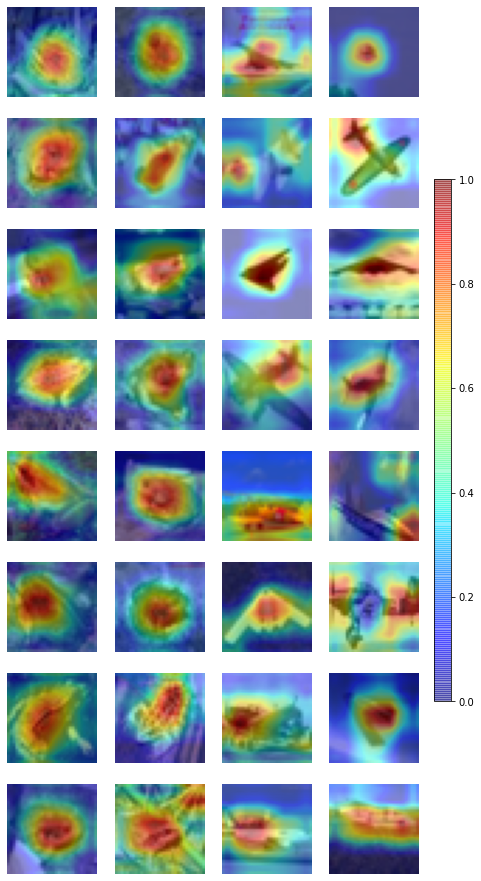

In [ ]:
clase0 = 6
clase1 = 0
imgSize = train_images_shuffled.shape[1:3]
size = 2

rows = 8
cols = 4

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*size+1,rows*size])

for j in range(cols):
  if j == 0:
    indices = search_index_of_class(clase0,rows*(cols/2)-1,test_labels)
  
  if j == 2:
    indices.extend(search_index_of_class(clase1,rows*(cols/2)-1,test_labels))

  for i in range(rows):
    n = i+rows*j
    heatmap = grad_cam_plus(test_images[indices[n]],model,LAST_CONV_LAYER,category_id=np.argmax(test_labels[indices[n]]))
    axes[i,j].imshow(test_images[indices[n]].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmap,imgSize),alpha=0.45,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=30)
cbar.ax.tick_params(labelsize=10)

plt.savefig('Consistency_{}_{}.pdf'.format(CLASS_NAMES[clase0],CLASS_NAMES[clase1]),bbox_inches='tight')
plt.savefig('Consistency_{}_{}.png'.format(CLASS_NAMES[clase0],CLASS_NAMES[clase1]),bbox_inches='tight',dpi=200)

## FMNIST, MNIST y Cifar10gray


In [ ]:
  cifar = tf.keras.datasets.cifar10
  (od_train_images, od_train_labels), (cifar_images, cifar_labels) = cifar.load_data()
  # Damos el formato correspondiente a las imagenes
  cifar_images = cifar_images.reshape(10000, 32, 32, 3)
  cifar_images = cifar_images.astype('float32') / 255
  cifar_images = np.expand_dims(color.rgb2gray(cifar_images),axis=3)
  cifar_images = resize(cifar_images,(10000, 28, 28, 1))

170508288/170498071 [==============================] - 11s 0us/step


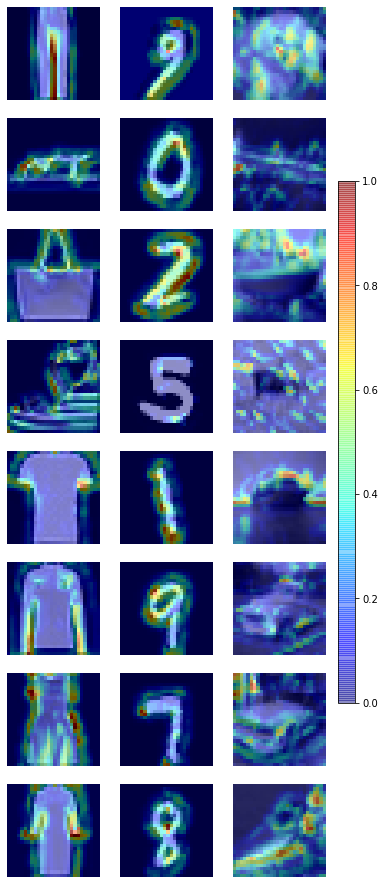

In [ ]:
imgSize = train_images_shuffled.shape[1:3]
size = 2

rows = 8
cols = 3

fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=[cols*size+1,rows*size])

for j in range(cols):

  if j == 0:
    n = 1500
    images = train_images_shuffled[n:(n+rows)] 
    labels = train_labels_shuffled[n:(n+rows)]

  elif j == 1:
    n = 1000
    images = od_test_images[n:(n+rows)] 
    labels = od_test_labels[n:(n+rows)]

  else:
    n = 1000
    images = cifar_images[n:(n+rows)] 
    labels = cifar_labels[n:(n+rows)]

  for i in range(rows):
    heatmap = grad_cam_plus(images[i],model,LAST_CONV_LAYER,category_id=np.argmax(labels[i]))
    axes[i,j].imshow(images[i].squeeze(), cmap='gray')
    im = axes[i,j].imshow(resize(heatmap,imgSize),alpha=0.45,vmin=0,vmax=1,cmap='jet')
    axes[i,j].set_axis_off()

cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.03, aspect=30)
cbar.ax.tick_params(labelsize=10)

plt.savefig('Heatmaps_FMNIST_MNIST_Cifar.pdf'.format(),bbox_inches='tight')
plt.savefig('Heatmaps_FMNIST_MNIST_Cifar.png'.format(),bbox_inches='tight',dpi=200)

## FMNIST image

In [ ]:
for loc,i in enumerate(CLASS_NAMES):
  print(i,end=' ')
  print(loc,end=' // ')

T-shirt/top 0 // Trouser 1 // Pullover 2 // Dress 3 // Coat 4 // Sandal 5 // Shirt 6 // Sneaker 7 // Bag 8 // Ankle boot 9 // 

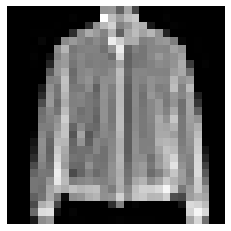

In [ ]:
initPos = 50
classNumber = 4
imgIndex = search_index_of_class(classNumber,1,train_labels,initPos)
plt.imshow(train_images[imgIndex[0],:,:,0],vmin=0,vmax=1,cmap='gray')
plt.gca().set_axis_off()
plt.savefig('FMNIST_{}_{}.pdf'.format(CLASS_NAMES[classNumber],initPos),bbox_inches='tight')
plt.savefig('FMNIST_{}_{}.png'.format(CLASS_NAMES[classNumber],initPos),bbox_inches='tight',dpi=200)

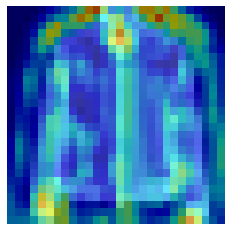

In [ ]:
initPos = 50
classNumber = 4
imgIndex = search_index_of_class(classNumber,1,train_labels,initPos)
htmap = grad_cam_plus(train_images[imgIndex[0]],model,LAST_CONV_LAYER,category_id=np.argmax(train_labels[imgIndex]))
plt.imshow(train_images[imgIndex[0],:,:,0],vmin=0,vmax=1,cmap='gray')
plt.imshow(resize(htmap,(28,28)),vmin=0,vmax=1,cmap='jet',alpha=0.6)
plt.gca().set_axis_off()
plt.savefig('FMNIST_{}_{}_htmap.pdf'.format(CLASS_NAMES[classNumber],initPos),bbox_inches='tight')
plt.savefig('FMNIST_{}_{}_htmap.png'.format(CLASS_NAMES[classNumber],initPos),bbox_inches='tight',dpi=200)

## Clusters plot

In [ ]:
from matplotlib.transforms import Bbox

# Rotated or Translated

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

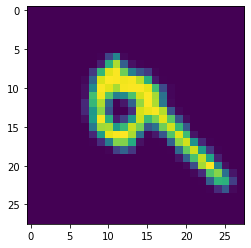

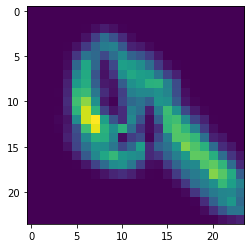

In [ ]:
a = 7
plt.imshow(od_test_images[a,:,:,0])
plt.show()
plt.imshow(od_heatmaps[a])
plt.show()

In [ ]:
def cosine_distance_matrix_creation(heatmaps_array):
  '''
  Creates an upper triangular array with the pairwise distances between each heatmap in the array provided.
  
  ssim_mat = np.zeros((len(heatmaps_array),len(heatmaps_array)))
  for i,htmap in enumerate(heatmaps_array):
    # We visit every column which index is greater than the index of the current row.
    # The diagonal is not visited as the distance between two identical images is 0 
    # and the array is defined all zeros.
    for j in range(i+1,len(heatmaps_array)):
      ssim_mat[i,j] = cosine_distances(htmap.reshape(1,-1),heatmaps_array[j].reshape(1,-1))
      ssim_mat[j,i] = ssim_mat[i,j]
  '''
  ssim_mat = cosine_distances(heatmaps_array.reshape(len(heatmaps_array),-1))
  return ssim_mat


def compute_cosine_sim_against_cluster_averages(input_heatmaps,preds,avg_htmaps_per_class_and_cluster,mode='Similarity'):
  '''
  Computes the ssim of the input heatmaps against the cluster averages of the predicted class
  '''
  # Initialize the array containing the SSIM values
  ssim_per_input_heatmap = np.zeros((len(input_heatmaps)))
  for index,predicted_class in tqdm(enumerate(preds)):
    # Initialize the aray containing the SSIM values against cluster averages for one input heatmap
    ssim_against_cluster_avgs = np.zeros((avg_htmaps_per_class_and_cluster[predicted_class].shape[0]))
    if mode == 'Similarity':
      for index_avg_htmap, avg_htmap  in enumerate(avg_htmaps_per_class_and_cluster[predicted_class]):
        ssim_against_cluster_avgs[index_avg_htmap] = cosine_similarity(avg_htmap.reshape(1,-1),input_heatmaps[index].reshape(1,-1))
    elif mode == 'Distance':
      for index_avg_htmap, avg_htmap  in enumerate(avg_htmaps_per_class_and_cluster[predicted_class]):
        ssim_against_cluster_avgs[index_avg_htmap] = cosine_similarity(avg_htmap,input_heatmaps[index])
    else:
      raise NameError('Selected mode does not exist')
    # Select the more similar average heatmap (the max SSIM value)  
    ssim_per_input_heatmap[index] = np.max(ssim_against_cluster_avgs) 
  return ssim_per_input_heatmap


def compute_ssim_against_all_heatmps_of_closest_cluster(input_heatmaps, preds, avg_htmaps_per_class_and_cluster, heatmaps_in_the_clusters_per_class, cluster_indexes_of_heatmaps):
  '''
  Computes the ssim of the input heatmaps against all the heatmaps of the closest cluster of the predicted class.
  First computes the SSIM against cluster averages, and it selects the max similarity (max ssim).
  Then computes the SSIM against all the heatmaps belonging to that cluster
  '''
  # Initialize the array that will contain the SSIM values
  ssim_per_input_heatmap = np.zeros((len(input_heatmaps)))
  for index,predicted_class in tqdm(enumerate(preds)):
    # Initialize the array that will contain the SSIM values to the cluster averages.
    ssim_against_cluster_avgs = np.zeros((len(avg_htmaps_per_class_and_cluster[predicted_class])))
    for index_avg_htmap, avg_htmap in enumerate(avg_htmaps_per_class_and_cluster[predicted_class]):
      # Calculamos cual las distancias a cada cluster y nos quedamos con el heatmap mas cercano del cluster mas cercano
      ssim_against_cluster_avgs[index_avg_htmap] = ssim(input_heatmaps[index],avg_htmap, data_range=DATA_RANGE)
      closest_cluster_index = np.argmax(ssim_against_cluster_avgs) # Max similarity == Closest cluster
    # Indexes of the heatmaps that belong to the nearest cluster.
    indexes_of_closest_cluster_heatmaps = np.asarray(np.asarray(cluster_indexes_of_heatmaps[predicted_class] == closest_cluster_index).nonzero()[0])
    # Compute every SSIM value to the heatmaps in the closest cluster
    # Initialze the array that will contain the SSIM values against all heatmaps in closest cluster
    ssim_against_closest_cluster_heatmaps = np.zeros((len(indexes_of_closest_cluster_heatmaps)))
    for i, htmap_indexes in enumerate(indexes_of_closest_cluster_heatmaps):
      ssim_against_closest_cluster_heatmaps[i] = ssim(input_heatmaps[index],heatmaps_in_the_clusters_per_class[predicted_class,htmap_indexes], data_range=DATA_RANGE)
    # Select the more similar average heatmap (the max SSIM value) 
    ssim_per_input_heatmap[index] = np.max(ssim_against_closest_cluster_heatmaps) 
  return ssim_per_input_heatmap

Crear matriz con cosine distance para comprobar si clusteriza mejor o peor

In [ ]:
# Creation of the matrix with the Dssim values in pairs (15 mins approx.)
!mkdir -p objects
file_name_pairwise_dist_matrix = f'cosine_distance_matrix_per_class_{DATASET_NAME}_{MODEL_NAME}_{load_or_train.value}_seed{SEED}.npy'
path_pairwise_dist_matrix = os.path.join(OBJS_DIR_NAME, file_name_pairwise_dist_matrix)
if os.path.isfile(path_pairwise_dist_matrix):
  ssim_distance_matrix_per_class = np.load(path_pairwise_dist_matrix)
  print('Distance matrix loaded from file')
else:
  print('Pairwise distances matrix computation:')
  ssim_distance_matrix_per_class = np.zeros((NUM_CLASSES,heatmaps_train_per_class.shape[1],heatmaps_train_per_class.shape[1])) 
  for class_index in tqdm(range(NUM_CLASSES)):
    ssim_distance_matrix_per_class[class_index] = cosine_distance_matrix_creation(heatmaps_train_per_class[class_index])
  np.save(path_pairwise_dist_matrix, ssim_distance_matrix_per_class, allow_pickle=False)

Pairwise distances matrix computation:


100%|██████████| 10/10 [00:00<00:00, 41.99it/s]


In [ ]:
#@title Compute the distance matrix with pairwise SSIM distance (D_ssim)
# Definition of the distance threshold (parameter for the Agglomerative clustering) for each class
# We try different distance thresholds and select the one whose silhouette score is the greatest in the defined range
print('Select the parameter "distance_threshold" of Agglomerative Clustering by optimizing the Silhouette score\n')
'''
distance_threshold = []
range_of_dist_thrs = np.linspace(0.52,1.50,39)
silhouette_scores_per_class = []
clustering_labels_per_class = np.zeros((NUM_CLASSES,ssim_distance_matrix_per_class.shape[1]))
for class_index in tqdm(range(NUM_CLASSES)):
  silh_scores_one_class = []
  for dist in range_of_dist_thrs:
    # For each distance threshold, we compute the clustering and the silhouette score
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=dist)
    cluster_model.fit(ssim_distance_matrix_per_class[class_index])
    clustering_labels_per_class[class_index] = cluster_model.labels_
    try:
      silh_scores_one_class.append(silhouette_score(ssim_distance_matrix_per_class[class_index],clustering_labels_per_class[class_index],metric='precomputed'))
    except ValueError:
      silh_scores_one_class.append(0)    
  silhouette_scores_per_class.append(silh_scores_one_class)
  positions = []
  max_score = max(silh_scores_one_class)
  for index, score in enumerate(silh_scores_one_class[::-1]):
    if score == max_score:
      positions.append(index)
  # We select the max silhouette score closer to distance_threshold = 0  
  distance_threshold.append(range_of_dist_thrs[len(range_of_dist_thrs)-positions[-1]-1])
'''
a = 0.99
distance_threshold=[a,a,a,a,a,a,a,a,a,a]

print('')
# Plot to see the silhouette scores
plt.subplots(2,5,figsize=(25,10))
for class_index,position in enumerate(range(1,11)):
  plt.subplot(2,5,position).plot(range_of_dist_thrs,silhouette_scores_per_class[class_index],color='red')
  plt.title(CLASS_NAMES[class_index])
plt.savefig('silhouetteScores.pdf')
plt.show()


# Function that creates de clusters of each class
# Initialization of the array containing the labels of the labels for each image in each class
clustering_labels_per_class = np.zeros((NUM_CLASSES,ssim_distance_matrix_per_class.shape[1]))
# plot the top three levels of the dendrogram
w = 40
h = 15
fig,ax = plt.subplots(2,5,figsize=(w,h))
fig.suptitle('Hierarchical Clustering Dendrogram',fontsize = h + w*0.1,y=0.94)
for class_index in range(NUM_CLASSES):
  if isinstance(distance_threshold,list):
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=distance_threshold[class_index])
  else:
    cluster_model = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=distance_threshold)
  cluster_model.fit(ssim_distance_matrix_per_class[class_index])
  clustering_labels_per_class[class_index] = cluster_model.labels_
  if class_index < 5:
    i = 0
    j = class_index
  else:
    i = 1
    j = class_index - 5
  plot_dendrogram(cluster_model, truncate_mode='level', p=2, ax=ax[i,j])
  ax[i,j].set_title('Class {}'.format(CLASS_NAMES[class_index]),fontsize = h)
  #ax[i,j].set_xlabel("Number of points in node",fontsize=h)
plt.savefig('DendrogramPerClass.pdf')
fig.show()
print('-'*100,'\n')
for class_index in range(NUM_CLASSES):
  a = clustering_labels_per_class[class_index]
  unique, counts = np.unique(a, return_counts=True)
  print('Class',CLASS_NAMES[class_index].ljust(15),'\t',dict(zip(unique, counts)))
  print('-'*75)
print('\n'+'-'*100)

In [ ]:
#@title Select the approach
STYLE = {'description_width': 'initial'}
WIDTH = '500px'
mean_or_median = widgets.Combobox(placeholder='Choose mean or median',
        options=['Mean', 'Median'],
        description='Average mode:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
all_or_percentage = widgets.Combobox(placeholder='Choose all heatmaps or a percentaje of closest ones',
        options=['All', 'Percentage'],
        description='Average computation:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
button_approach = widgets.Button(
    description='Push the button to confirm',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width=WIDTH),
    style=STYLE
)
# HTML text
text_percentage = 'Select or enter the percentage value (in the paper 10% is used):'
instructions_percentage = ipw.widgets.HTML(text_percentage)
percentage = widgets.IntSlider(placeholder='Choose the percetage:',
        value=10,
        min=10,
        max=100,
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
button_percentage = widgets.Button(
    description='Push the button to confirm',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width=WIDTH),
    style=STYLE
)
def on_button_clicked_approach_definition(_):
  global average_heatmaps_per_class_and_cluster
  global AVG_MODE
  AVG_MODE = mean_or_median.value
  button_approach.button_style = 'success'
  if all_or_percentage.value == 'Percentage':
    button_approach.description = 'Success!'
    instructions_percentage.layout.visibility = 'visible'
    button_percentage.layout.visibility = 'visible'
    percentage.layout.visibility = 'visible'
  else:
    global PERCENTAGE_THRESHOLD
    button_approach.description = 'Options confirmed!'
    instructions_percentage.layout.display = 'none'
    button_percentage.layout.display = 'none'
    percentage.layout.display = 'none'
    PERCENTAGE_THRESHOLD = None
    # Create the average heatmaps
    file_name_average_heatmaps = f'average_heatmaps_per_class_and_cluster_{DATASET_NAME}_{MODEL_NAME}_{load_or_train.value}_seed{SEED}_{AVG_MODE}_{all_or_percentage.value}.pkl'
    path_heatmaps_average_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_average_heatmaps)
    # Checks if it exists
    if os.path.isfile(path_heatmaps_average_heatmaps):
      print('File exist, it will be loaded')
      with open(path_heatmaps_average_heatmaps, "rb") as f:
        average_heatmaps_per_class_and_cluster = pickle.load(f)
    else:
      average_heatmaps_per_class_and_cluster = []
      print('Computing the average:')
      for class_index in tqdm(range(NUM_CLASSES)):
        average_heatmaps_per_class_and_cluster.append(compute_average_heatmaps_per_cluster(clustering_labels_per_class[class_index],heatmaps_train_per_class[class_index], ssim_distance_matrix_per_class[class_index], avg_mode=AVG_MODE,thr=PERCENTAGE_THRESHOLD))
      with open(path_heatmaps_average_heatmaps, "wb") as f:
        pickle.dump(average_heatmaps_per_class_and_cluster, f)


def on_button_clicked_percentage_definition(_):
  global PERCENTAGE_THRESHOLD
  global average_heatmaps_per_class_and_cluster
  button_percentage.button_style = 'success'
  PERCENTAGE_THRESHOLD = percentage.value*0.01
  button_percentage.description = 'Percentage confirmed!'
  # Create the average heatmaps
  file_name_average_heatmaps = f'average_heatmaps_per_class_and_cluster_{DATASET_NAME}_{MODEL_NAME}_{load_or_train.value}_seed{SEED}_{AVG_MODE}_{all_or_percentage.value}_{PERCENTAGE_THRESHOLD}.pkl'
  path_heatmaps_average_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_average_heatmaps)
  # Checks if it exists
  if os.path.isfile(path_heatmaps_average_heatmaps):
    print('File exist, it will be loaded')
    with open(path_heatmaps_average_heatmaps, "rb") as f:
      average_heatmaps_per_class_and_cluster = pickle.load(f)
  else:
    average_heatmaps_per_class_and_cluster = []
    print('Computing the average:')
    all = []
    perc = []
    for class_index in tqdm(range(NUM_CLASSES)):
      average_heatmaps_per_class_and_cluster.append(compute_average_heatmaps_per_cluster(clustering_labels_per_class[class_index],heatmaps_train_per_class[class_index], ssim_distance_matrix_per_class[class_index], avg_mode=AVG_MODE,thr=PERCENTAGE_THRESHOLD))
    with open(path_heatmaps_average_heatmaps, "wb") as f:
      pickle.dump(average_heatmaps_per_class_and_cluster, f)


# Hide the percentage selection
instructions_percentage.layout.visibility = 'hidden'
percentage.layout.visibility = 'hidden'
button_percentage.layout.visibility = 'hidden'

button_approach.on_click(on_button_clicked_approach_definition)
button_percentage.on_click(on_button_clicked_percentage_definition)
display(mean_or_median)
display(all_or_percentage)
display(button_approach)
print('')
display(instructions_percentage)
display(percentage)
display(button_percentage)
print('')

Combobox(value='', description='Average mode:', ensure_option=True, layout=Layout(width='500px'), options=('Me…

Combobox(value='', description='Average computation:', ensure_option=True, layout=Layout(width='500px'), optio…

Button(button_style='info', description='Push the button to confirm', icon='check', layout=Layout(width='500px…

HTML(value='Select or enter the percentage value (in the paper 10% is used):', layout=Layout(visibility='hidde…

IntSlider(value=10, layout=Layout(visibility='hidden', width='500px'), min=10, style=SliderStyle(description_w…

Button(button_style='info', description='Push the button to confirm', icon='check', layout=Layout(visibility='…


File exist, it will be loaded
Computing the average:


100%|██████████| 10/10 [00:00<00:00, 541.46it/s]


File exist, it will be loaded
Computing the average:


100%|██████████| 10/10 [00:00<00:00, 422.03it/s]


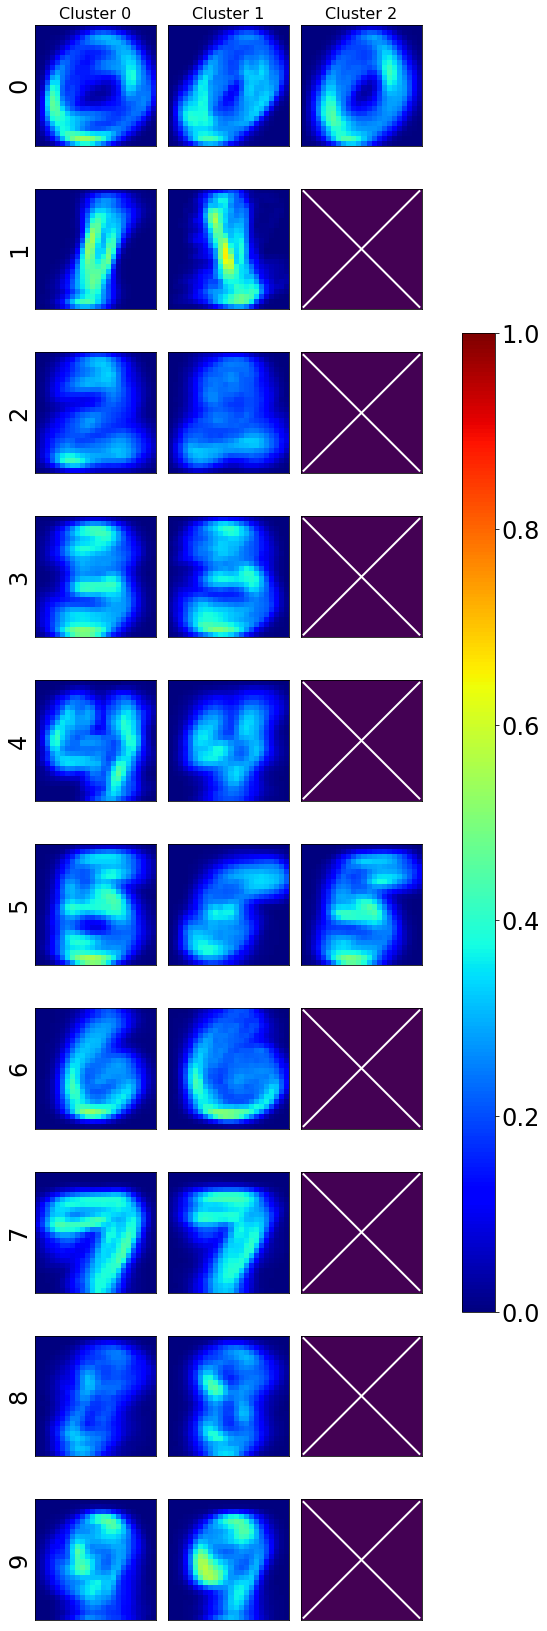

In [ ]:
#@title Plot the average heatmaps of each cluster of each class
# Plot de los heatmaps de cada clase
superimposed = False
# Calculate the number of total columns
max_cols = []
for htmap_prom_cluster in average_heatmaps_per_class_and_cluster:
  max_cols.append(len(htmap_prom_cluster))
max_cols = max(max_cols)
FONTSIZE = 10+2*max_cols 
# Plots
fig, ax = plt.subplots(nrows=NUM_CLASSES,ncols=max_cols, figsize = (3*max_cols,3*NUM_CLASSES),sharex=True,sharey=True,constrained_layout=False,tight_layout=False)
for class_index in range(NUM_CLASSES):
  for cluster in range(len(average_heatmaps_per_class_and_cluster[class_index])):
    if superimposed == False:
      im = ax[class_index,cluster].imshow(average_heatmaps_per_class_and_cluster[class_index][cluster],cmap='jet',vmin=0,vmax=1)
    elif superimposed == True:
      one_image_of_class_index = search_index_of_class(class_index,1,train_labels_shuffled)[0]
      ax[class_index,cluster].imshow(train_images_shuffled[one_image_of_class_index,:,:,0])
       # Save AxesImage for plotting the colorbar
      im = ax[class_index,cluster].imshow(resize(average_heatmaps_per_class_and_cluster[class_index][cluster], (train_images_shuffled.shape[1:3])),alpha = 0.6,cmap='jet',vmin=0,vmax=1)

    if class_index == 0:
      ax[class_index,cluster].set_title('Cluster {}'.format(cluster),fontsize=FONTSIZE)
      ax[class_index,cluster].set_xticks([])
      ax[class_index,cluster].set_yticks([])
    # Comment the line in the if to not plot the class names
    if cluster == 0:
      ax[class_index,cluster].set_ylabel(CLASS_NAMES[class_index].title(),rotation = 90, fontsize=12+4*max_cols)
      pass

  if len(average_heatmaps_per_class_and_cluster[class_index]) != max_cols:
    for empty_ax_index in range(len(average_heatmaps_per_class_and_cluster[class_index]),max_cols):
      ax[class_index][empty_ax_index].imshow(np.zeros(np.shape(average_heatmaps_per_class_and_cluster[class_index][cluster])),vmin=0,vmax=1)
      ax[class_index,empty_ax_index].plot([0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],[len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1,0],c='w',lw=2)
      ax[class_index,empty_ax_index].plot([0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],[0,len(average_heatmaps_per_class_and_cluster[class_index][cluster])-1],c='w',lw=2)
      if class_index == 0:
        ax[class_index,empty_ax_index].set_title('Cluster {}'.format(empty_ax_index),fontsize=FONTSIZE)
        ax[class_index,empty_ax_index].set_xticks([])
        ax[class_index,empty_ax_index].set_yticks([])

plt.subplots_adjust(wspace=0.1, hspace=0.05)
cbar = fig.colorbar(im, ax=ax, shrink=0.6, pad=0.08, aspect=30)
cbar.ax.tick_params(labelsize=12+max_cols*4)

plt.savefig('./Heatmaps_x_clase_y_cluster_{}.pdf'.format(AVG_MODE),dpi=40,bbox_inches='tight')
plt.savefig('./Heatmaps_x_clase_y_cluster_{}.png'.format(AVG_MODE),dpi=250,bbox_inches='tight')
#plt.savefig('./Crop.pdf'.format(modo_heatmaps),dpi=40,bbox_inches=Bbox([[0, 3], [9, 27]]))

En caso de que lo haga mejor seguir usando el programa main

Sino, cogemos los clusters que ya existen y usamos la cosine similarity para medir

In [ ]:
#@title Select the comparison approach
STYLE = {'description_width': 'initial'}
WIDTH = '500px'
comparison_options = ['Compare to centroids', 'Compare to each heatmaps of the closest cluster']
widget_comparison_approach = widgets.Combobox(placeholder='Choose one',
        options=comparison_options,
        description='Comparison against:',
        ensure_option=True,
        disabled=False,
        layout = ipw.Layout(width=WIDTH),
        style=STYLE
        )
button_comparison_approach = widgets.Button(
    description='Push the button to run the comparison',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check',
    layout = ipw.Layout(width=WIDTH),
    style=STYLE
)
# HTML text
text_comparison_approach = 'Select the comparison method approach:'
instructions_comparison_approach = ipw.widgets.HTML(text_comparison_approach)
def on_button_clicked_comparison_approach(_):
  global ssim_per_image_test
  global ssim_per_image_od
  global comparison_approach
  button_comparison_approach.button_style = 'success'
  button_comparison_approach.description = 'Success!'
  if widget_comparison_approach.value == comparison_options[0]:
    print('Comparison against centroids is being performed:')
    comparison_approach = 'Centroids'
    # Test
    ssim_per_image_test = compute_cosine_sim_against_cluster_averages(test_heatmaps,test_predictions,average_heatmaps_per_class_and_cluster)
    # OD
    ssim_per_image_od = compute_cosine_sim_against_cluster_averages(od_heatmaps,od_predictions,average_heatmaps_per_class_and_cluster)
  else:
    # Test
    comparison_approach = 'ClosestClusterAll'
    file_name_comparison_approach_test = f'ssim_all_heatmaps_of_closest_cluster_{DATASET_NAME}_vs_{DATASET_NAME}_{MODEL_NAME}_{AVG_MODE}.npy'
    path_comparison_approach_test = os.path.join(OBJS_DIR_NAME, file_name_comparison_approach_test)
    if os.path.isfile(path_comparison_approach_test):
      print(f'SSIM values of {DATASET_NAME}_vs_{DATASET_NAME}_{MODEL_NAME} exist, they will be loaded')
      ssim_per_image_test = np.load(path_comparison_approach_test)
    else:
      print(f'Comparison of {DATASET_NAME} against all heatmaps of the closest cluster of {DATASET_NAME} is being performed:')
      ssim_per_image_test = compute_ssim_against_all_heatmps_of_closest_cluster(test_heatmaps,test_predictions,average_heatmaps_per_class_and_cluster,heatmaps_train_per_class,clustering_labels_per_class)
      np.save(path_comparison_approach_test, ssim_per_image_test, allow_pickle=False)
    # OD
    print('')
    file_name_comparison_approach_od = f'ssim_all_heatmaps_of_closest_cluster {DATASET_NAME} vs {OD_DATASET_NAME}_{MODEL_NAME}_{AVG_MODE}.npy'
    path_comparison_approach_od = os.path.join(OBJS_DIR_NAME, file_name_comparison_approach_od)
    if os.path.isfile(path_comparison_approach_od):
      print(f'SSIM values of {OD_DATASET_NAME}_{MODEL_NAME} exist, they will be loaded')
      ssim_per_image_od = np.load(path_comparison_approach_od)
    else:
      print(f'Comparison of {OD_DATASET_NAME} against all heatmaps of the closest cluster of {DATASET_NAME} is being performed:')
      ssim_per_image_od = compute_ssim_against_all_heatmps_of_closest_cluster(od_heatmaps,od_predictions,average_heatmaps_per_class_and_cluster,heatmaps_train_per_class,clustering_labels_per_class)
      np.save(path_comparison_approach_od, ssim_per_image_od, allow_pickle=False)

button_comparison_approach.on_click(on_button_clicked_comparison_approach)
display(instructions_comparison_approach)
display(widget_comparison_approach)
display(button_comparison_approach)

HTML(value='Select the comparison method approach:')

Combobox(value='', description='Comparison against:', ensure_option=True, layout=Layout(width='500px'), option…

Button(button_style='info', description='Push the button to run the comparison', icon='check', layout=Layout(w…

Comparison against centroids is being performed:


10000it [00:04, 2198.57it/s]
10000it [00:04, 2163.78it/s]


Comparison against centroids is being performed:


10000it [00:04, 2160.35it/s]
10000it [00:04, 2099.65it/s]


In [ ]:
a = 0
b = 0
print(cosine_similarity(test_heatmaps[a].reshape(1,-1),od_heatmaps[b].reshape(1,-1)))
print(cosine_distances(test_heatmaps[a].reshape(1,-1),od_heatmaps[b].reshape(1,-1)))
print(1-cosine_similarity(test_heatmaps[a].reshape(1,-1),od_heatmaps[b].reshape(1,-1)))

[[0.29332617]]
[[0.70667383]]
[[0.70667383]]


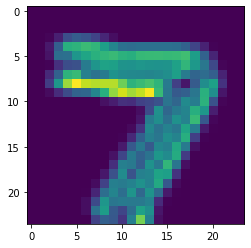

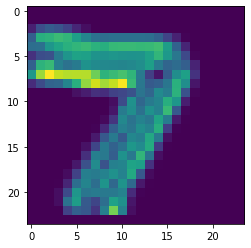

In [ ]:
plt.imshow(test_heatmaps[a],vmin=0,vmax=1)
plt.show()
plt.imshow(od_heatmaps[b],vmin=0,vmax=1)
plt.show()

# Compute Distance_ssim of train, test and OoD

In [ ]:
#@title Generate the heatmaps of test and OD datasets

'''
if len(train_images_shuffled) > 60000:
  train_images_shuffled = train_images_shuffled[:60000]
train_predictions = np.argmax(model.predict(train_images_shuffled[-10000:]),axis=1)
train_heatmaps = generate_heatmaps(train_images_shuffled[-10000:],train_predictions)
'''
# Test heatmaps and predictions
test_predictions = np.argmax(model.predict(test_images),axis=1)
file_name_test_heatmaps = f'test_heatmaps_{DATASET_NAME}_{MODEL_NAME}_{DATASET_NAME}.npy'
path_test_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_test_heatmaps)
if os.path.isfile(path_test_heatmaps):
  print(f'Test heatmaps for {selectedDataset.value} exist, they will be loaded')
  test_heatmaps = np.load(path_test_heatmaps)
else:
  print('Generating the test heatmaps:')
  if len(test_images) > 10000:
    test_images = test_images[:10000]
  test_heatmaps = generate_heatmaps(test_images,test_predictions)
  np.save(path_test_heatmaps, test_heatmaps, allow_pickle=False)

# Load the selected OD dataset
NUM_CLASSES_OD = 10
if OD_dataset.value == 'SVHN_cropped':
  od_test_images, od_test_labels = load_svhn('/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Datasets/SVHN_Cropped',"test_32x32.mat")
  np.random.shuffle(od_test_images)
  od_test_images = od_test_images[:10000]
elif OD_dataset.value == 'MNIST':
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = tf.keras.datasets.mnist.load_data()
  od_test_images = od_test_images/255
  od_test_images = od_test_images.reshape(10000,28,28,1)
  od_test_images = od_test_images.astype('float32')
  od_test_labels = to_categorical(od_test_labels)
elif OD_dataset.value == 'Fashion_MNIST':
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = tf.keras.datasets.fashion_mnist.load_data()
  od_test_images = od_test_images/255
  od_test_images = od_test_images.reshape(10000,28,28,1)
  od_test_images = od_test_images.astype('float32')

elif OD_dataset.value == 'MNIST_color':
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = tf.keras.datasets.mnist.load_data()
  od_test_images = od_test_images/255
  od_test_images = od_test_images.reshape(10000,28,28,1)
  od_test_images = od_test_images.astype('float32')
  od_test_images = np.tile(od_test_images,3)
  od_test_images = resize(od_test_images,(10000, 32, 32, 3)) 
elif OD_dataset.value == 'Fashion_MNIST_color':
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = tf.keras.datasets.fashion_mnist.load_data()
  od_test_images = od_test_images/255
  od_test_images = od_test_images.reshape(10000,28,28,1)
  od_test_images = od_test_images.astype('float32')
  od_test_images = np.tile(od_test_images,3)
  od_test_images = resize(od_test_images,(10000, 32, 32, 3))
elif OD_dataset.value == 'Cifar10_grey':
  cifar = tf.keras.datasets.cifar10
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = cifar.load_data()
  # Damos el formato correspondiente a las imagenes
  od_test_images = od_test_images.reshape(10000, 32, 32, 3)
  od_test_images = od_test_images.astype('float32') / 255
  od_test_images = np.expand_dims(color.rgb2gray(od_test_images),axis=3)
  od_test_images = resize(od_test_images,(10000, 28, 28, 1))
elif OD_dataset.value == 'Cifar10':
  cifar = tf.keras.datasets.cifar10
  (od_train_images, od_train_labels), (od_test_images, od_test_labels) = cifar.load_data()
  # Damos el formato correspondiente a las imagenes
  od_test_images = od_test_images.reshape(10000, 32, 32, 3)
  od_test_images = od_test_images.astype('float32') / 255
else:
  raise NameError()

# OoD heatmaps and predictions
OD_DATASET_NAME = OD_dataset.value
od_predictions = np.argmax(model.predict(od_test_images),axis=1)
file_name_od_test_heatmaps = f'od_test_heatmaps_{OD_DATASET_NAME}_{MODEL_NAME}_{DATASET_NAME}.npy'
path_od_test_heatmaps = os.path.join(OBJS_DIR_NAME, file_name_od_test_heatmaps)
if os.path.isfile(path_od_test_heatmaps):
  print(f'OoD heatmaps for {OD_DATASET_NAME} exist, they will be loaded')
  od_heatmaps = np.load(path_od_test_heatmaps)
else:
  print(f'Generating the Out-of-Distribution heatmaps of {OD_DATASET_NAME} dataset:')
  if len(od_test_images) > 10000:
    od_test_images = od_test_images[:10000]
  od_heatmaps = generate_heatmaps(od_test_images,od_predictions)
  np.save(path_od_test_heatmaps, od_heatmaps, allow_pickle=False)

Test heatmaps for MNIST exist, they will be loaded
Generating the Out-of-Distribution heatmaps of Fashion_MNIST dataset:


10000it [03:43, 44.65it/s]


In [ ]:
# Distance
def dist_ssim_thresholds_for_each_TPR(dist_test):
  # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
  sorted_distances_test = [np.sort(x) for x in dist_test][::-1]
  tpr_range = np.arange(0,1,0.01)
  tpr_range[-1] = 0.99999999 # For selecting the last item correctly
  distance_thresholds_test = np.zeros((NUM_CLASSES, len(tpr_range)))
  for class_index in range(NUM_CLASSES):
    for index, tpr in enumerate(tpr_range):
      distance_thresholds_test[class_index, index] = sorted_distances_test[class_index][int(len(sorted_distances_test[class_index])*tpr)]
  return distance_thresholds_test


def compare_distances_to_distance_thrs(distances_list_per_class, thr_distances_array):
  '''
  Function that creates an array of shape (tpr, InD_or_OD), where tpr has the lenght of the number of steps of the TPR list
  and second dimensions has the total lenght of the distances_list_per_class, and cotains True if its InD and False if is OD
  :distances_list_per_class: list with each element being an array with the distances to avg clusters of one class [array(.), array(.)]
  :thr_distances_array: array of shape (class, dist_for_each_tpr), where first dimension is the class and the second is the distance for the TPR
   corresponding to that position. For example, the TPR = 0.85 corresponds to the 85th position.
  '''
  in_or_out_distribution_per_tpr = np.zeros((len(np.transpose(thr_distances_array)),len(np.concatenate(distances_list_per_class))),dtype=bool)
  for tpr_index ,thr_distances_per_class in enumerate(np.transpose(thr_distances_array)):
      in_or_out_distribution_per_tpr[tpr_index] = np.concatenate([dist_one_class < thr_distances_per_class[cls_index] for cls_index, dist_one_class in enumerate(distances_list_per_class)])
    
  return in_or_out_distribution_per_tpr


def compute_precision_tpr_fpr_for_test_and_OoD_distance(dist_test, dist_OoD,dist_thresholds_test):
  # Creation of the array with True if predicted InD (True) or OD (False)
  in_or_out_distribution_per_tpr_test = compare_distances_to_distance_thrs(dist_test, dist_thresholds_test)
  in_or_out_distribution_per_tpr_test[0] = np.zeros((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that one element is True when TPR is 0
  in_or_out_distribution_per_tpr_test[-1] = np.ones((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that last element is True when TPR is 1
  in_or_out_distribution_per_tpr_OoD = compare_distances_to_distance_thrs(dist_OoD, dist_thresholds_test)

  # Creation of arrays with TP, FN and FP, TN
  tp_fn_test = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_test)
  fp_tn_OoD = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_OoD)

  # Computing TPR, FPR and Precision
  tpr_values = tp_fn_test[:,0] / (tp_fn_test[:,0] + tp_fn_test[:,1])
  fpr_values = fp_tn_OoD[:,0] / (fp_tn_OoD[:,0] + fp_tn_OoD[:,1])
  precision  = tp_fn_test[:,0] / (tp_fn_test[:,0] + fp_tn_OoD[:,0])

  # Eliminating NaN value at TPR = 1
  precision[0] = 1
  return precision, tpr_values, fpr_values


# For both
def tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr):
  '''
  Function that creates an array with the number of values of tp and fp or fn and tn, depending on if the 
  passed array is InD or OD.
  :in_or_out_distribution_per_tpr: array with True if predicted InD and False if predicted OD, for each TPR
  ::return: array with shape (tpr, 2) with the 2 dimensions being tp,fn if passed array is InD, and fp and tn if the passed array is OD
  '''
  tp_fn_fp_tn = np.zeros((len(in_or_out_distribution_per_tpr),2),dtype='uint16')
  length_array = in_or_out_distribution_per_tpr.shape[1]
  for index, element in enumerate(in_or_out_distribution_per_tpr):
    n_True = int(len(element.nonzero()[0]))
    tp_fn_fp_tn[index,0] = n_True
    tp_fn_fp_tn[index,1] = length_array - n_True
  return tp_fn_fp_tn

Dist_ssim

In [ ]:
# Train
dist_ssim_per_image_train = compute_ssim_against_cluster_averages(train_heatmaps,train_predictions,average_heatmaps_per_class_and_cluster,mode='Distance')
# Test
dist_ssim_per_image_test = compute_ssim_against_cluster_averages(test_heatmaps,test_predictions,average_heatmaps_per_class_and_cluster,mode='Distance')
# OD
dist_ssim_per_image_od = compute_ssim_against_cluster_averages(od_heatmaps,od_predictions,average_heatmaps_per_class_and_cluster,mode='Distance')

10000it [00:05, 1920.15it/s]


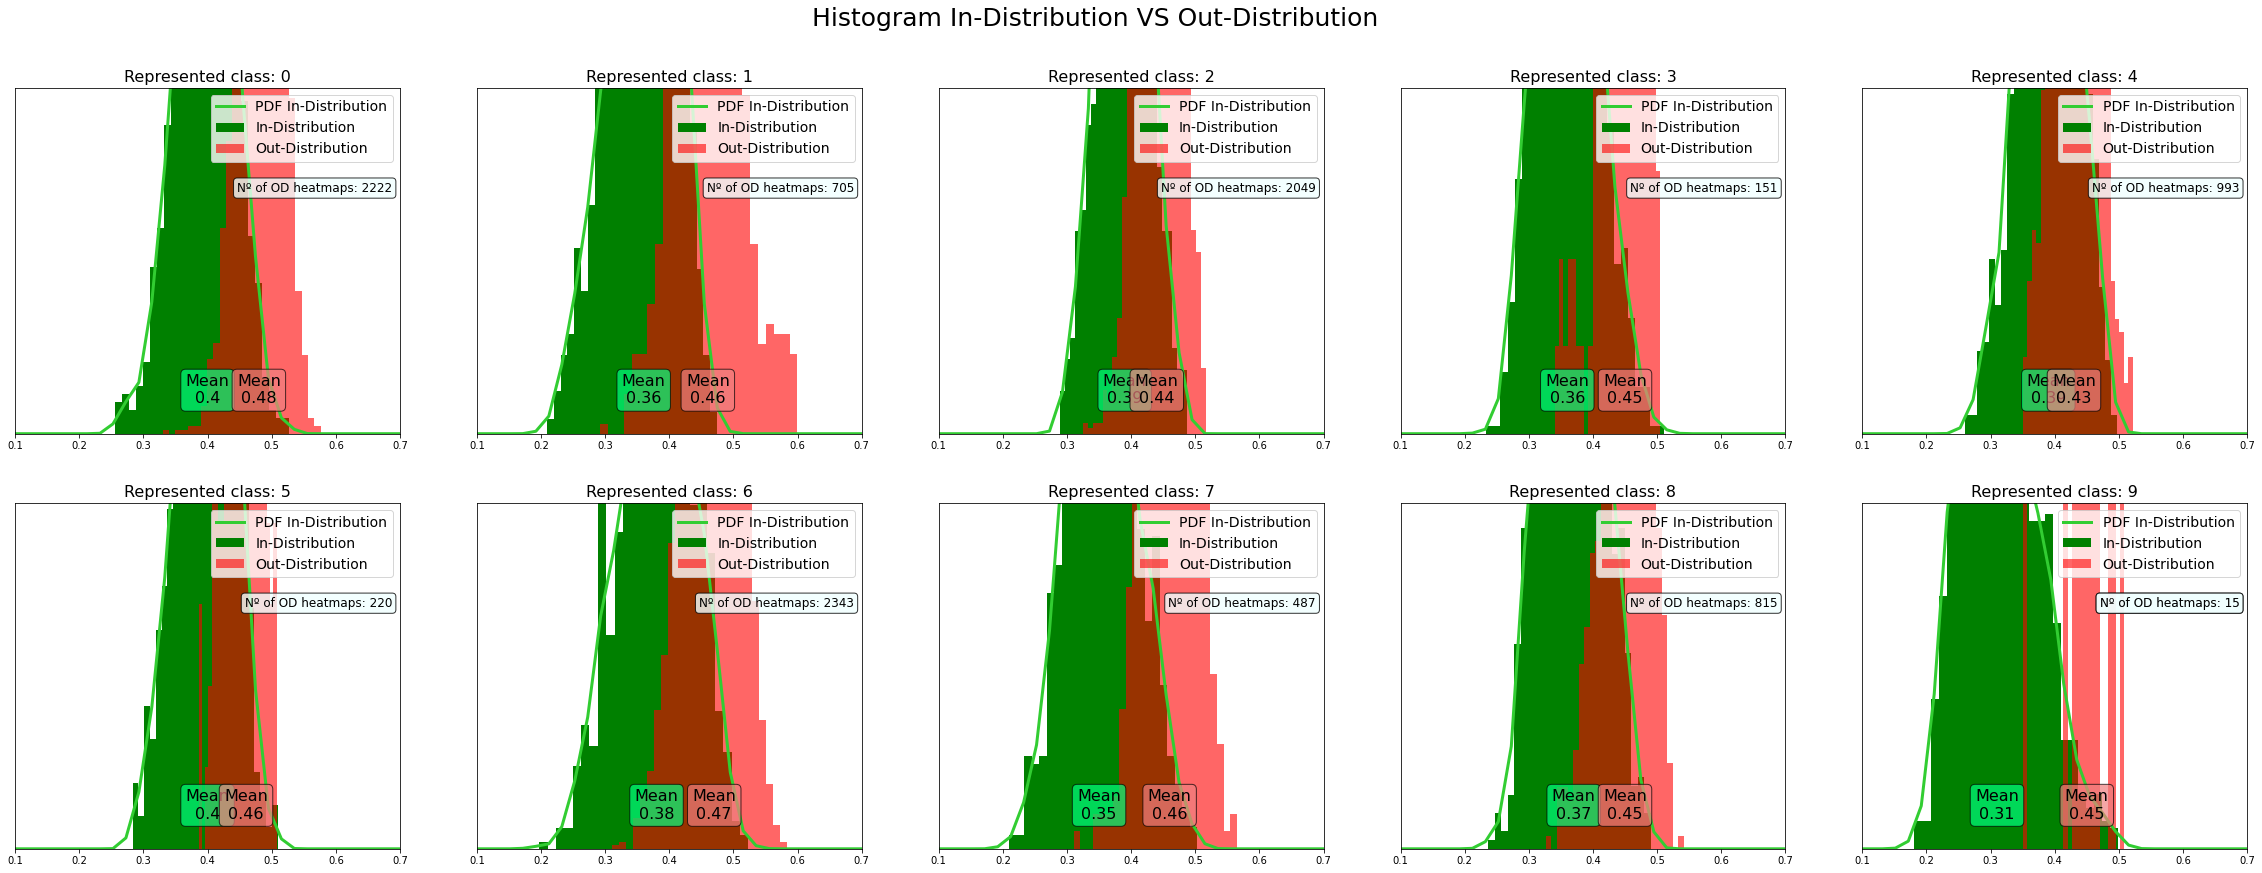

In [ ]:
#@title Histogram of D_ssim values per class
# Funcion que representa el % de instancias que SI activan el threshold tanto CON como SIN deriva 
# Inicializar los rangos para los que se calcula la CDF
x = np.linspace(-1,1,100)
y = np.linspace(1,-1,100)

# Propiedades de la caja donde va el texto
props               = dict(boxstyle='round', facecolor='azure', alpha=0.8)
meanBoxProps        = dict(boxstyle='round', facecolor='springgreen', alpha=0.7)
meanOutDistBoxProps = dict(boxstyle='round', facecolor='lightcoral', alpha=0.7)
# Creacion de figura
fig, ax = plt.subplots(2,5,sharey=True,figsize=(40,14))
plot_verde  = 'In-Distribution'   
plot_rojo   = 'Out-Distribution'
fig.suptitle('Histogram In-Distribution VS {}'.format(plot_rojo), fontsize=25,y=0.96)

for class_index in range(10):
  # The count of how many od images are classified as each class
  unique, od_counts = np.unique(od_predictions, return_counts=True)
  # KDE fitting
  kde_sci = stats.gaussian_kde(dist_ssim_per_image_test[np.where(test_predictions==class_index)])
  cdf = []
  for i in x:
    cdf.append(kde_sci.integrate_box_1d(-1,i))
  # KDE fitting
  try:
    if od_counts[class_index] > 50:
      kde_sci_OOD = stats.gaussian_kde(dist_ssim_per_image_od[np.where(od_predictions==class_index)])
      cdf_OOD = []
      for i in y:
        cdf_OOD.append(kde_sci_OOD.integrate_box_1d(i,1))
  except KeyError:
    raise NameError('Error')
    pass
  # Calculo del punto de cruce minimizando diferencia entre CDFs. La solucion nos da la posicion del punto de minima 
  # diferencia dentro del array, no el valor en si
  sol = minimize_scalar(cdf_difference,args=(kde_sci,kde_sci_OOD),method='bounded',bounds=(1,99),options={'xatol': 0.001,'maxiter': 100, 'disp': 0})
  # Punto de cruce es el valor del eje X en la posicion de la solucion 
  p_cruce = x[int(sol.x)]
  tpr_cruce = round(kde_sci.integrate_box_1d(p_cruce,1),3)
  fpr_cruce = round(1-kde_sci_OOD.integrate_box_1d(-1,p_cruce),3)
  
  # Definicion de i y j para plotear bien
  i=0
  j=class_index
  if class_index >= 5:
    i = 1
    j = class_index-5

  # Plots de KDE
  ax[i,j].set_xlim((0.1,0.7))
  ax[i,j].set_ylim((0,4))
  ax[i,j].set_yticks([])
  ax[i,j].hist(dist_ssim_per_image_test[np.where(test_predictions==class_index)], density=True,bins=25,color='green',label=plot_verde)
  ax[i,j].hist(dist_ssim_per_image_od[np.where(od_predictions==class_index)], density=True,bins=25,color='red',alpha=0.6,label=plot_rojo)
  ax[i,j].plot(x, kde_sci.pdf(x), lw=3, label='PDF {}'.format(plot_verde), color='limegreen',zorder=1)
  #ax[i,j].plot(x, cdf, lw=3, label='CDF {}'.format(plot_verde), color='chartreuse',zorder=2)
  ax[i,j].set_title('Represented class: {}'.format(CLASS_NAMES[class_index]),fontsize=16)

  meanInDistPerClass = round(dist_ssim_per_image_test[np.where(test_predictions==class_index)].mean(),2)
  ax[i,j].text(x=meanInDistPerClass,y=0.35,s='Mean\n'+str(meanInDistPerClass),fontsize=16,fontweight='medium',bbox=meanBoxProps,horizontalalignment='center',zorder=4)

  # Texto a representar
  altura_texto = 0.71
  textstr = 'Nº of OD heatmaps: {}'.format(od_counts[class_index])
  try:
    if od_counts[class_index] > 50:
      #ax[i,j].plot(y, cdf_OOD, lw=3, label='CDF {}'.format(plot_rojo), color='orangered',zorder=3)
      # Texto
      meandOutDistPerClass = round(dist_ssim_per_image_od[np.where(od_predictions==class_index)].mean(),2)
      ax[i,j].text(x=meandOutDistPerClass,y=0.35,s='Mean\n'+str(meandOutDistPerClass),fontsize=16,fontweight='medium',bbox=meanOutDistBoxProps,horizontalalignment='center',zorder=4)
      ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
    else:
      try:
        meandOutDistPerClass = round(dist_ssim_per_image_od[np.where(od_predictions==class_index)].mean(),2)
        ax[i,j].text(x=meandOutDistPerClass,y=0.35,s='Mean\n'+str(meandOutDistPerClass),fontsize=16,fontweight='medium',bbox=meanOutDistBoxProps,horizontalalignment='center',zorder=4)

        ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
      except:
        textstr = 'Nº inputs: 0'
      ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  except KeyError:
    textstr = 'Nº inputs: 0'
    ax[i,j].text(0.98, altura_texto, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  #ax[i,j].axvline(x=p_cruce, ymin=0, ymax=1,color='fuchsia',label='Threshold',linewidth=3,linestyle='--',zorder=5)
  ax[i,j].legend(fontsize=14, loc='upper right')

#fig.savefig('./Hist_{}_vs_{}'.format(plot_verde,plot_rojo),dpi=200)
fig.savefig('./Hist_{}_vs_{}.pdf'.format(plot_verde,plot_rojo))

### AUROC and AUPR

In [ ]:
''' Using the distance '''
# Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
dist_per_class_per_image_train = [dist_ssim_per_image_train[np.where(train_predictions == class_index)] for class_index in range(NUM_CLASSES)]
dist_per_class_per_image_test = [dist_ssim_per_image_test[np.where(test_predictions == class_index)] for class_index in range(NUM_CLASSES)]
dist_per_class_per_image_od = [dist_ssim_per_image_od[np.where(od_predictions == class_index)] for class_index in range(NUM_CLASSES)]
dist_ssim_thresholds_train = dist_ssim_thresholds_for_each_TPR(dist_per_class_per_image_train)
# Conmputing precision, tpr and fpr
precision, tpr_values, fpr_values = compute_precision_tpr_fpr_for_test_and_OoD_distance(dist_per_class_per_image_test, dist_per_class_per_image_od, dist_ssim_thresholds_train)
# Appending that when FPR = 1 the TPR is also 1:
tpr_values_auroc = np.append(tpr_values,1)
fpr_values_auroc = np.append(fpr_values,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


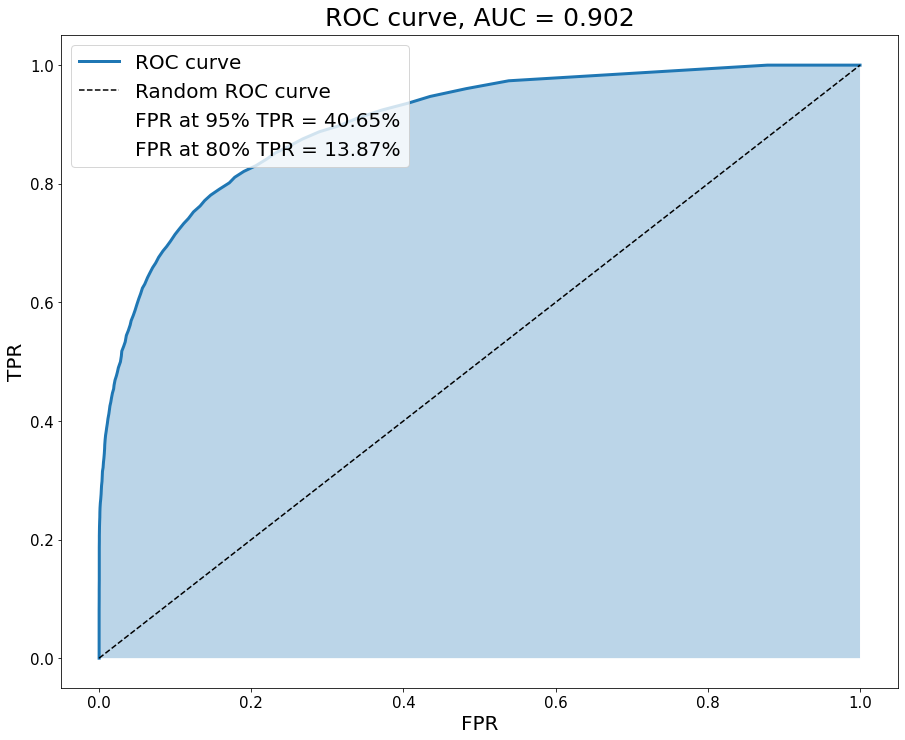

In [ ]:
# Calculo del AUC
auc = np.trapz(tpr_values_auroc, fpr_values_auroc)
# Plot
plt.figure(figsize=(15,12))
roc = plt.plot(fpr_values_auroc,tpr_values_auroc,label='ROC curve',lw=3)
rnd_roc = plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'k--',label='Random ROC curve')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
plt.title('ROC curve, AUC = %.3f'%auc,fontsize=25,pad=10)
plt.fill_between(fpr_values_auroc,tpr_values_auroc,alpha=0.3)
# Create empty plot with blank marker containing the extra label
plt.plot([], [], ' ', label='FPR at 95% TPR = {}%'.format(round(fpr_values_auroc[95]*100,2)))
plt.plot([], [], ' ', label='FPR at 80% TPR = {}%'.format(round(fpr_values_auroc[80]*100,2)))
#plt.text(0.60,0.975,'FPR at 95% TPR = {}%'.format(round(array_TPR_FPR_x_threshold[95,1]*100,2)),fontsize=20,bbox=dict(boxstyle="round",facecolor='white', alpha=0.5))
plt.legend(fontsize=20,loc='upper left')
#plt.axhline(y=0.95,linestyle='-',zorder=0)
#plt.axvline(x=array_TPR_FPR_x_threshold[95,1],linestyle='dashed',zorder=0)
#plt.savefig('/content/AUROC')
#plt.savefig(f'/content/AUROC_{selectedDataset.value}_vs_{oodDataset.value}.pdf')

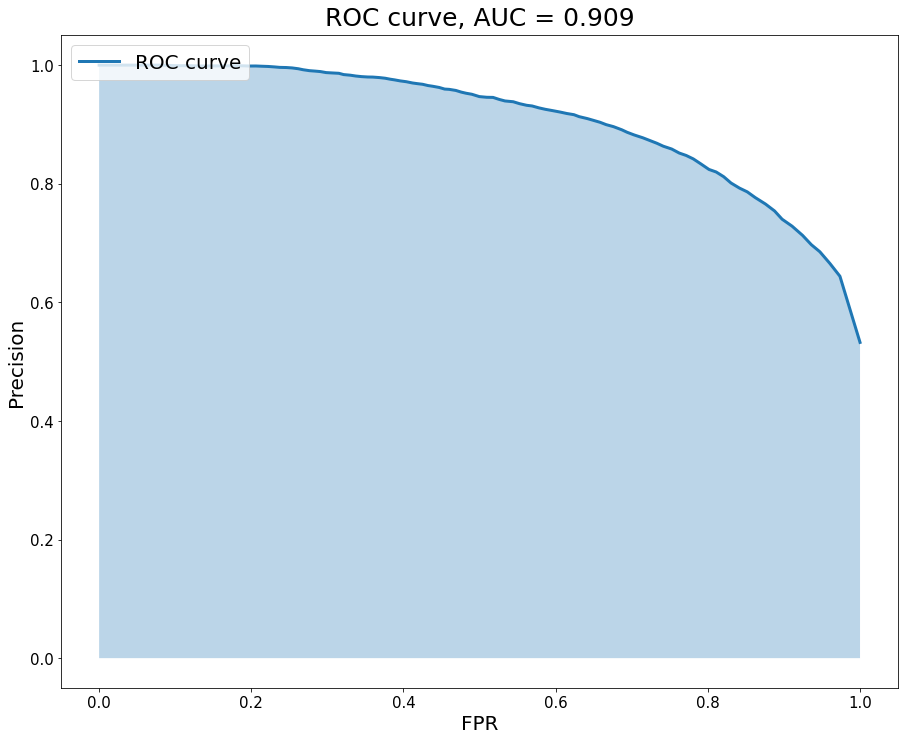

In [ ]:
# Calculo del AUC
auc = np.trapz(precision, tpr_values)
# Plot
plt.figure(figsize=(15,12))
roc = plt.plot(tpr_values,precision,label='ROC curve',lw=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('ROC curve, AUC = %.3f'%auc,fontsize=25,pad=10)
plt.fill_between(tpr_values,precision,alpha=0.3)
plt.legend(fontsize=20,loc='upper left')
#plt.axhline(y=0.95,linestyle='-',zorder=0)
#plt.axvline(x=array_TPR_FPR_x_threshold[95,1],linestyle='dashed',zorder=0)
#plt.savefig('/content/AUROC')
#plt.savefig(f'/content/AUPR_{selectedDataset.value}_vs_{oodDataset.value}.pdf')

SSIM against clusters mean/median